<a href="https://colab.research.google.com/github/dardenkyle/Stock-Market-Trends---Volatility/blob/main/AAPL_Stock_Trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Trends & Volatility Analysis

## Project Information

Stock Market Trends & Volatility Analysis<br>
✅ Skills Used: Python, pandas, Matplotlib/Seaborn, yFinance API, statistics<br>
✅ Time Required: 5-10 hours<br>
✅ Tools: Python, Jupyter Notebook<br>

Project Idea:
* Pull historical stock price data from Yahoo Finance API for Tesla (TSLA), Apple (AAPL), and Bitcoin (BTC).
* Compute daily returns, moving averages, Bollinger Bands, and volatility (standard deviation).
* Visualize stock trends vs. S&P 500 and compare volatility.
* Identify which stock had the highest risk-adjusted returns (Sharpe Ratio).

📌 Example Output: A Jupyter Notebook with time-series plots and summary statistics.

## Importing Necessary Libraries

In [ ]:
# Libraries needed
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import sys
import argparse
import logging
import json
import requests
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBClassifier
from sklearn.ensemble import (AdaBoostClassifier,
                              BaggingClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier,
                              )
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             accuracy_score,
                             recall_score,
                             precision_score,
                             f1_score,
                             make_scorer
                             )

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

In [ ]:
# Preventing scientific notation.
pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [ ]:
tickers = ['AAPL']
# , 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA', 'PYPL', 'ADBE', 'NFLX']

stock_data = yf.download(tickers, period='84mo', interval='1d')

# Convert the stock_data to a DataFrame
data = pd.DataFrame(stock_data)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Creating a copy of the data frame, df, to leave original data unaltered
df = data.copy()

## Data Overview

In [ ]:
# Viewing shape of dataframe
df.shape

(1761, 5)

In [ ]:
# Viewing top 10 rows of df
df.head()

Price       Close   High    Low   Open     Volume
Ticker       AAPL   AAPL   AAPL   AAPL       AAPL
Date                                             
2018-02-05 36.814 38.553 36.699 37.428  290954000
2018-02-06 38.353 38.515 36.229 36.424  272975200
2018-02-07 37.532 38.440 37.421 38.367  206434400
2018-02-08 36.499 37.875 36.471 37.708  217562000
2018-02-09 36.946 37.295 35.488 37.102  282690400

In [ ]:
# Viewing Column Labels
df.columns

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [ ]:
# Information about the data frame's columns.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2018-02-05 to 2025-02-05
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1761 non-null   float64
 1   (High, AAPL)    1761 non-null   float64
 2   (Low, AAPL)     1761 non-null   float64
 3   (Open, AAPL)    1761 non-null   float64
 4   (Volume, AAPL)  1761 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 82.5 KB


In [ ]:
# Checking the data frame for null values.
if df.isnull().values.any():
  print("There are null values.")
else:
  print("There are no null values.")

There are no null values.


In [ ]:
# Checking the data frame for duplicate values.
if df.duplicated().any():
    print("There are duplicate values.")
else:
    print("There are no duplicate values.")

There are no duplicate values.


In [ ]:
# Statistical summary of the columns with data type of "Int64" and "Float64".
df.describe().T

count         mean          std          min          25%  \
Price  Ticker                                                                
Close  AAPL   1761.000      124.927       59.973       33.953       58.860   
High   AAPL   1761.000      126.173       60.462       34.795       60.211   
Low    AAPL   1761.000      123.541       59.397       33.907       58.096   
Open   AAPL   1761.000      124.806       59.913       34.380       59.085   
Volume AAPL   1761.000 99098833.080 54897220.954 15743753.000 61944600.000   

                       50%           75%           max  
Price  Ticker                                           
Close  AAPL        134.347       170.513       259.020  
High   AAPL        136.514       172.075       260.100  
Low    AAPL        132.751       169.068       257.630  
Open   AAPL        134.215       170.251       258.190  
Volume AAPL   86141600.000 119561600.000 426510000.000

**Observations**
* obs 1

## Data Preprocessing

In [ ]:
# Dropping Ticker Column Label since we are only working with the AAPL stock for now
df = df.droplevel(1, axis=1)

In [ ]:
# Checking new column labels
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [ ]:
# Checking df to ensure changes are correct
df.head()

Price       Close   High    Low   Open     Volume
Date                                             
2018-02-05 36.814 38.553 36.699 37.428  290954000
2018-02-06 38.353 38.515 36.229 36.424  272975200
2018-02-07 37.532 38.440 37.421 38.367  206434400
2018-02-08 36.499 37.875 36.471 37.708  217562000
2018-02-09 36.946 37.295 35.488 37.102  282690400

## *EDA*

### Univariate

<Figure size 1000x600 with 0 Axes>

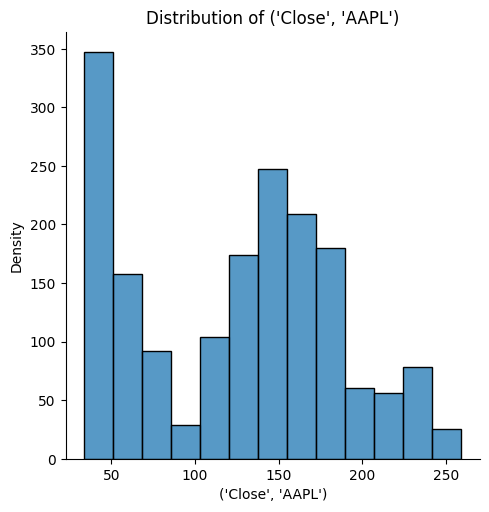

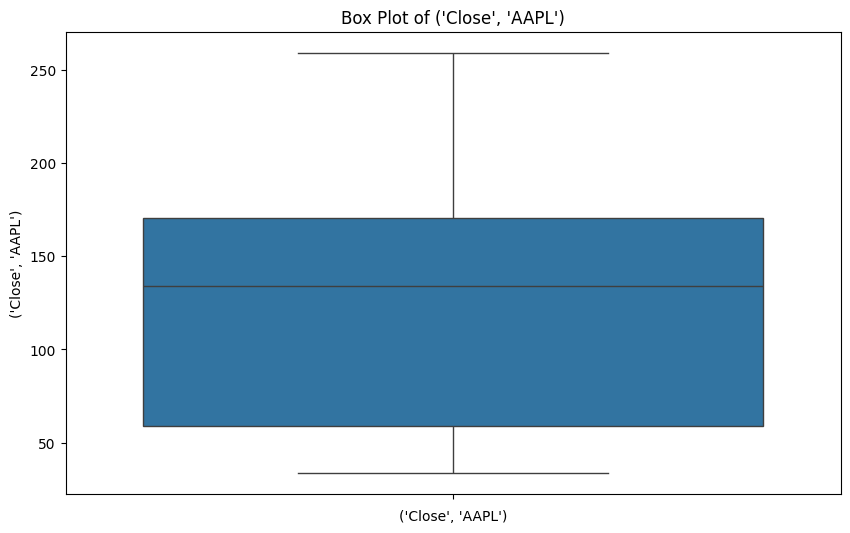

<Figure size 1000x600 with 0 Axes>

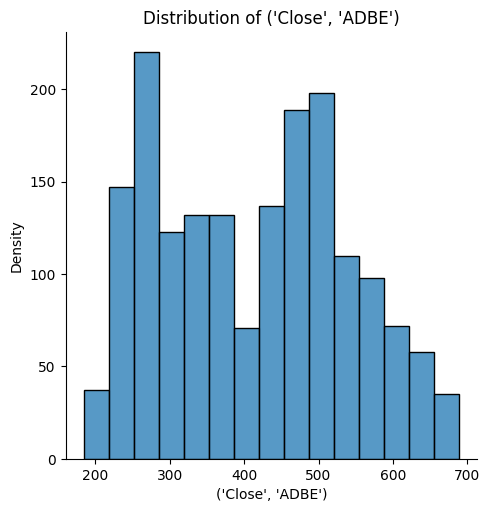

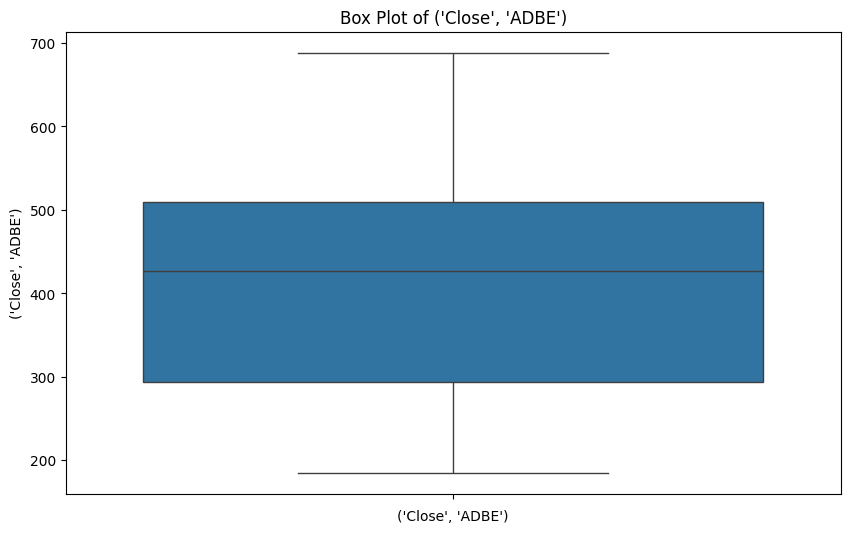

<Figure size 1000x600 with 0 Axes>

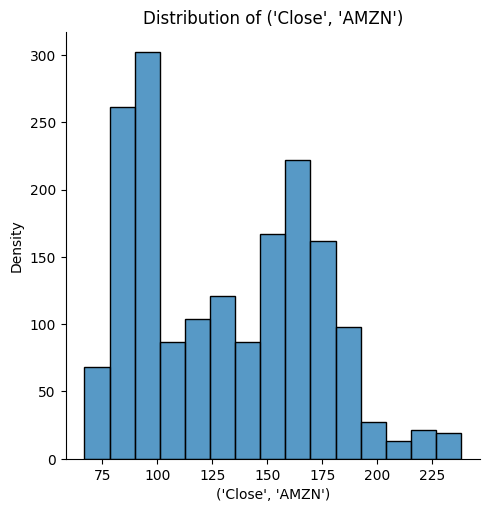

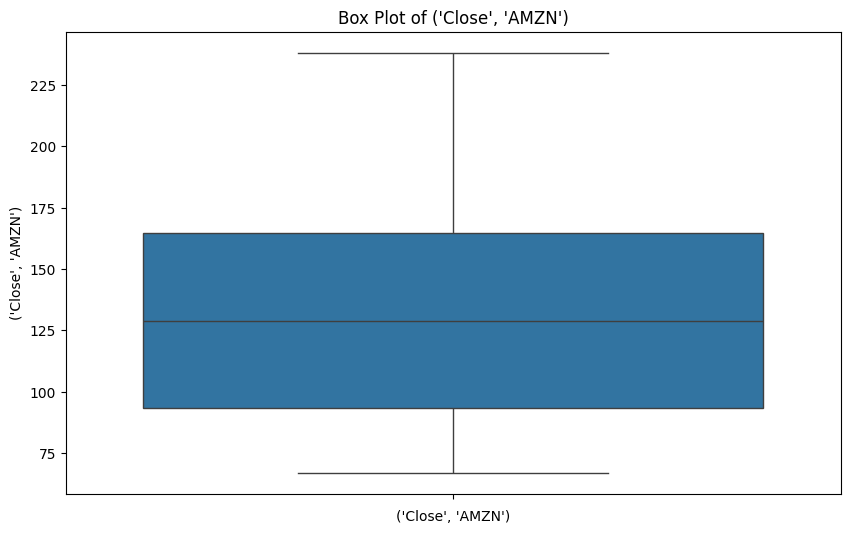

<Figure size 1000x600 with 0 Axes>

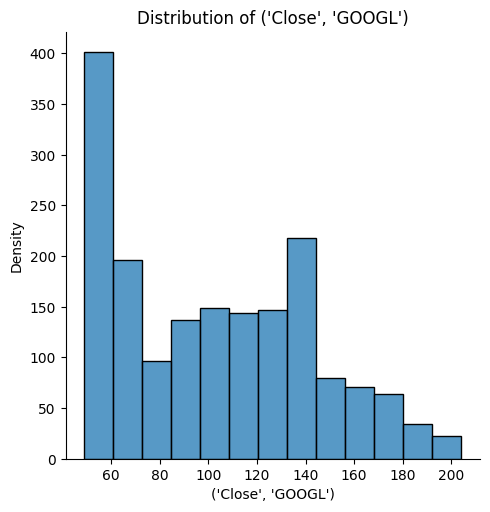

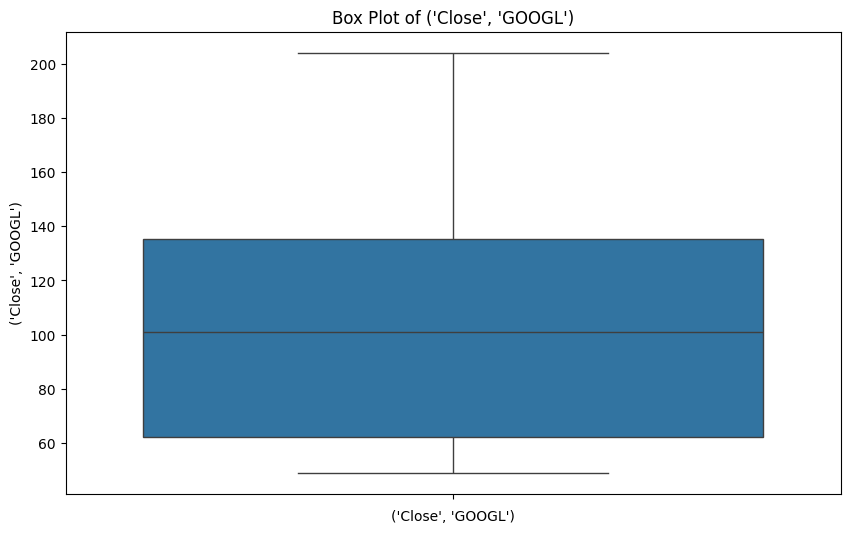

<Figure size 1000x600 with 0 Axes>

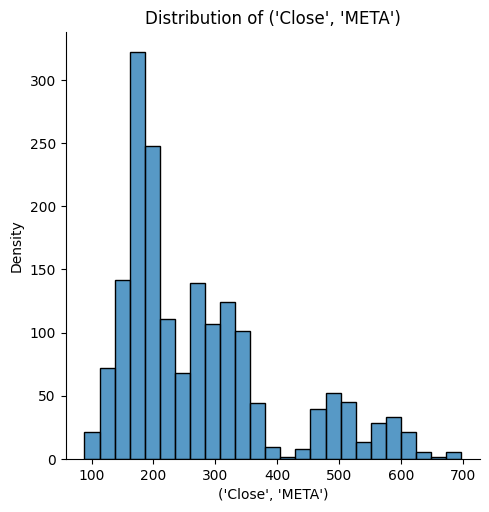

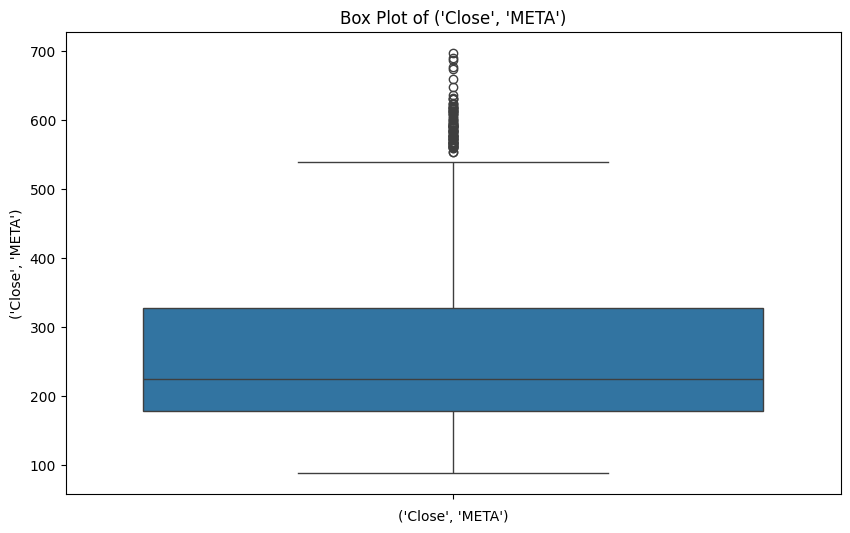

<Figure size 1000x600 with 0 Axes>

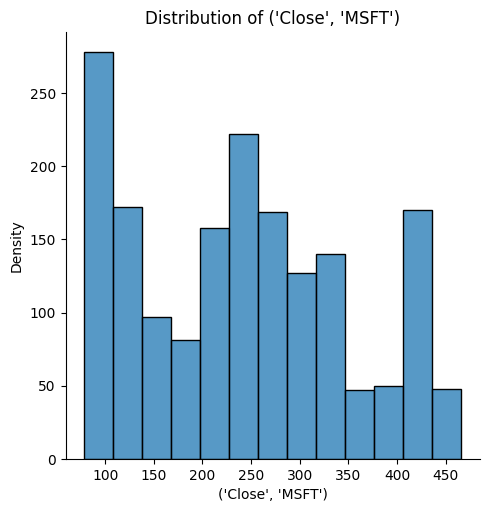

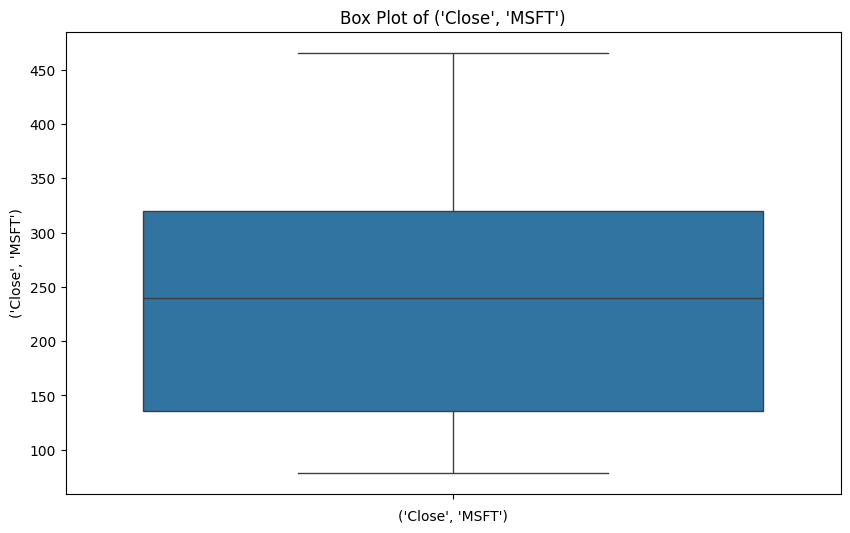

<Figure size 1000x600 with 0 Axes>

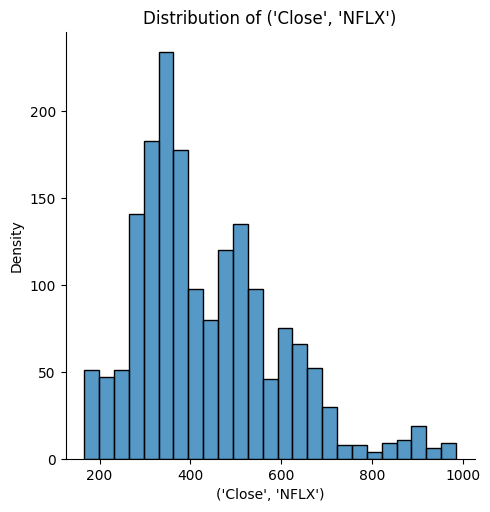

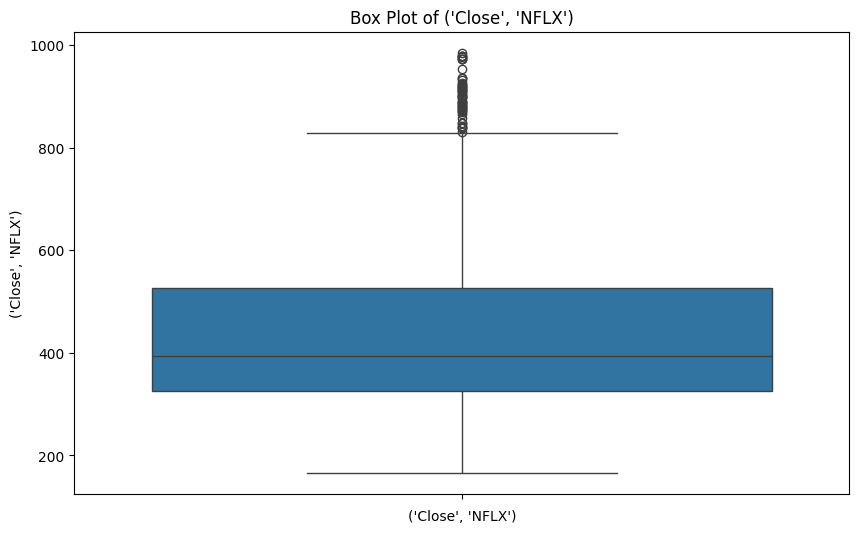

<Figure size 1000x600 with 0 Axes>

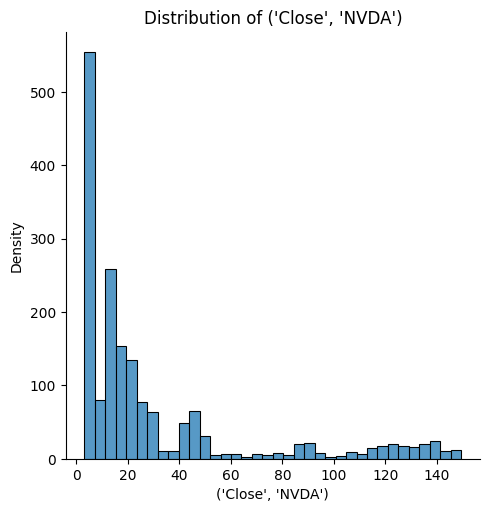

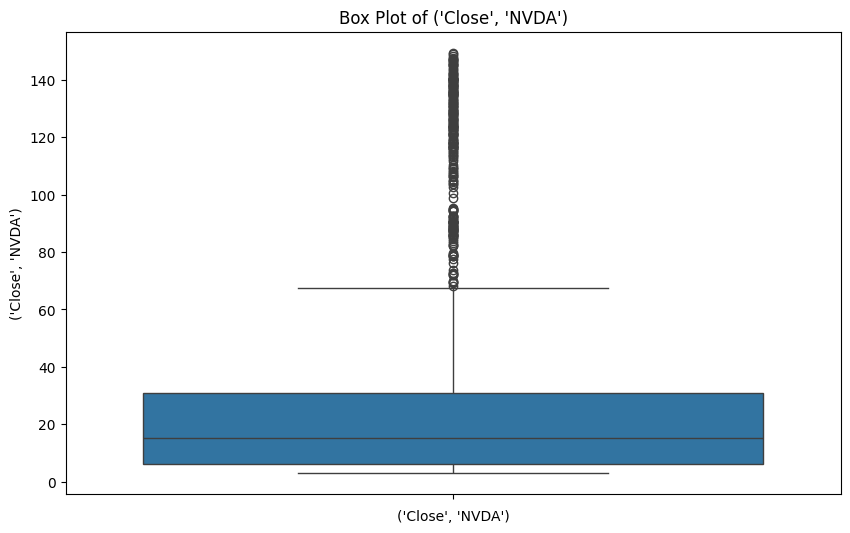

<Figure size 1000x600 with 0 Axes>

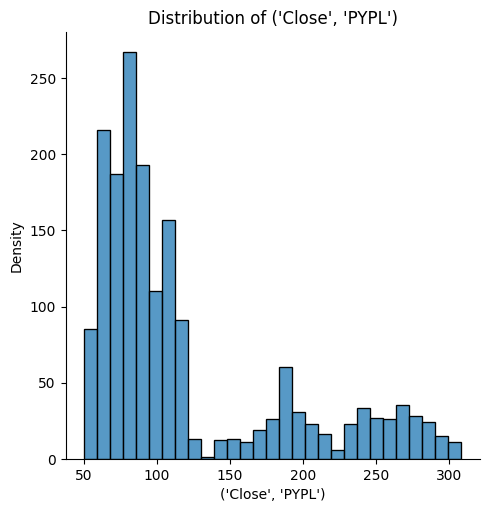

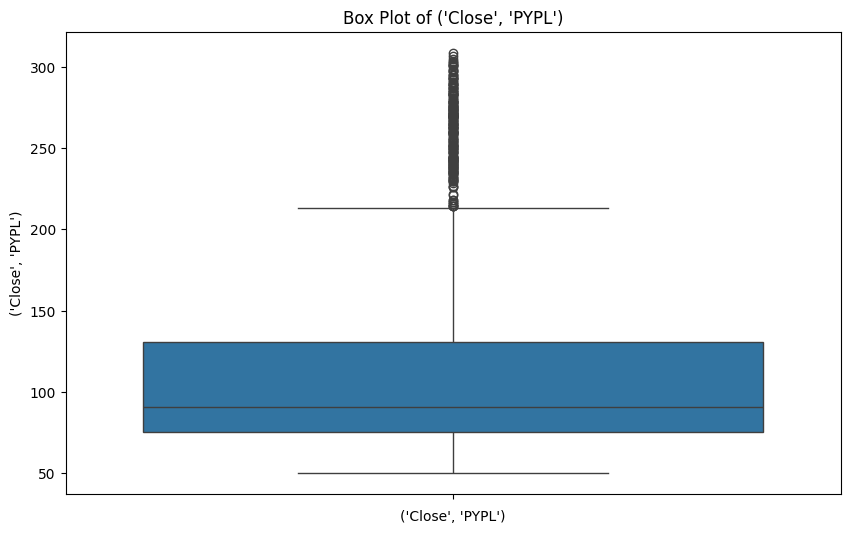

<Figure size 1000x600 with 0 Axes>

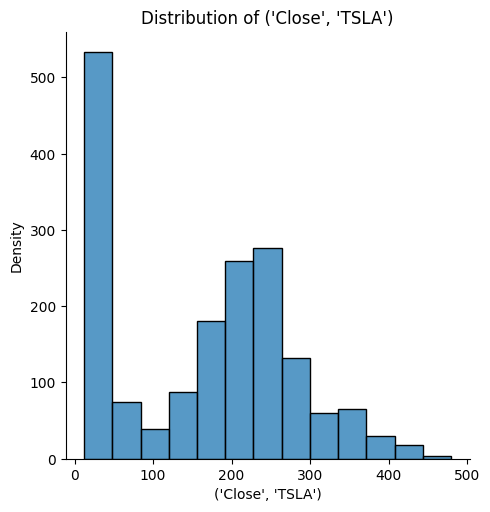

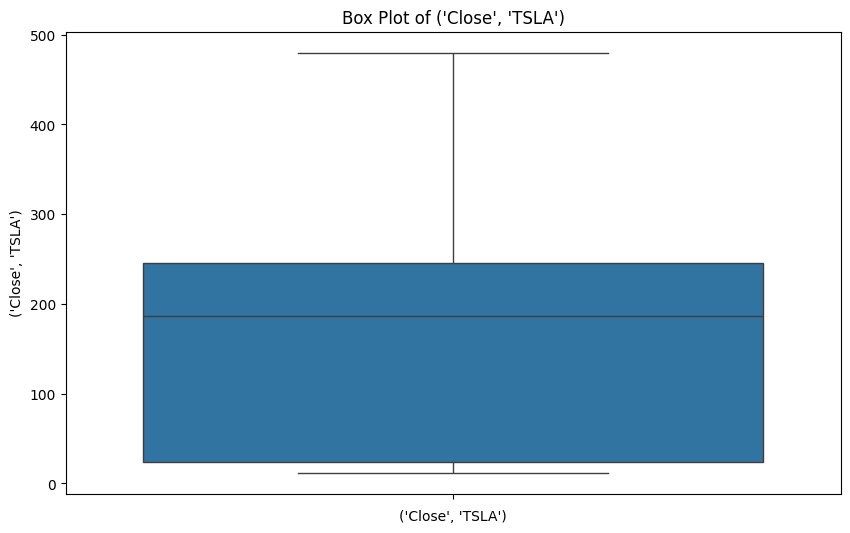

<Figure size 1000x600 with 0 Axes>

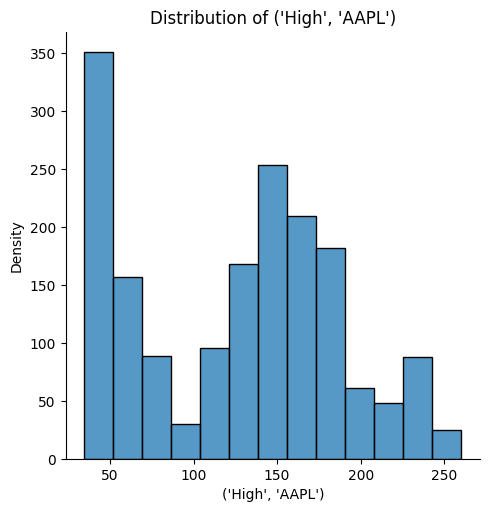

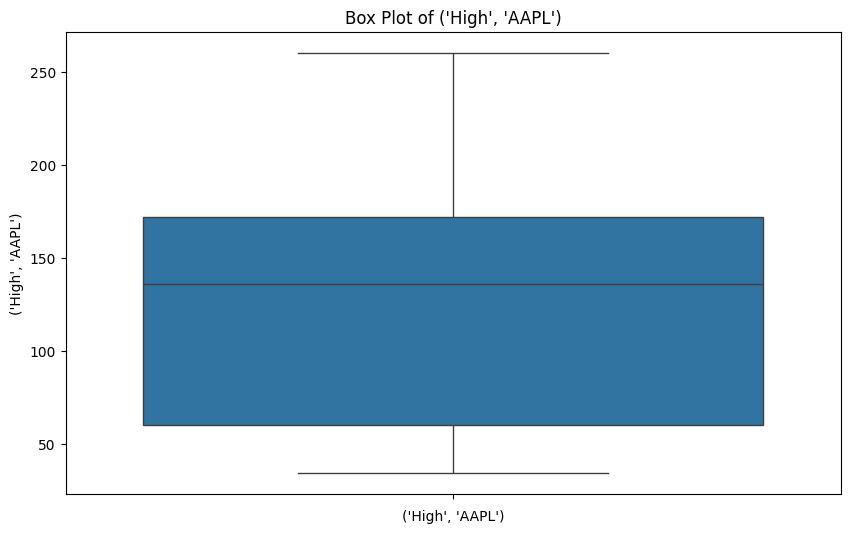

<Figure size 1000x600 with 0 Axes>

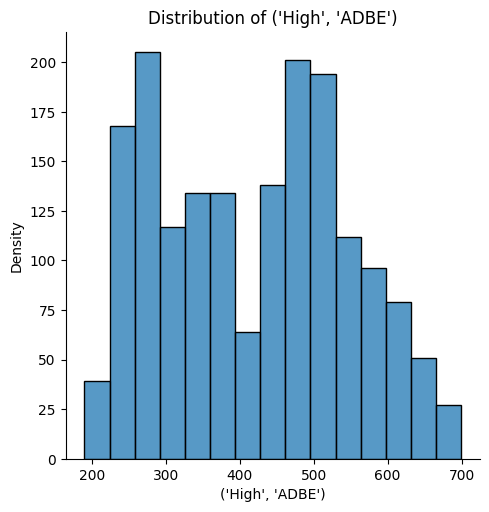

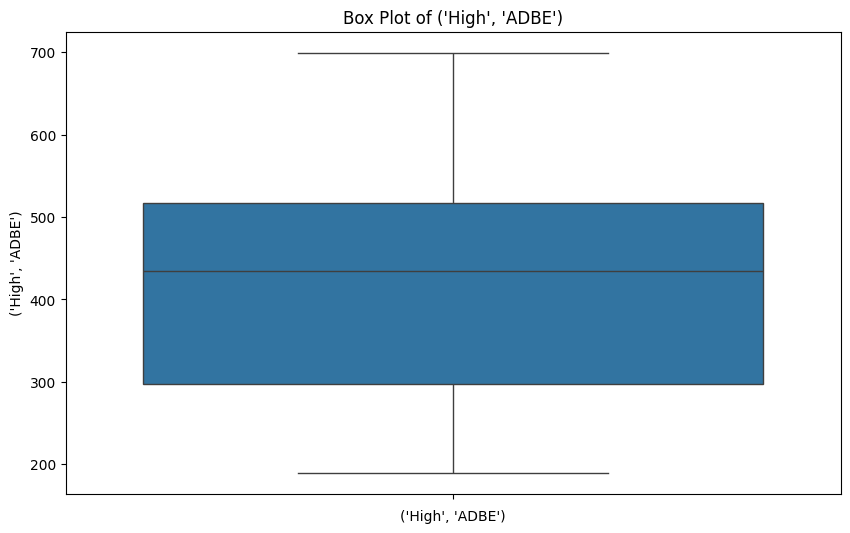

<Figure size 1000x600 with 0 Axes>

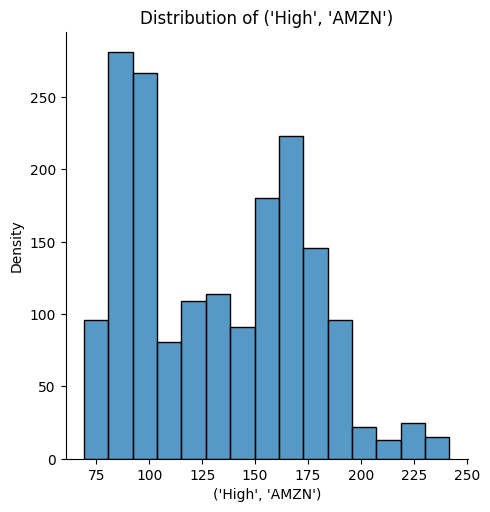

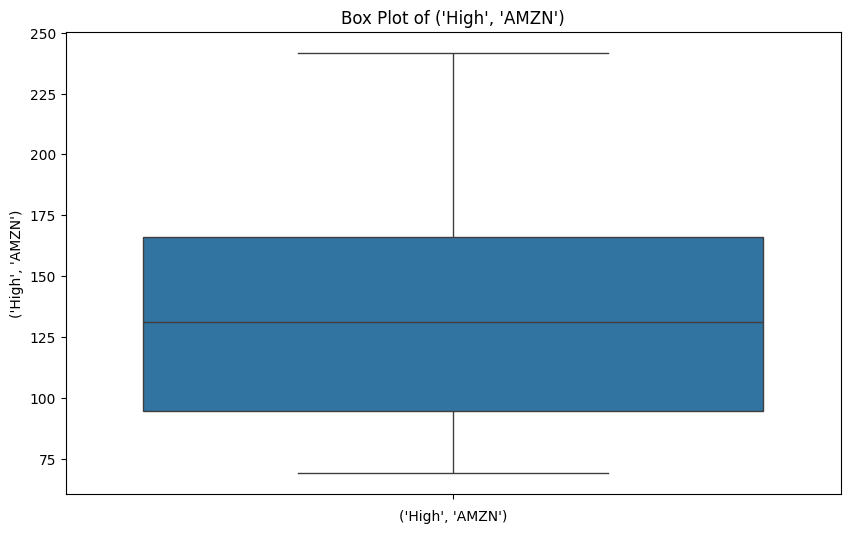

<Figure size 1000x600 with 0 Axes>

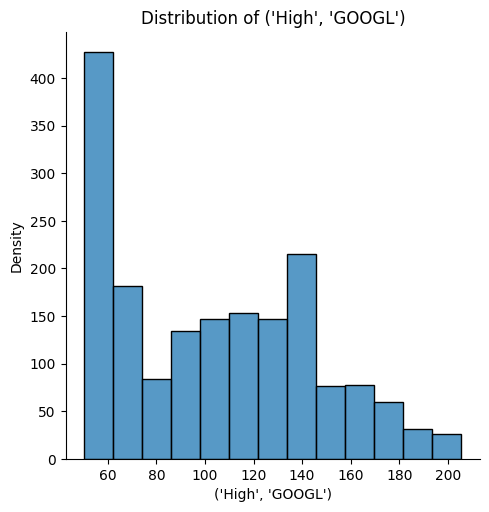

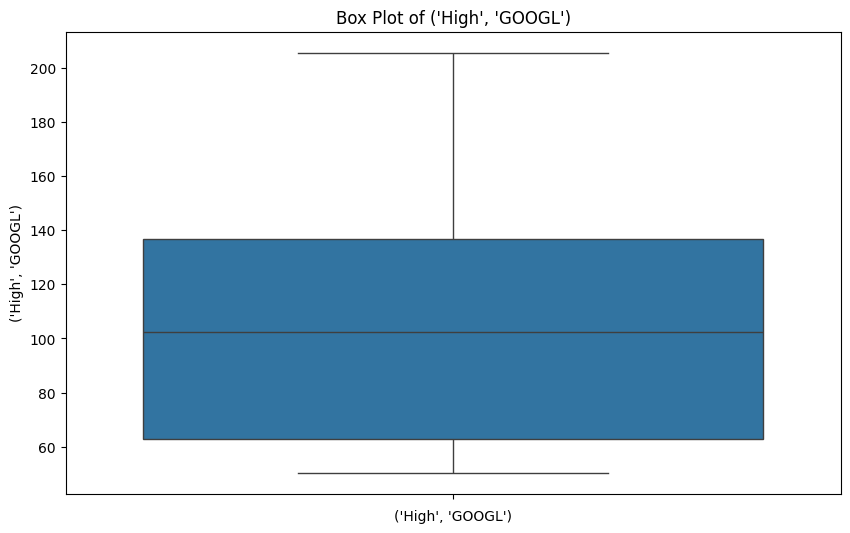

<Figure size 1000x600 with 0 Axes>

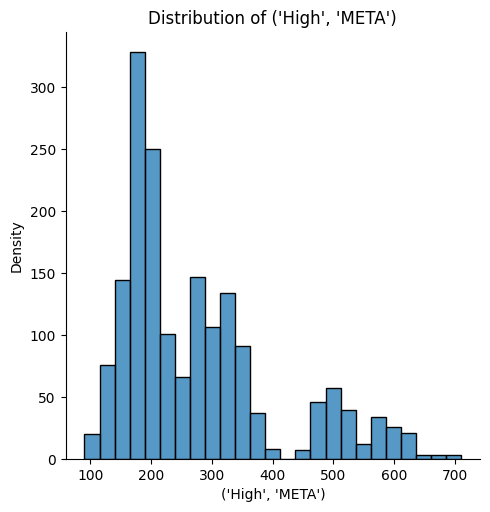

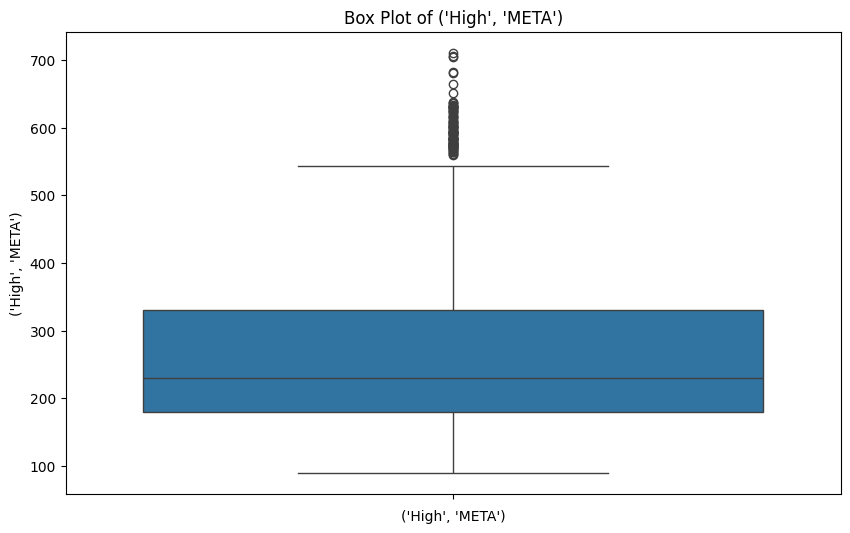

<Figure size 1000x600 with 0 Axes>

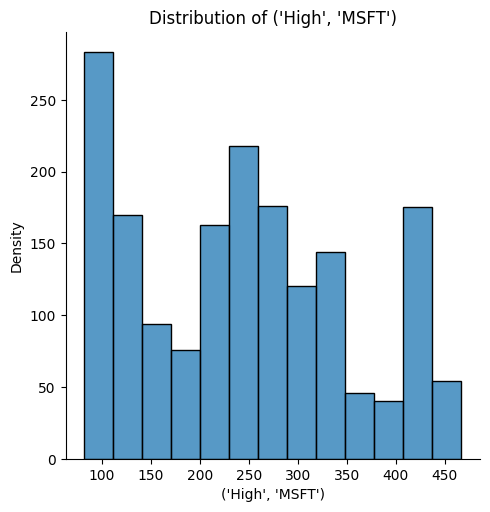

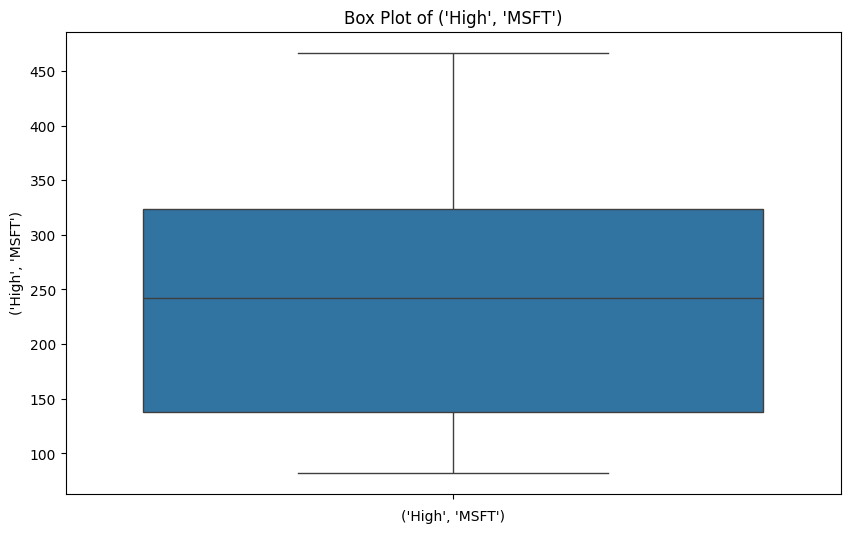

<Figure size 1000x600 with 0 Axes>

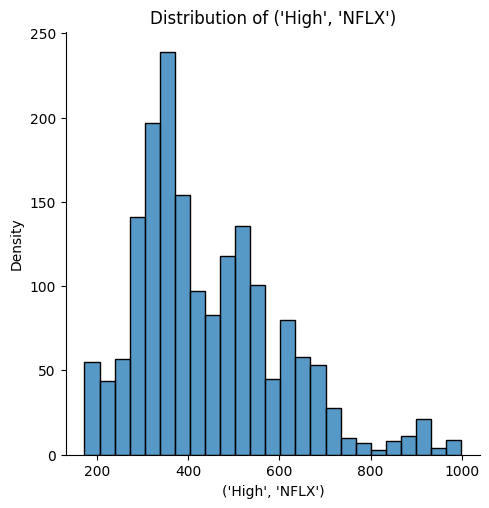

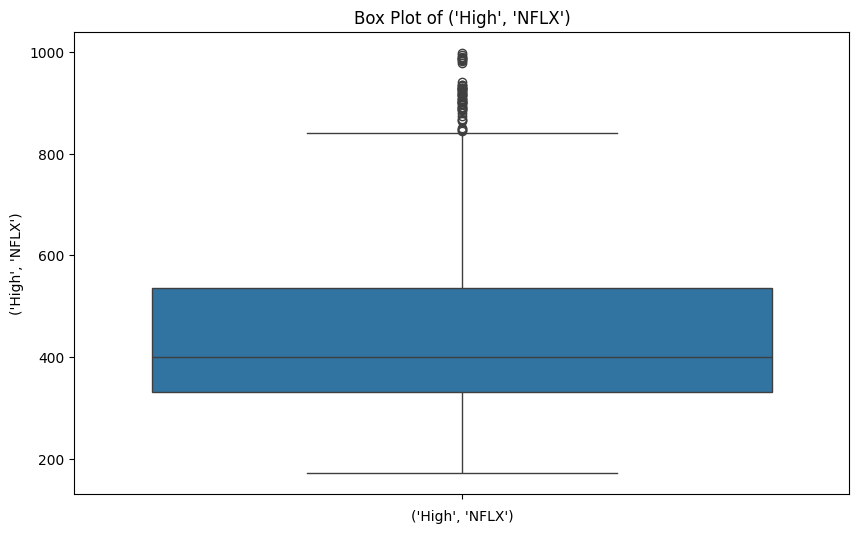

<Figure size 1000x600 with 0 Axes>

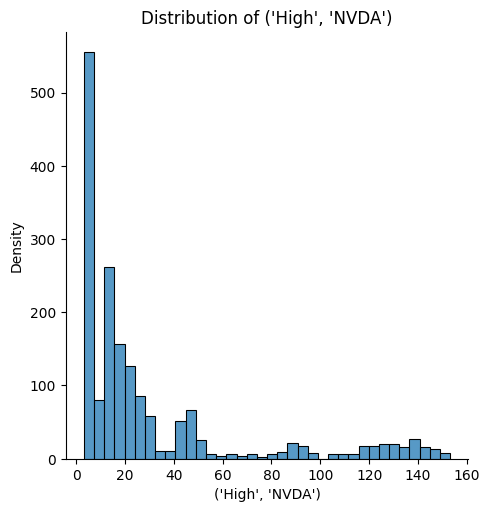

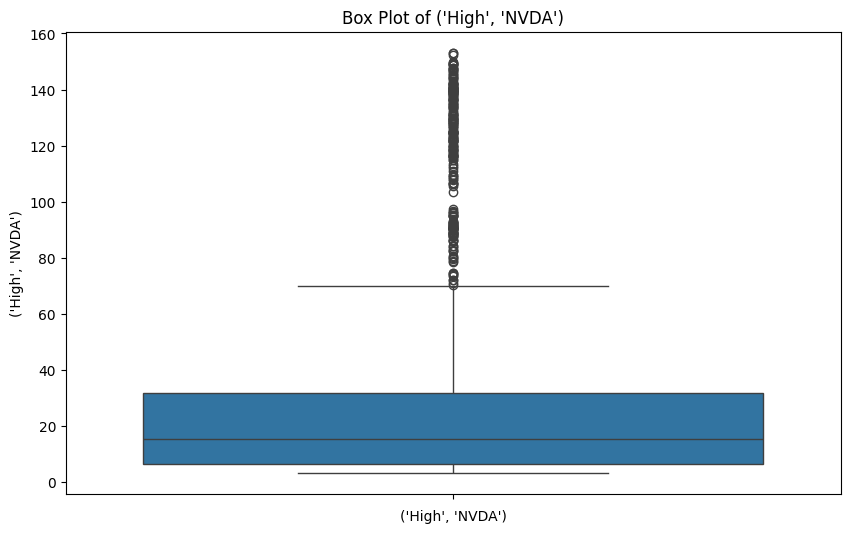

<Figure size 1000x600 with 0 Axes>

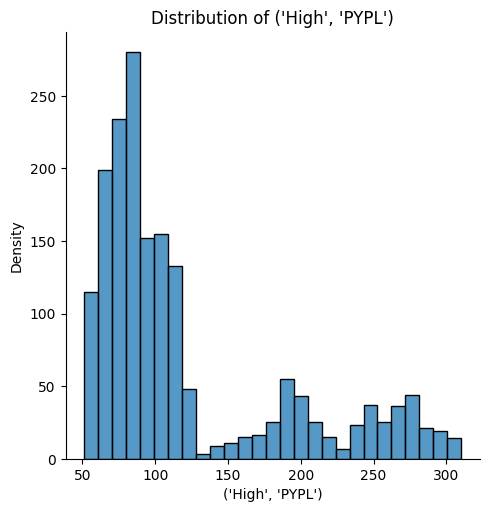

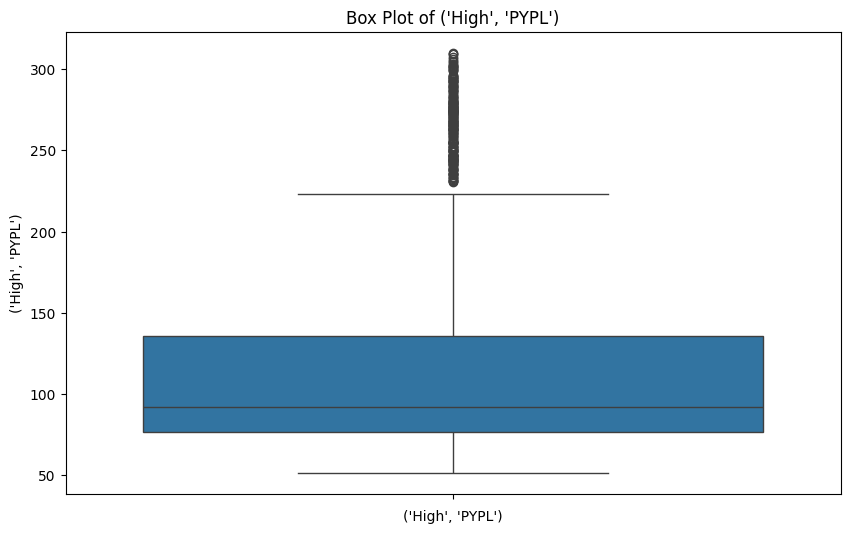

<Figure size 1000x600 with 0 Axes>

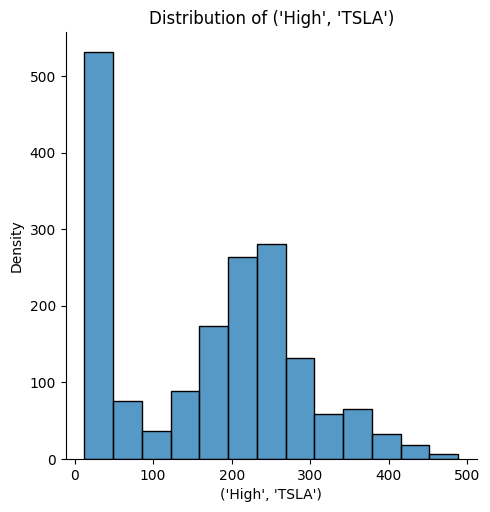

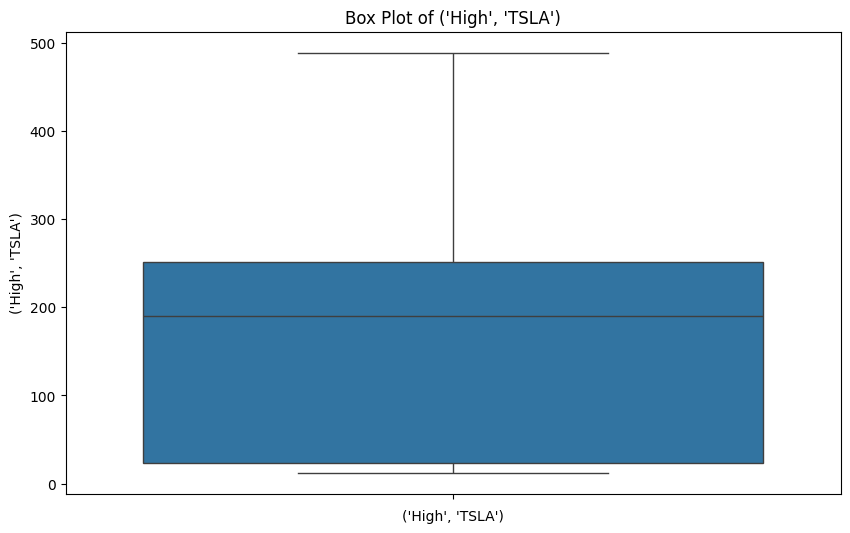

<Figure size 1000x600 with 0 Axes>

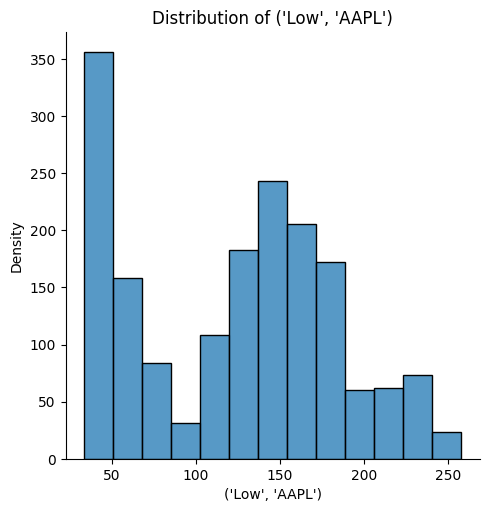

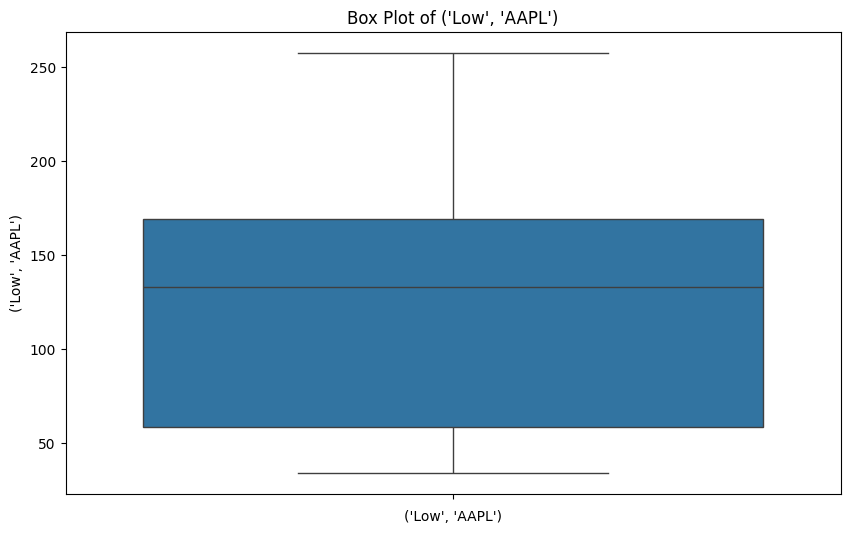

<Figure size 1000x600 with 0 Axes>

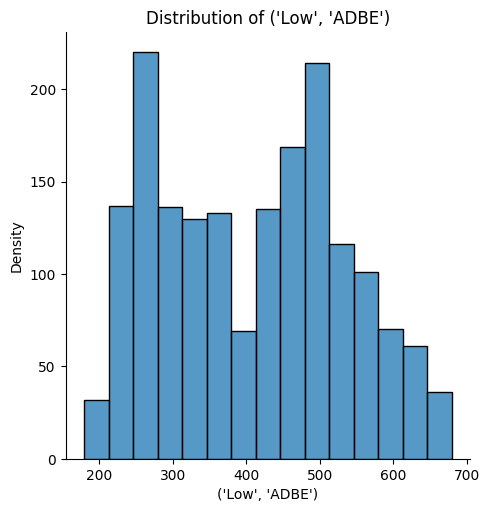

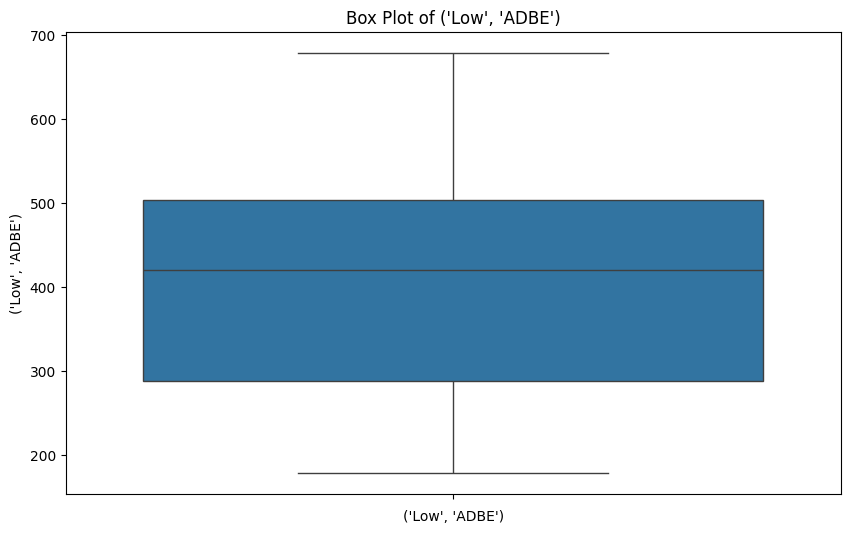

<Figure size 1000x600 with 0 Axes>

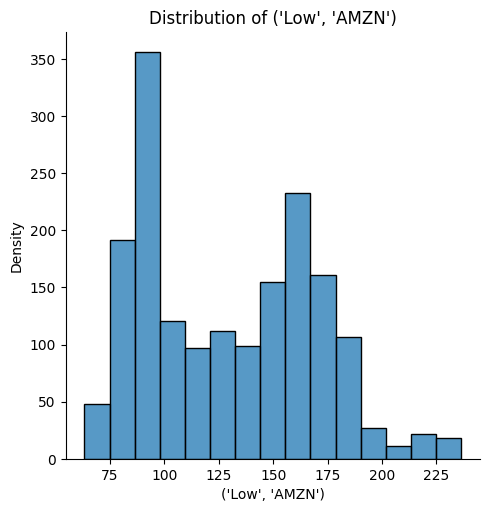

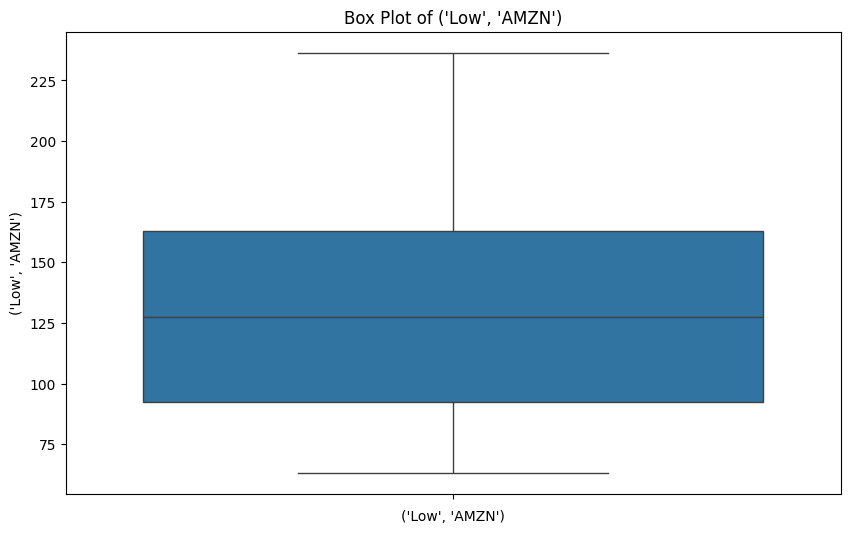

<Figure size 1000x600 with 0 Axes>

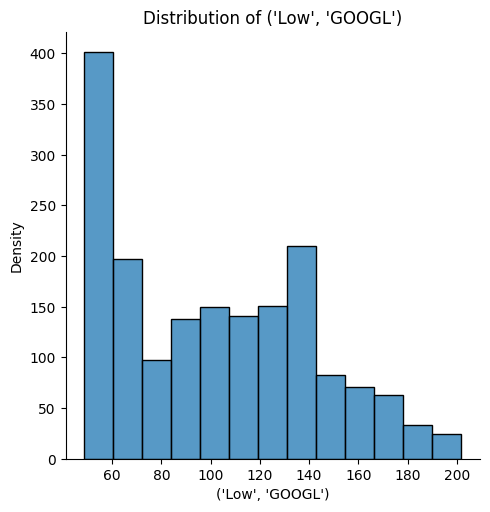

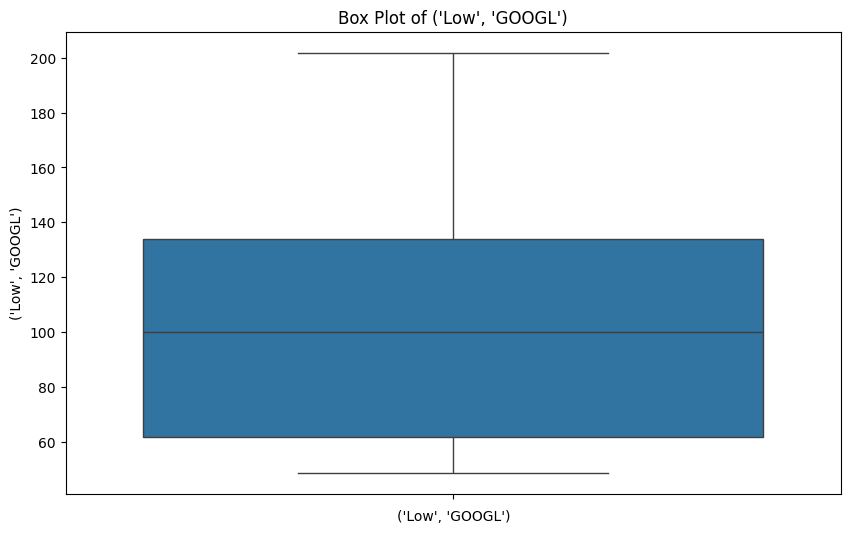

<Figure size 1000x600 with 0 Axes>

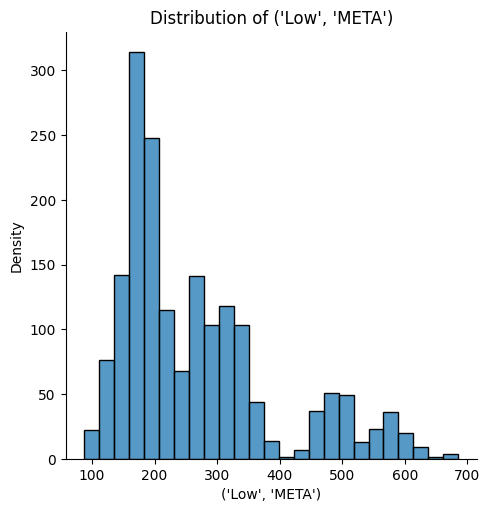

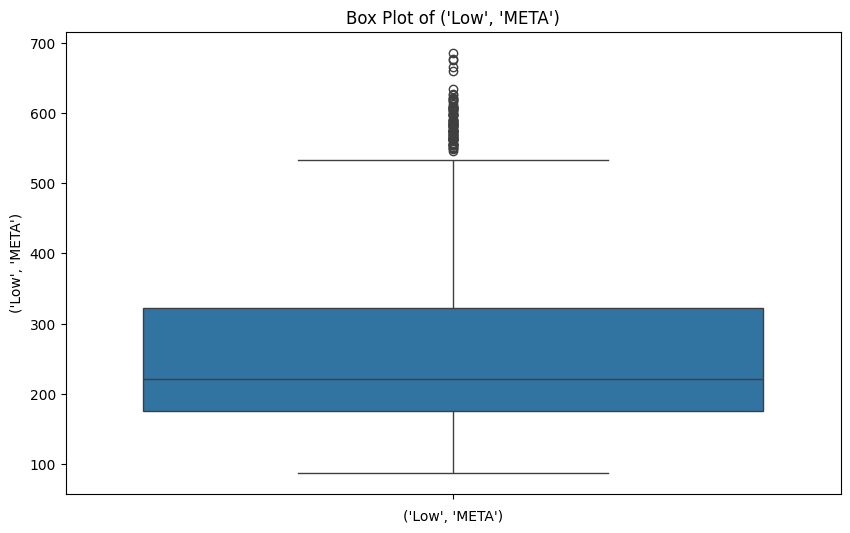

<Figure size 1000x600 with 0 Axes>

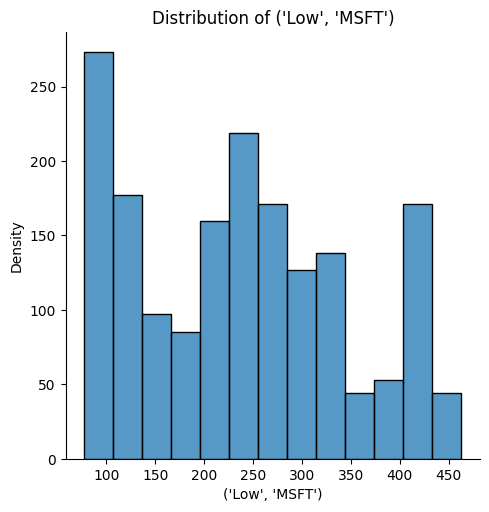

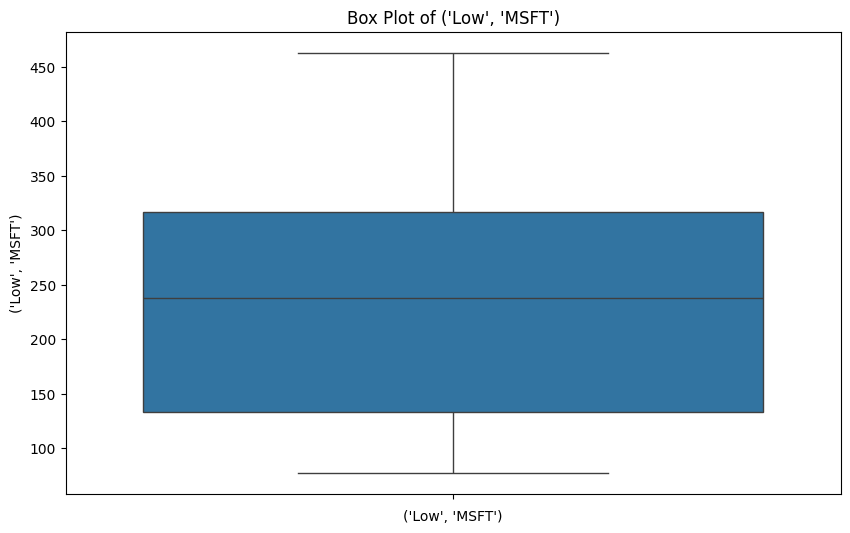

<Figure size 1000x600 with 0 Axes>

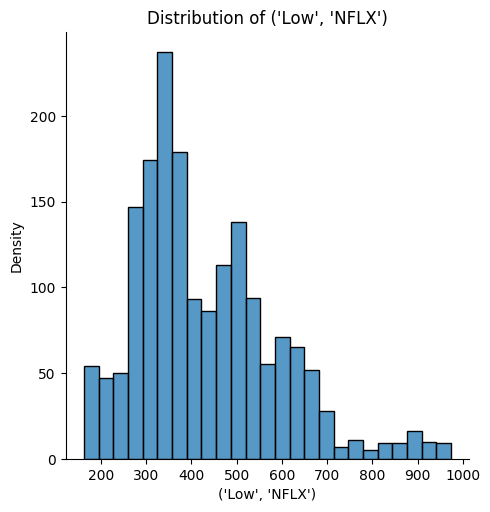

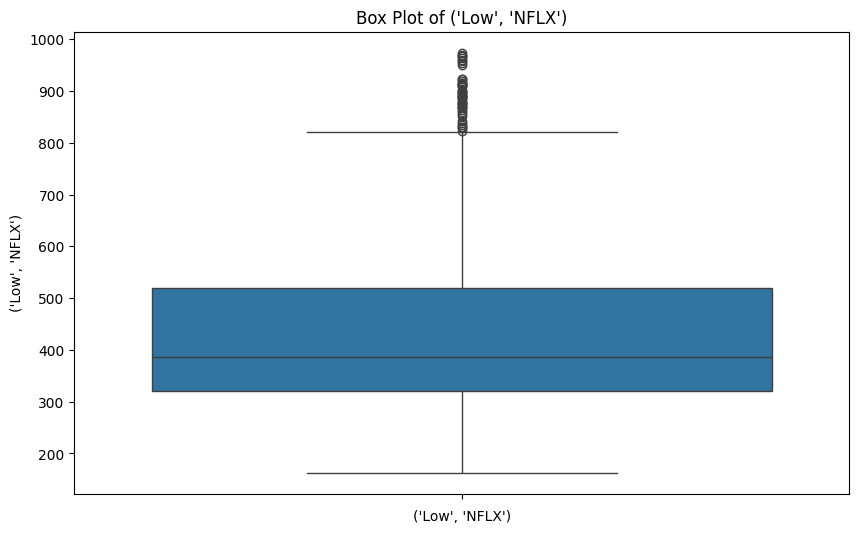

<Figure size 1000x600 with 0 Axes>

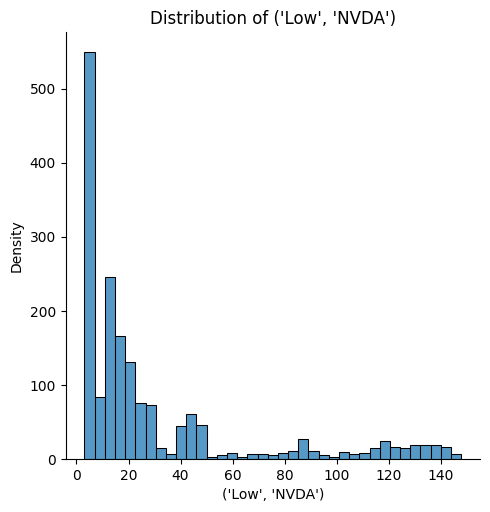

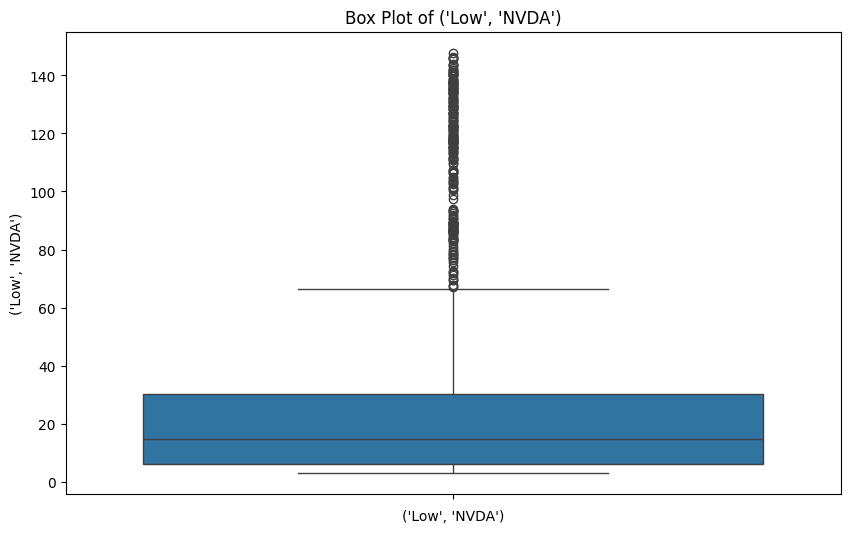

<Figure size 1000x600 with 0 Axes>

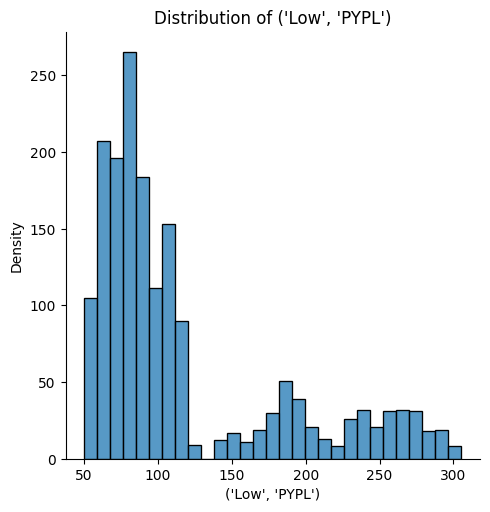

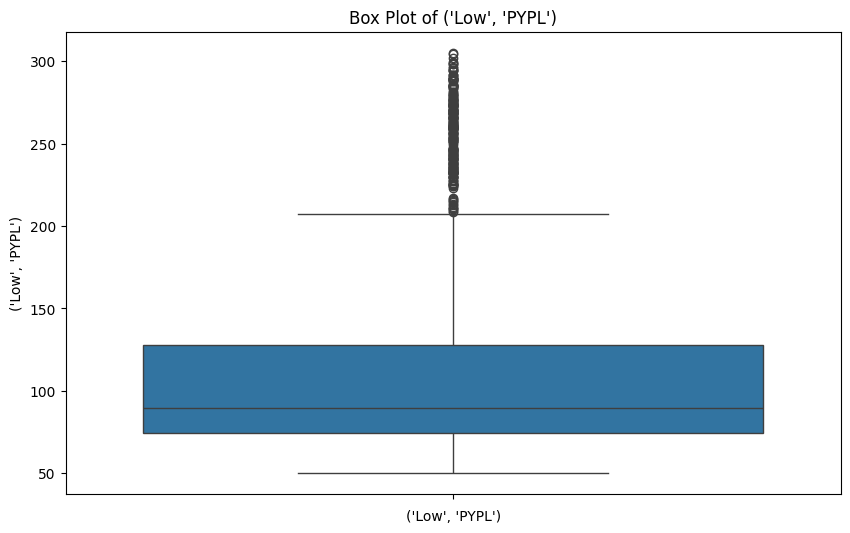

<Figure size 1000x600 with 0 Axes>

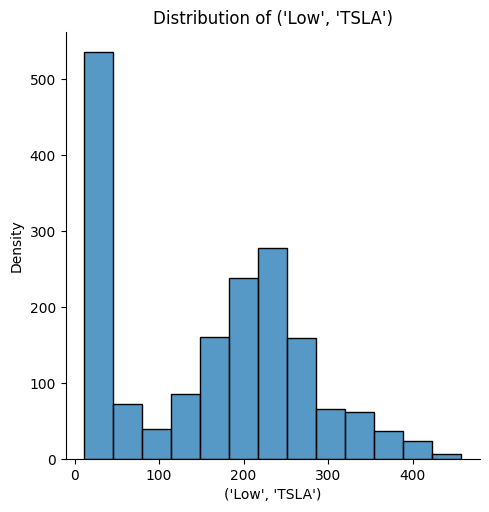

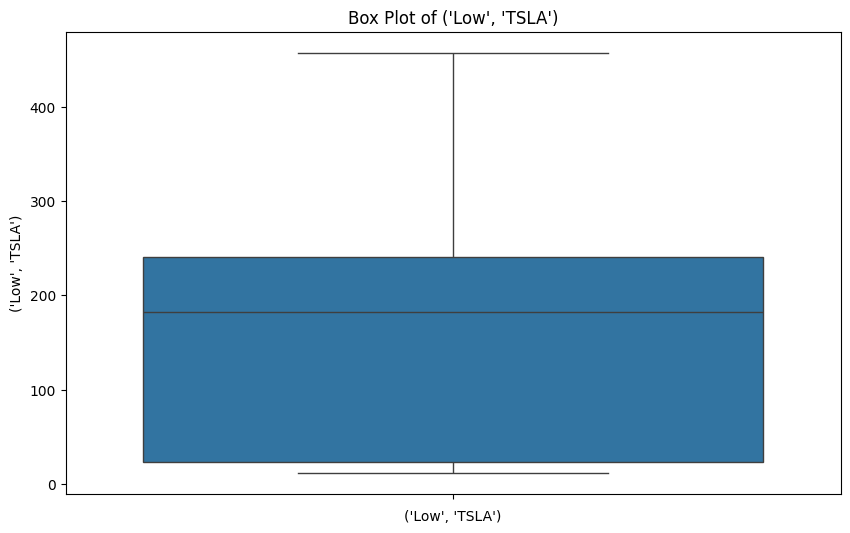

<Figure size 1000x600 with 0 Axes>

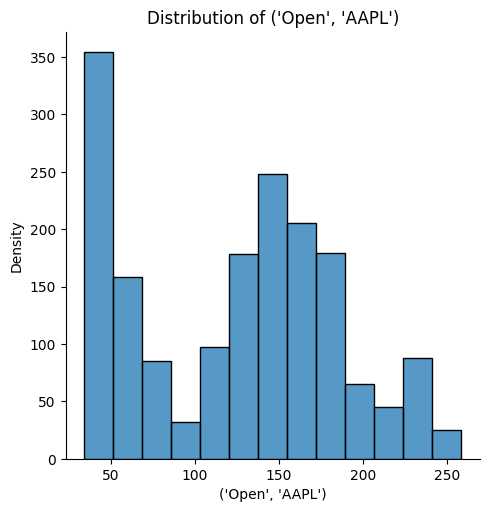

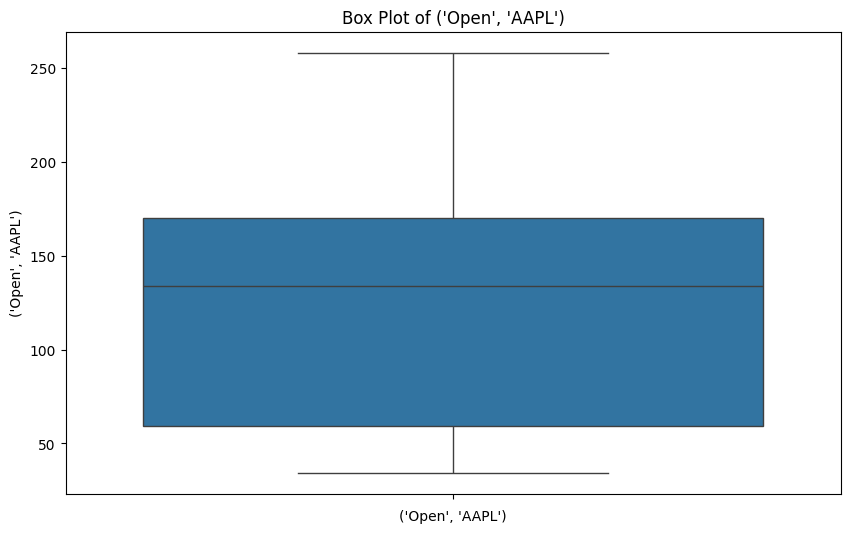

<Figure size 1000x600 with 0 Axes>

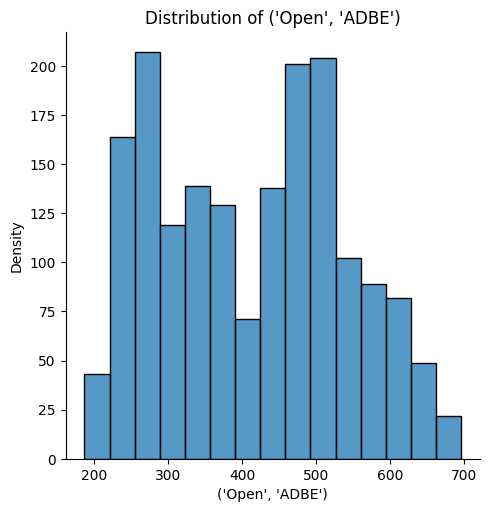

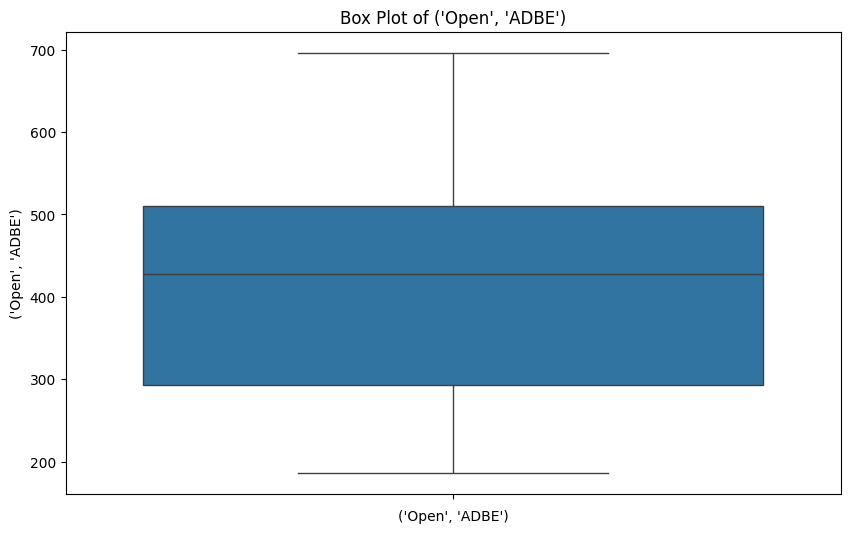

<Figure size 1000x600 with 0 Axes>

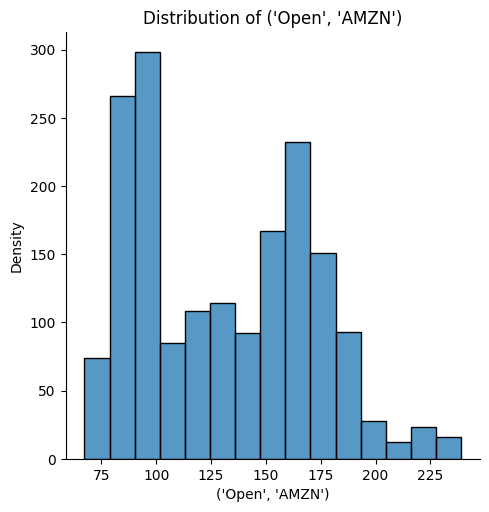

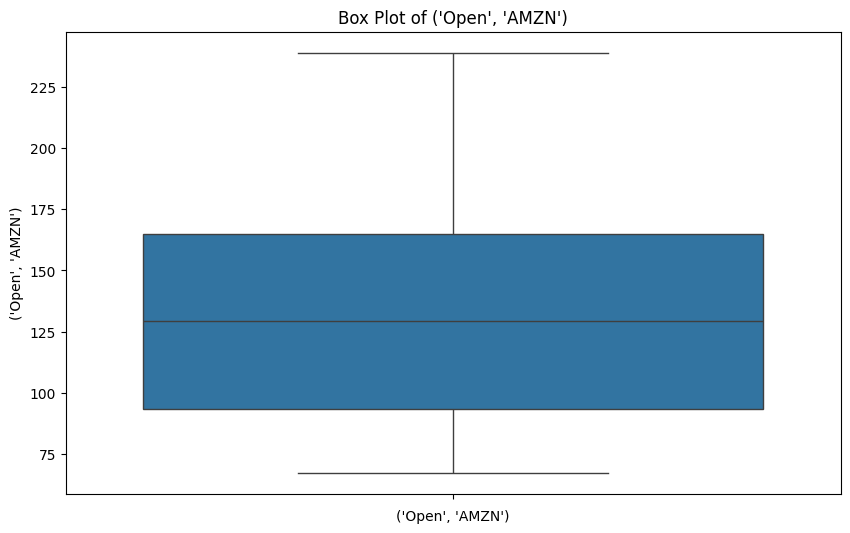

<Figure size 1000x600 with 0 Axes>

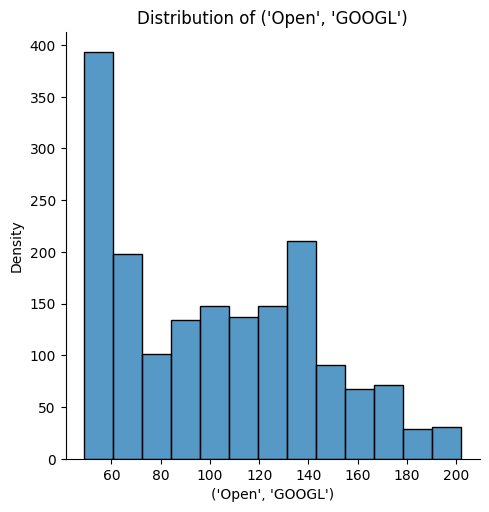

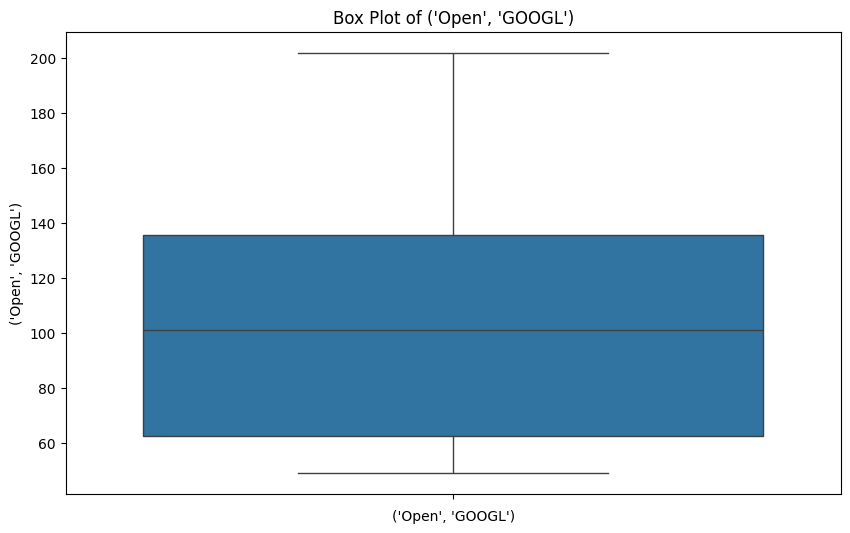

<Figure size 1000x600 with 0 Axes>

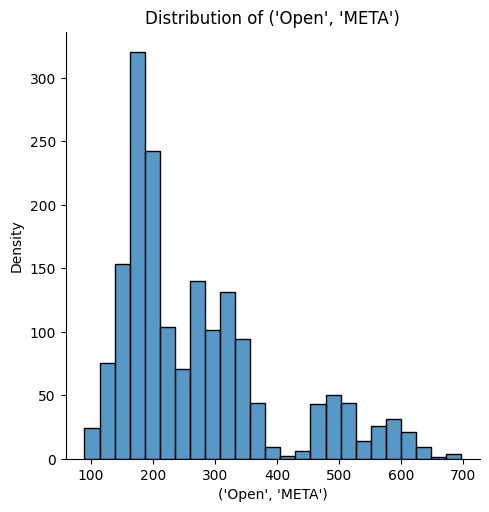

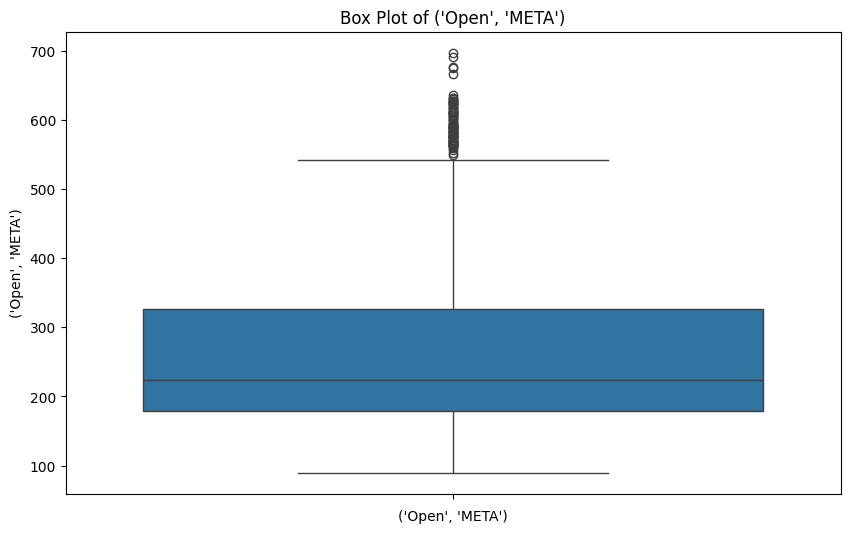

<Figure size 1000x600 with 0 Axes>

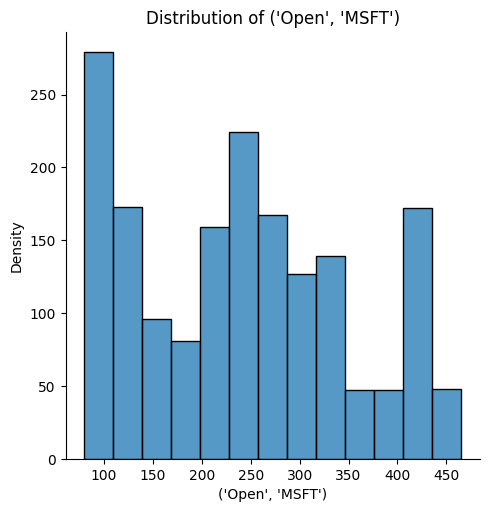

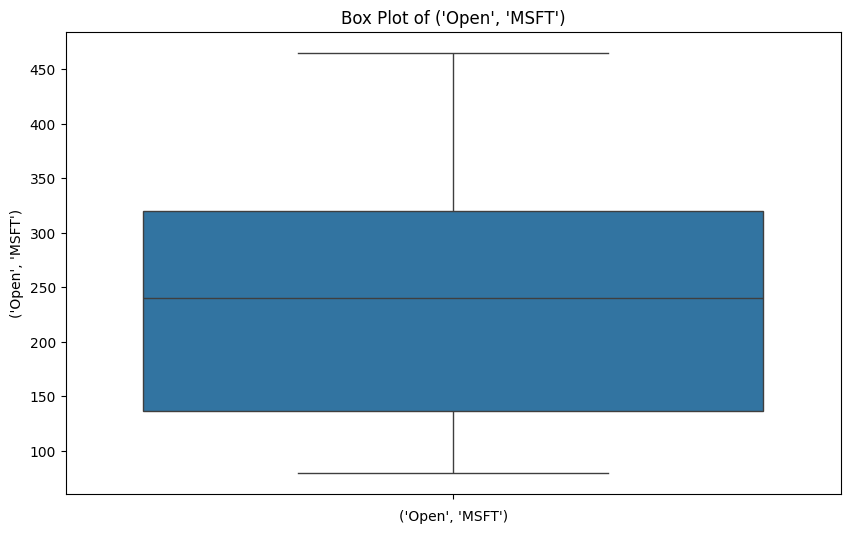

<Figure size 1000x600 with 0 Axes>

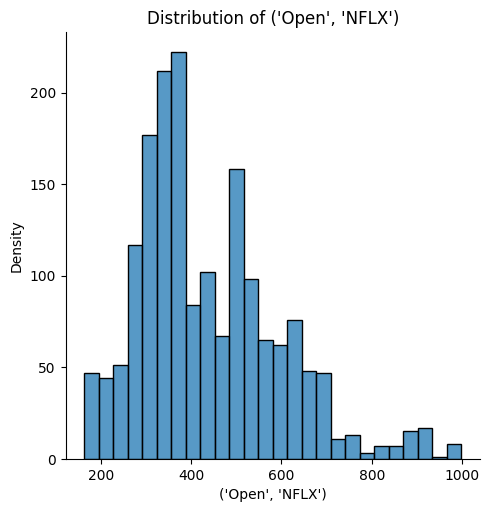

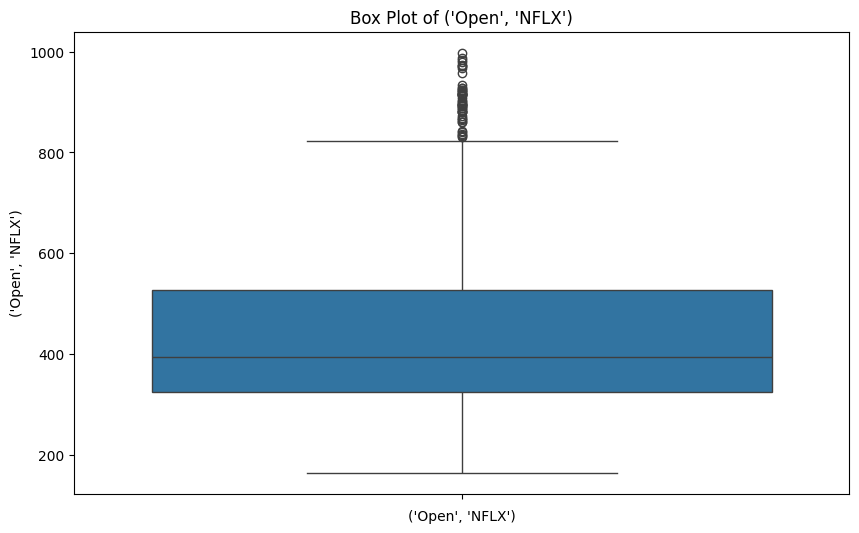

<Figure size 1000x600 with 0 Axes>

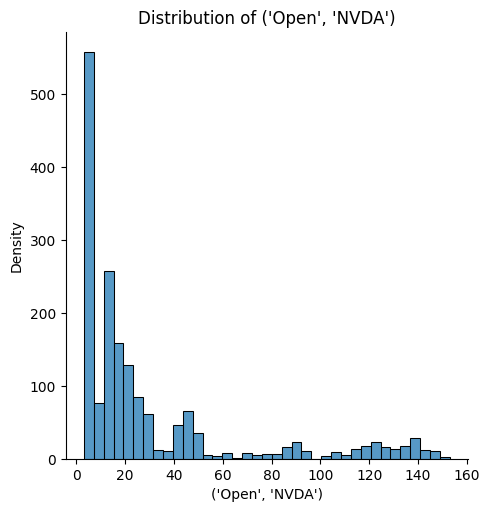

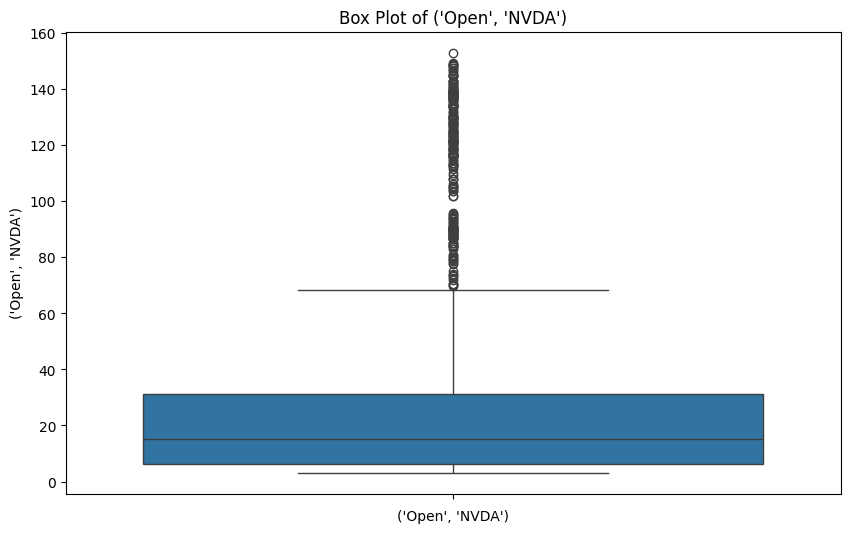

<Figure size 1000x600 with 0 Axes>

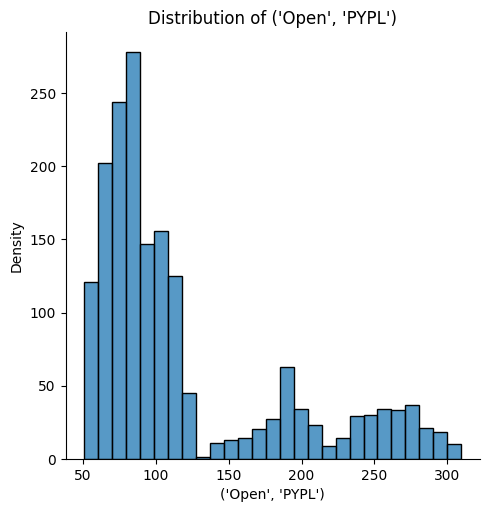

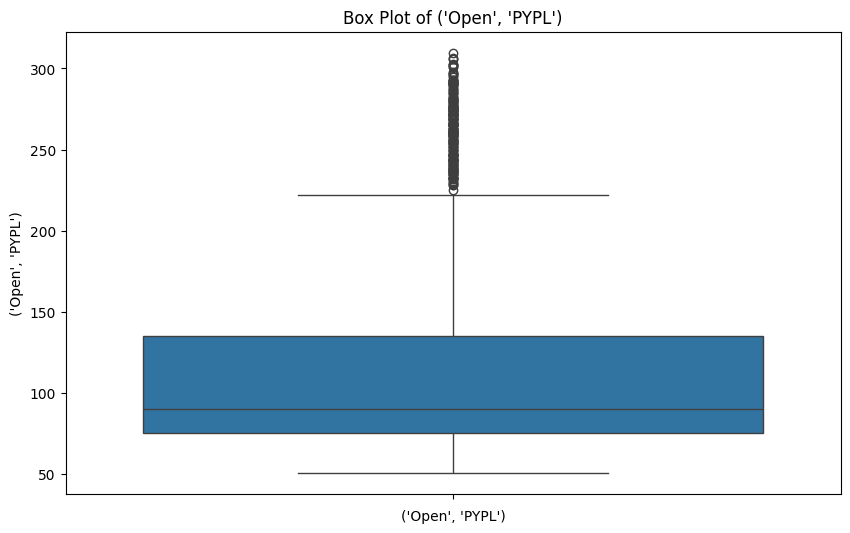

<Figure size 1000x600 with 0 Axes>

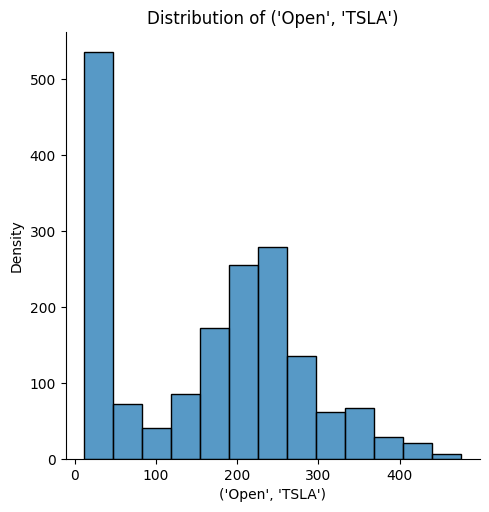

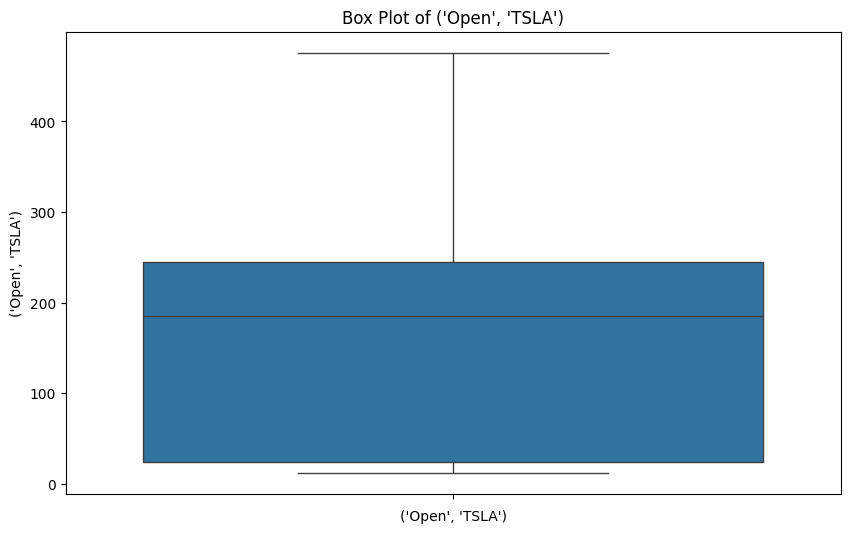

<Figure size 1000x600 with 0 Axes>

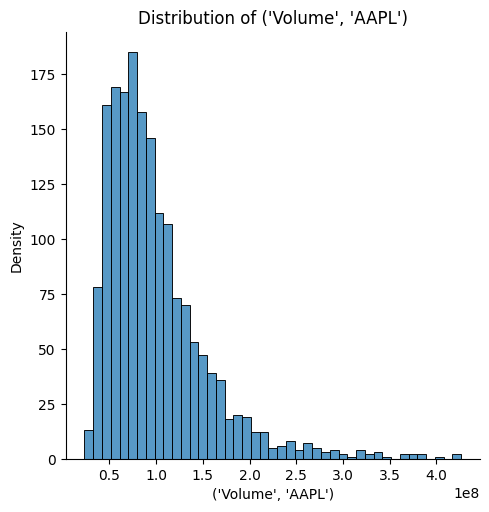

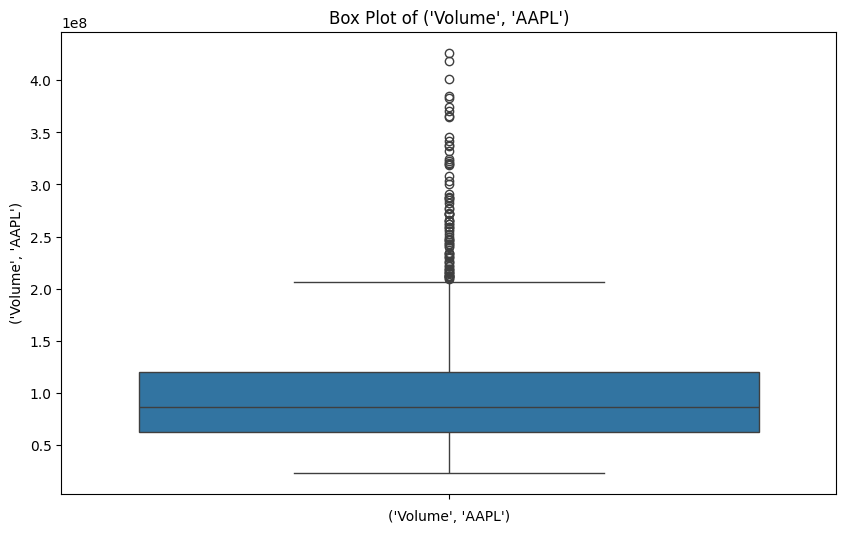

<Figure size 1000x600 with 0 Axes>

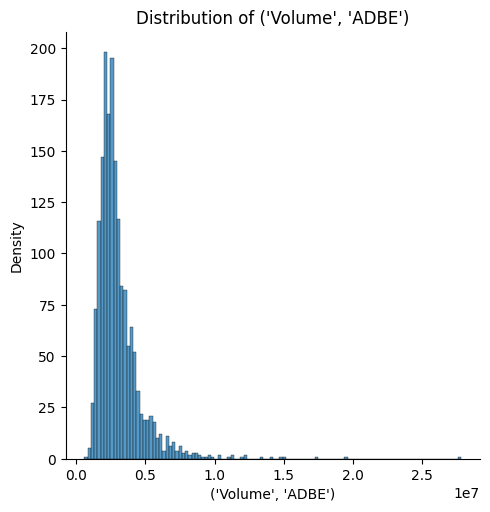

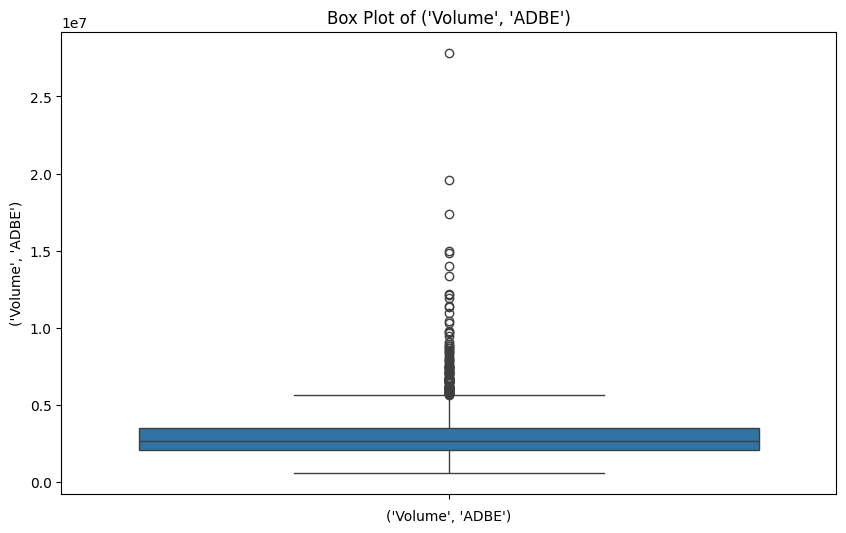

<Figure size 1000x600 with 0 Axes>

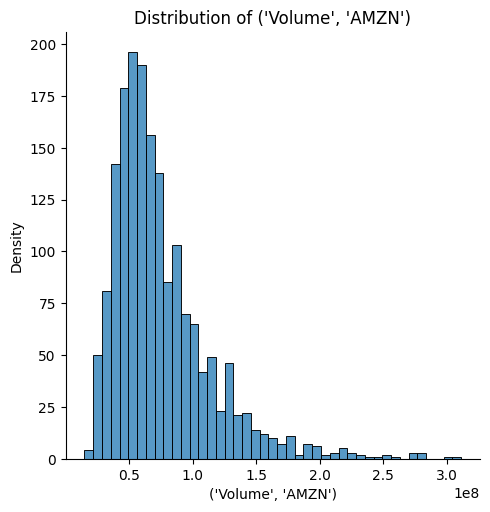

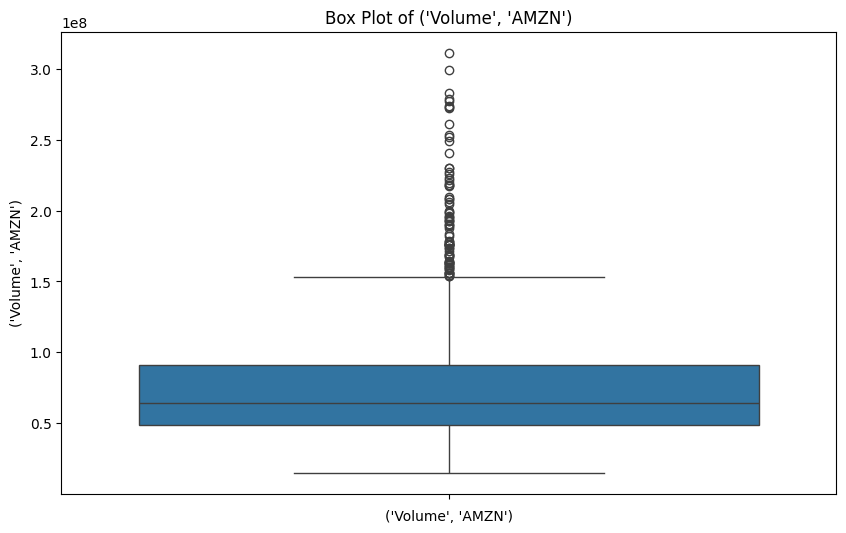

<Figure size 1000x600 with 0 Axes>

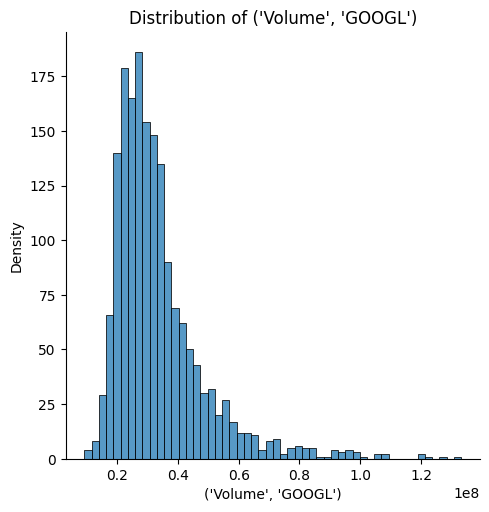

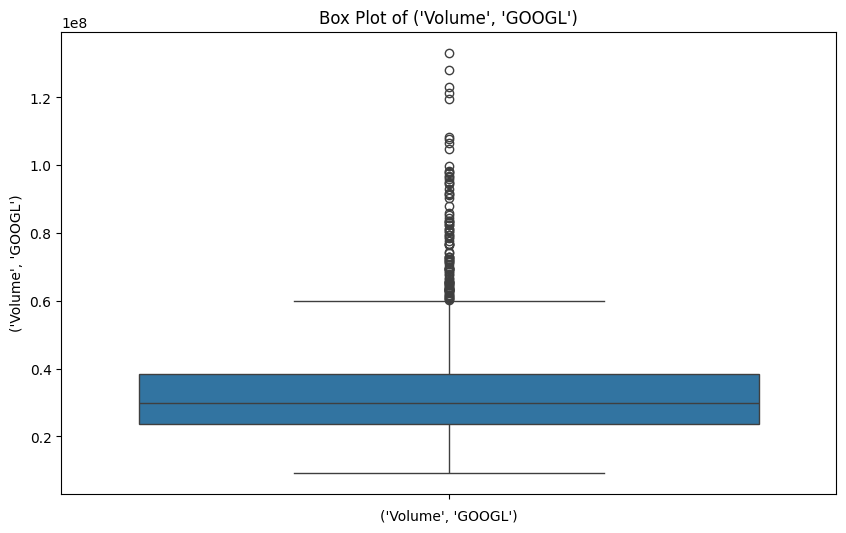

<Figure size 1000x600 with 0 Axes>

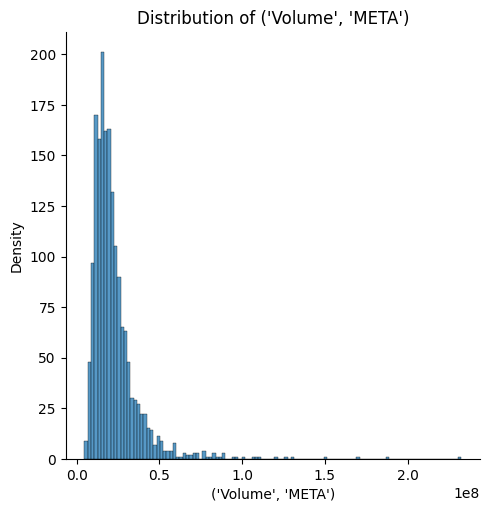

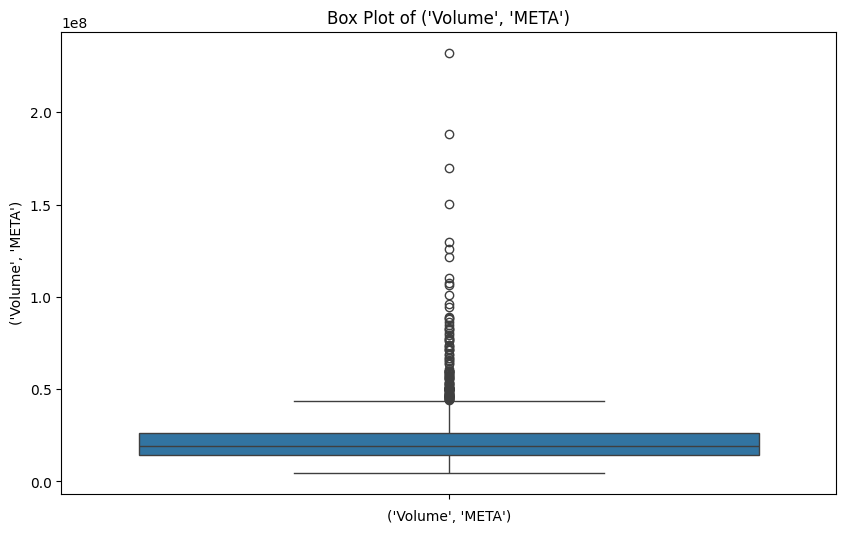

<Figure size 1000x600 with 0 Axes>

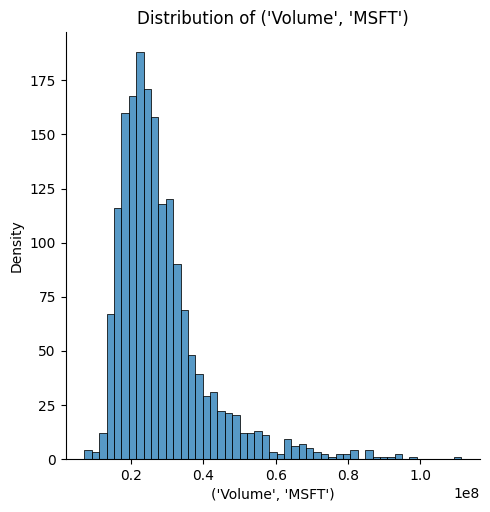

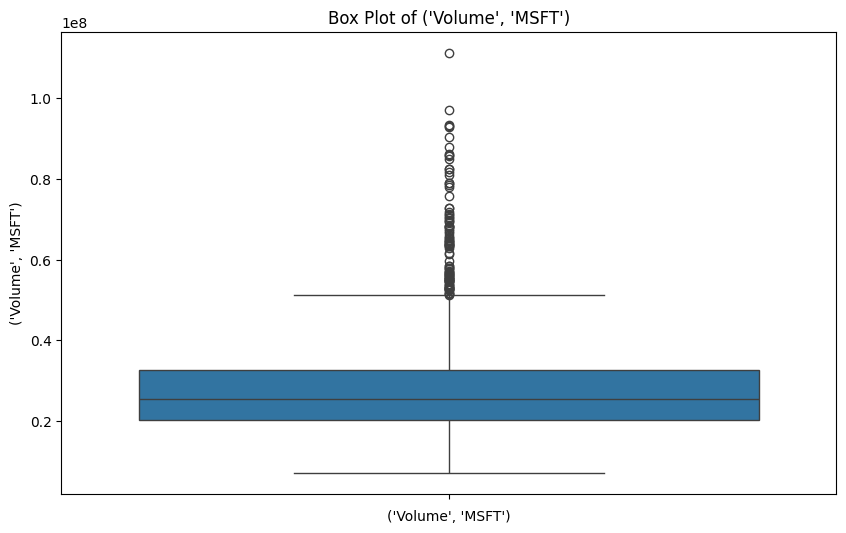

<Figure size 1000x600 with 0 Axes>

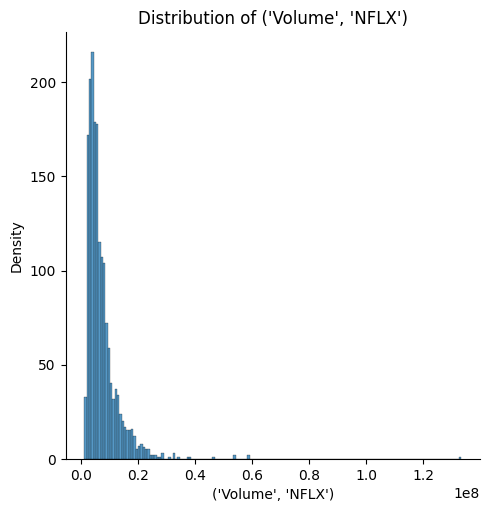

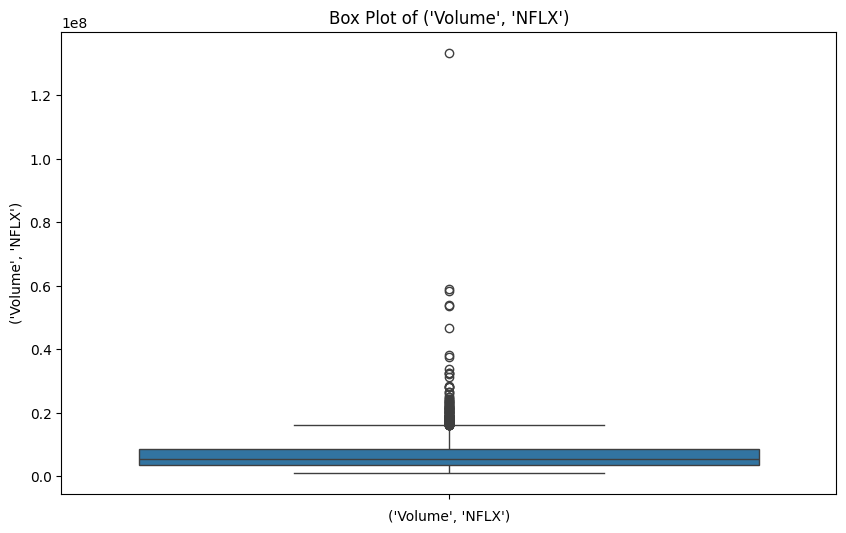

<Figure size 1000x600 with 0 Axes>

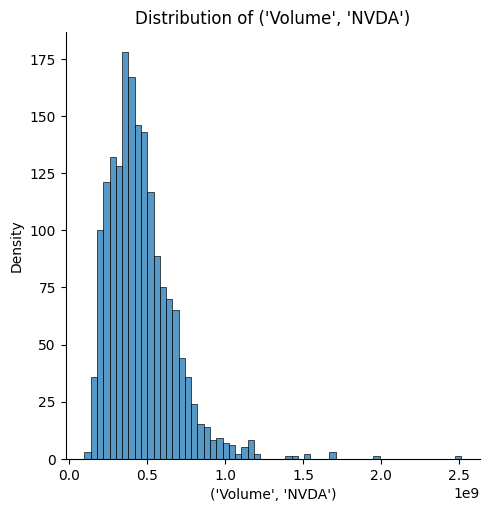

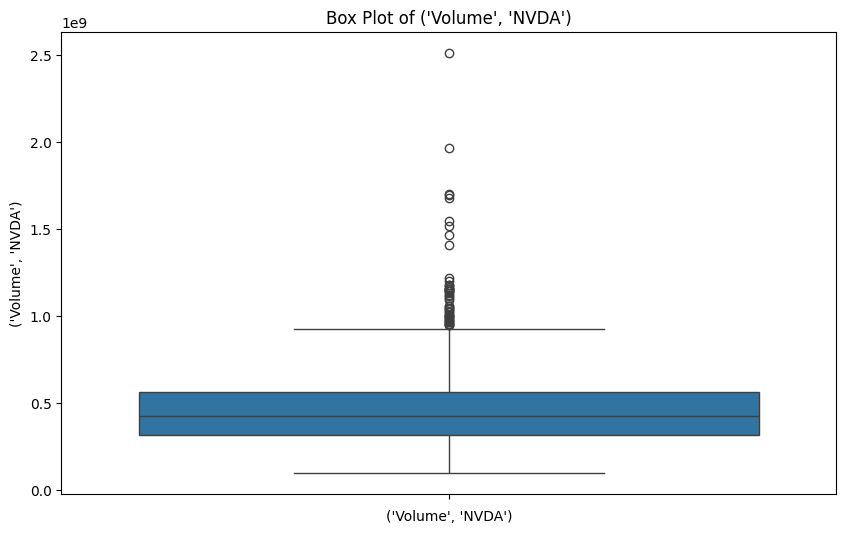

<Figure size 1000x600 with 0 Axes>

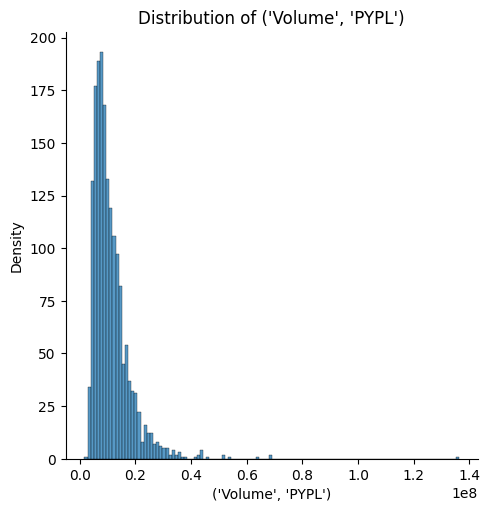

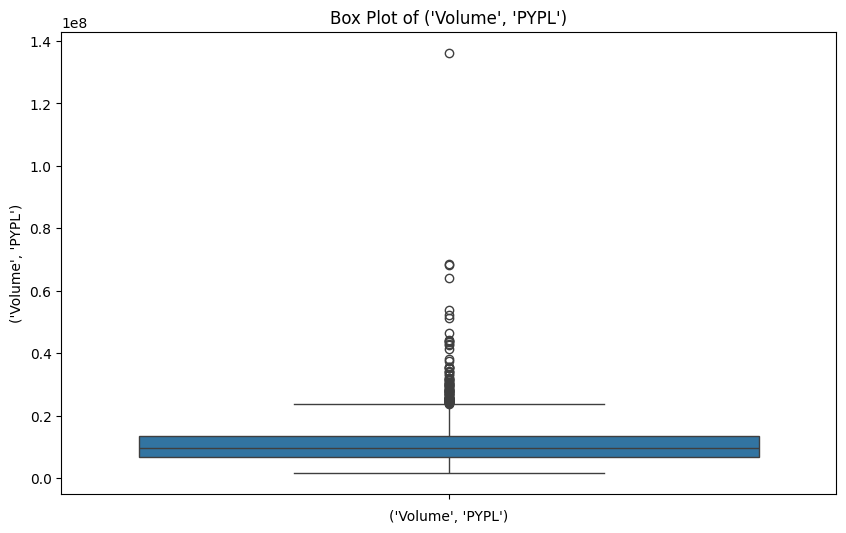

<Figure size 1000x600 with 0 Axes>

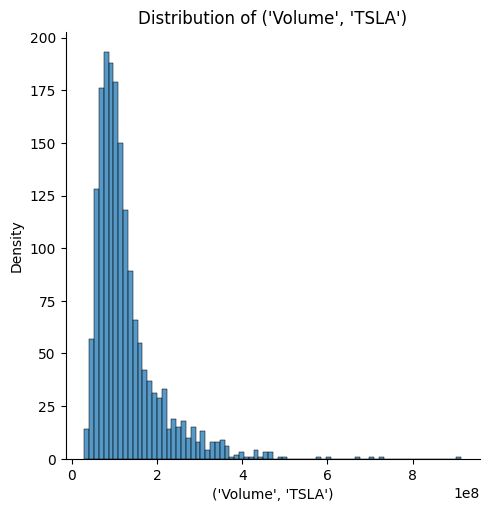

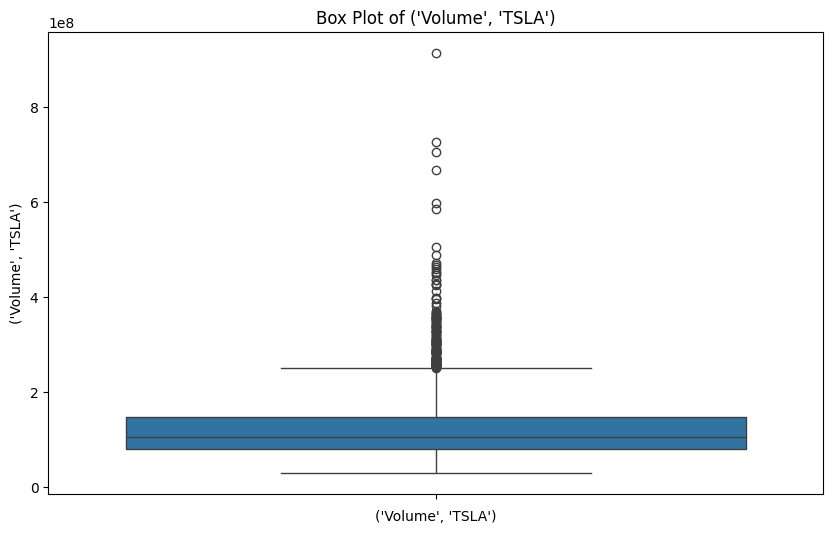

In [ ]:
# prompt: generate univariate plots for data analysis

# univariate analysis
def univariate_analysis(df):
    # numerical features
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    for col in num_cols:
        plt.figure(figsize=(10, 6))
        sns.displot(df[col])
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.boxplot(df[col])
        plt.title(f"Box Plot of {col}")
        plt.xlabel(col)
        plt.show()


    # categorical features (if any)
    cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
    for col in cat_cols:
        plt.figure(figsize=(10, 6))
        df[col].value_counts().plot(kind='bar')
        plt.title(f"Bar Plot of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

univariate_analysis(df)

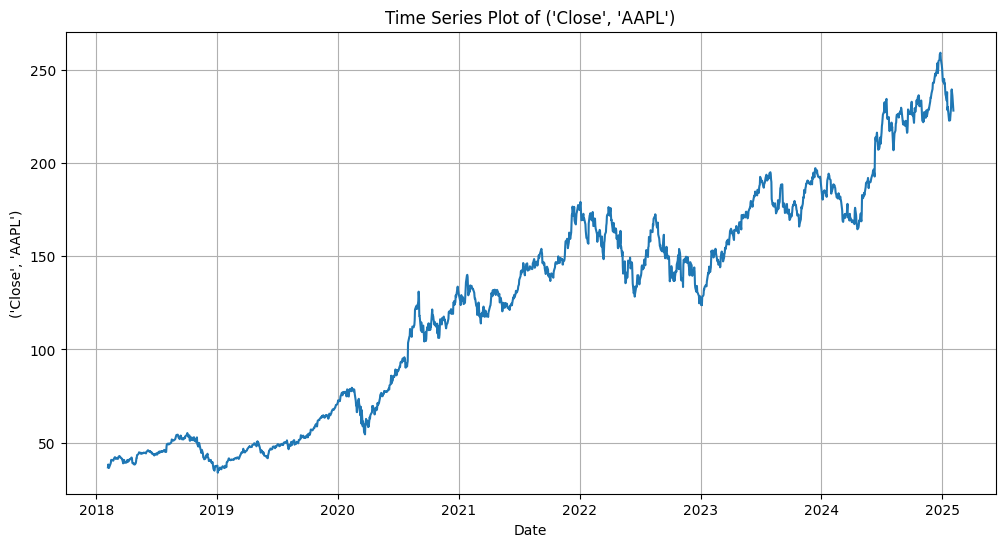

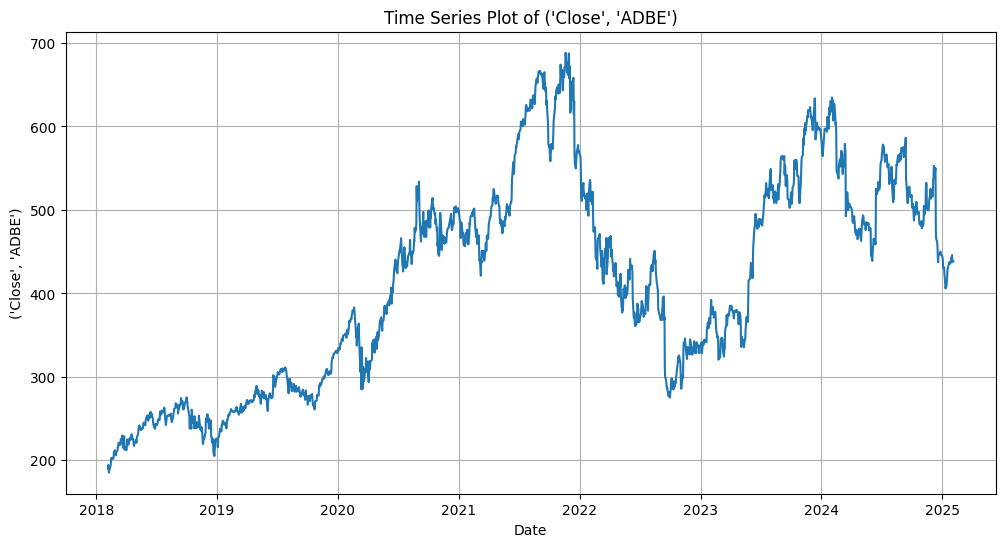

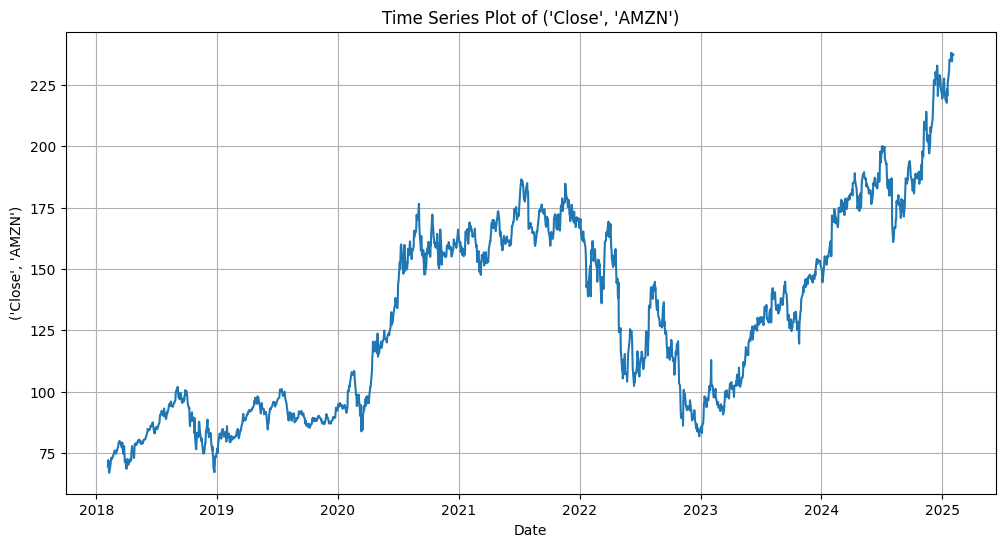

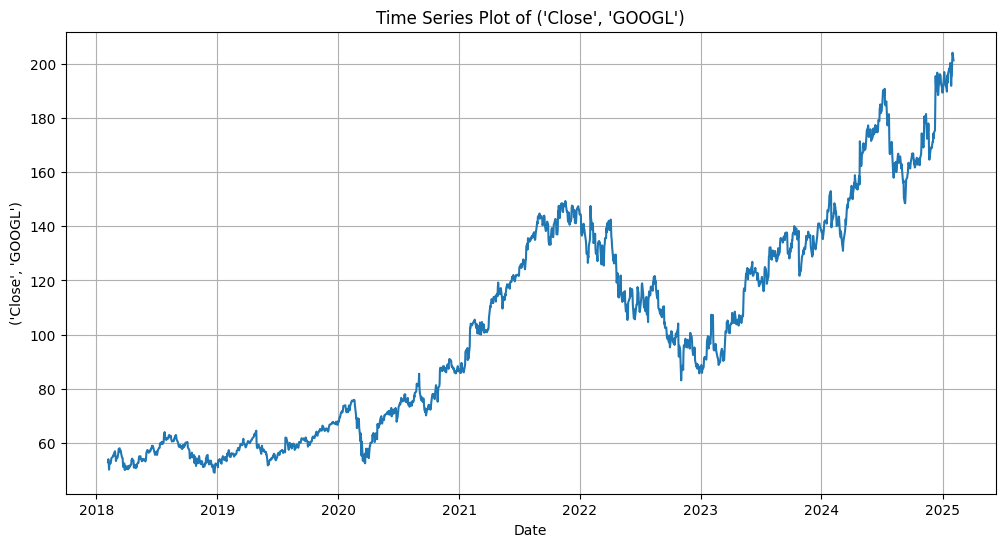

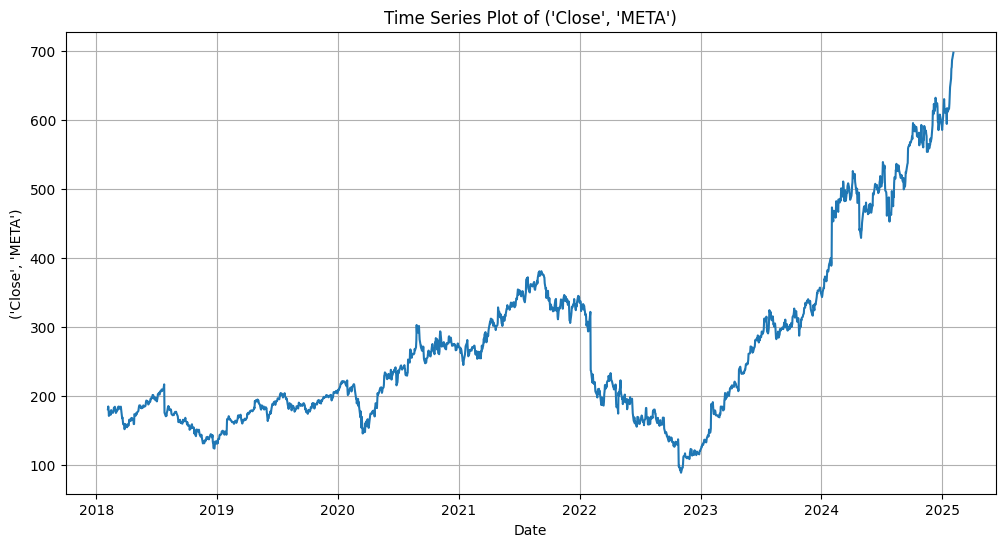

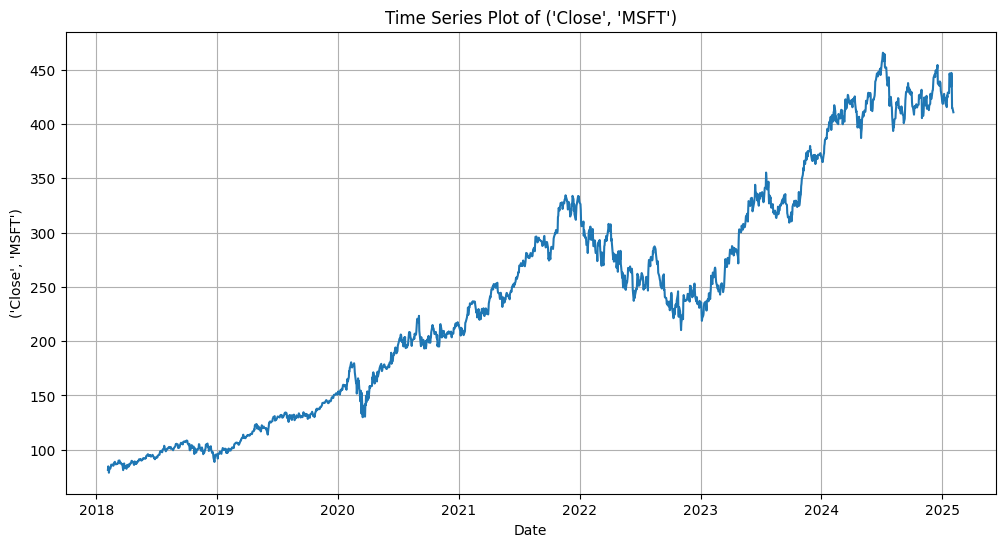

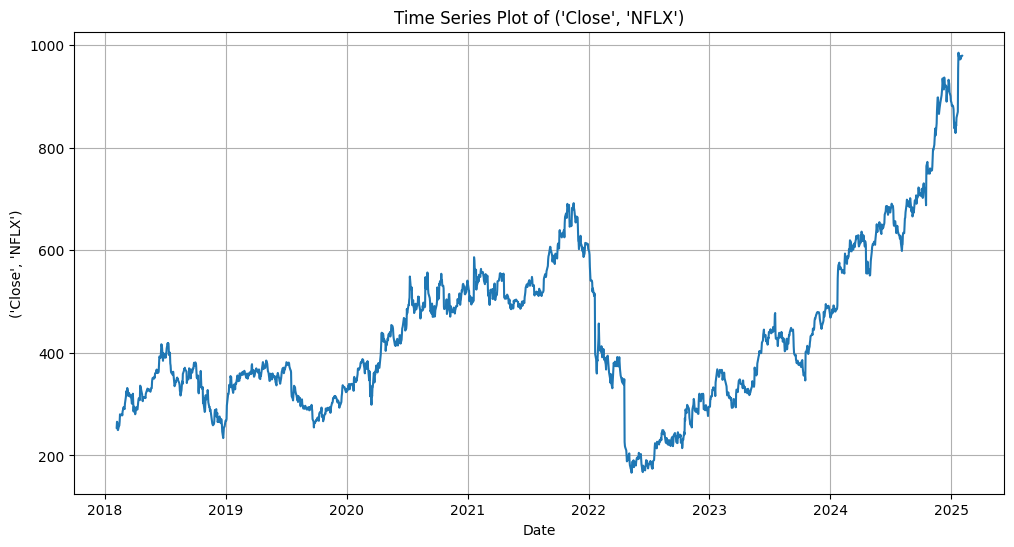

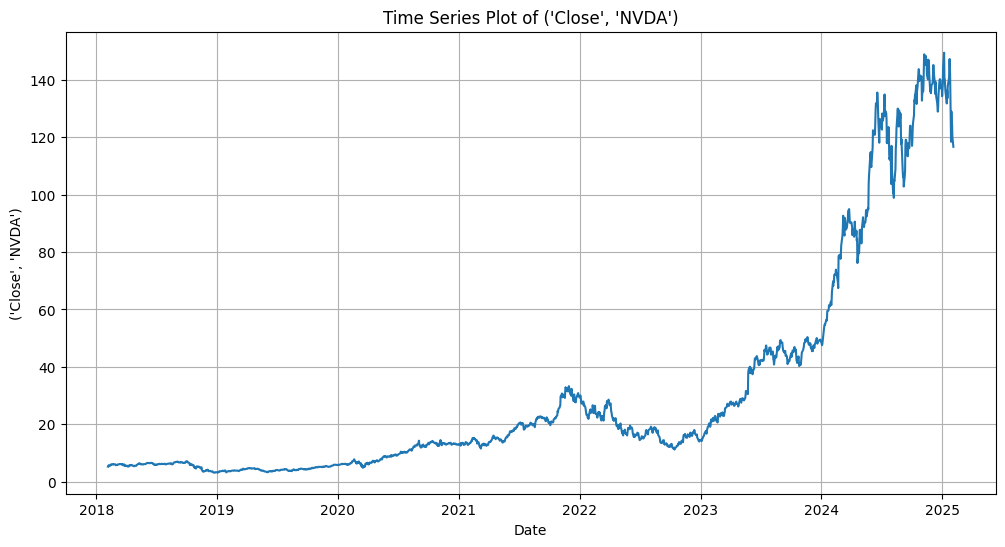

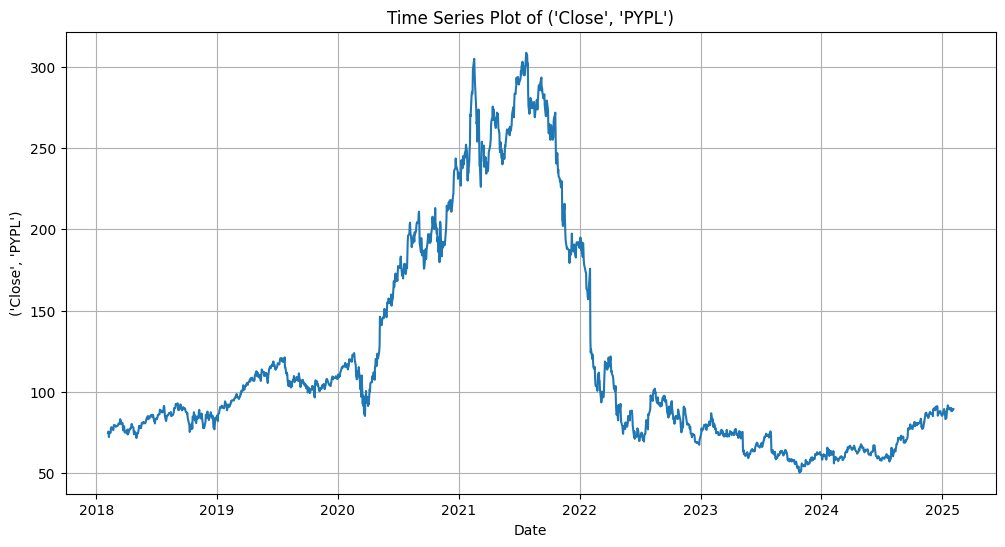

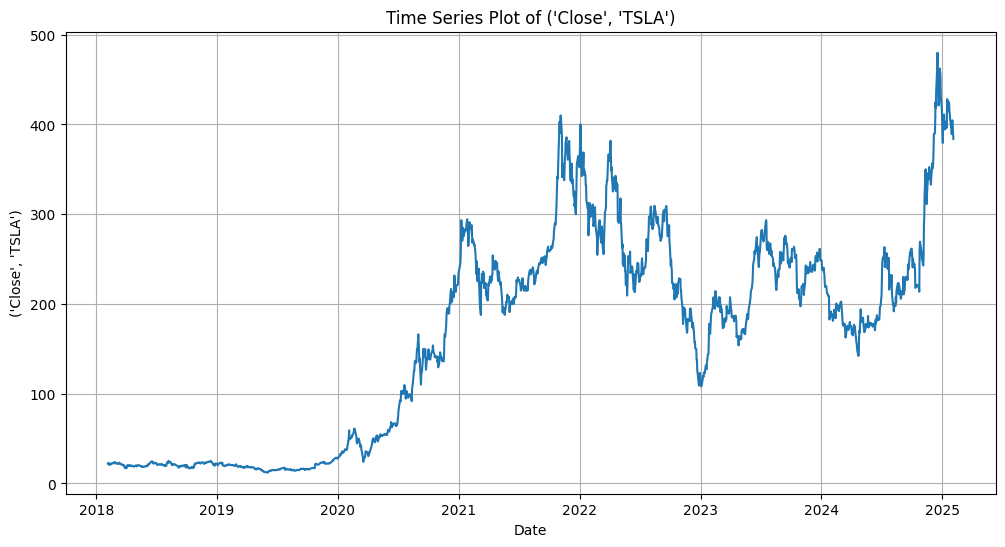

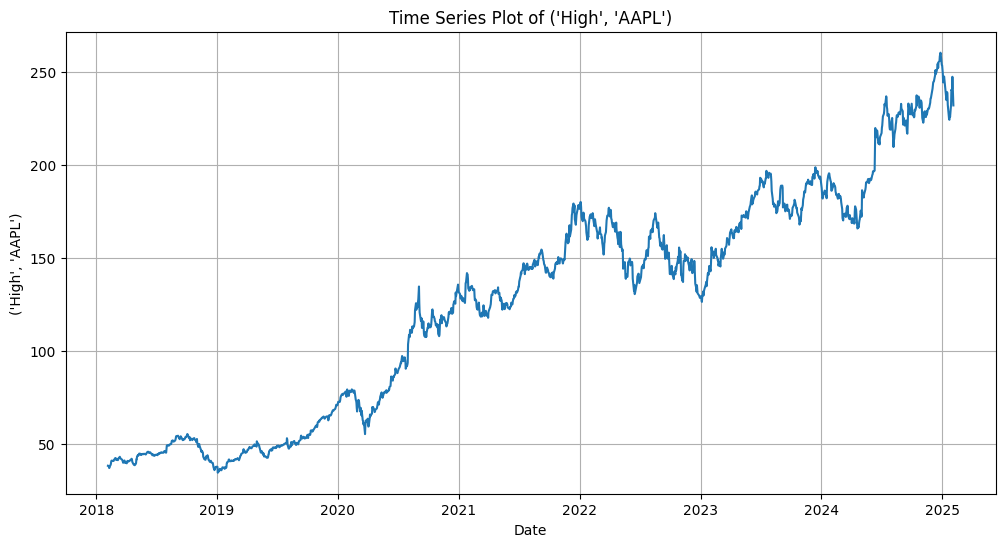

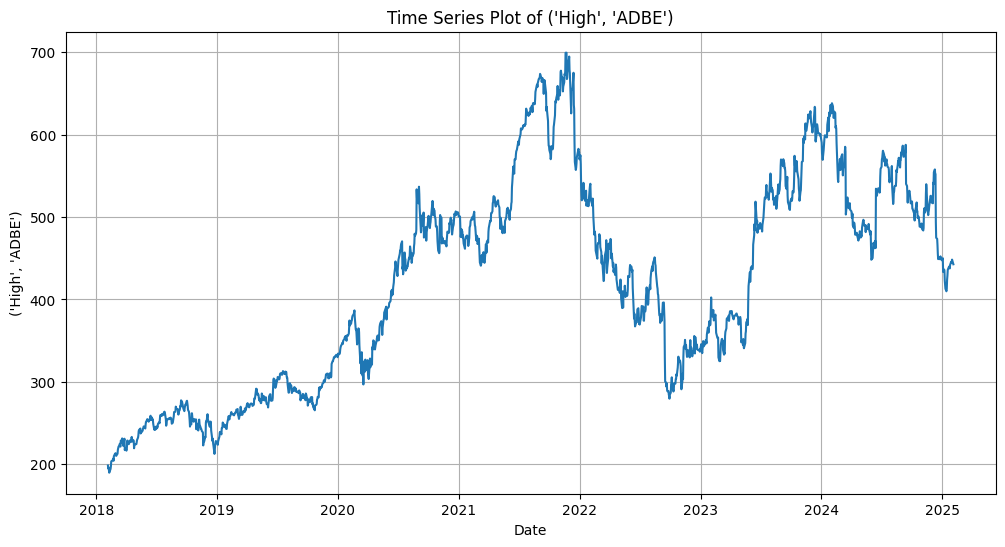

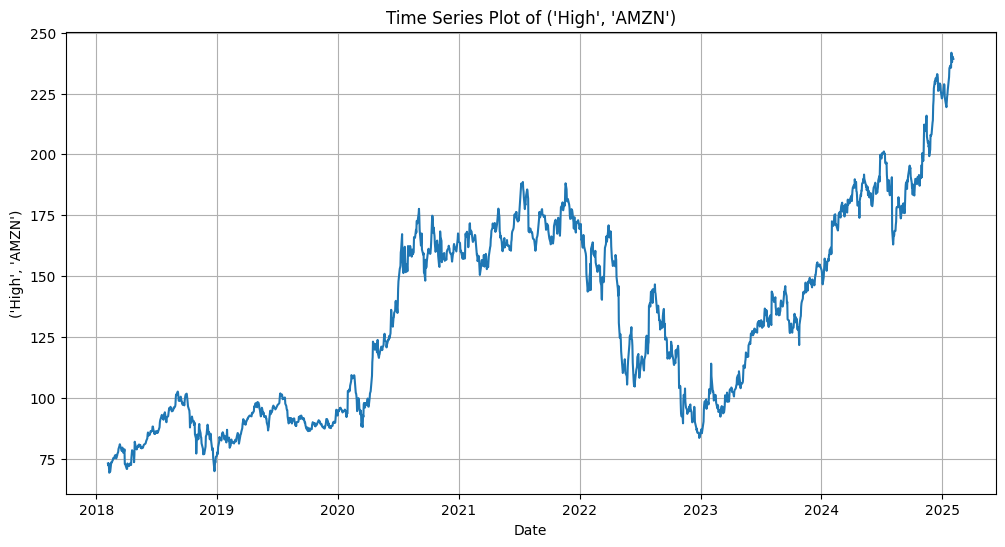

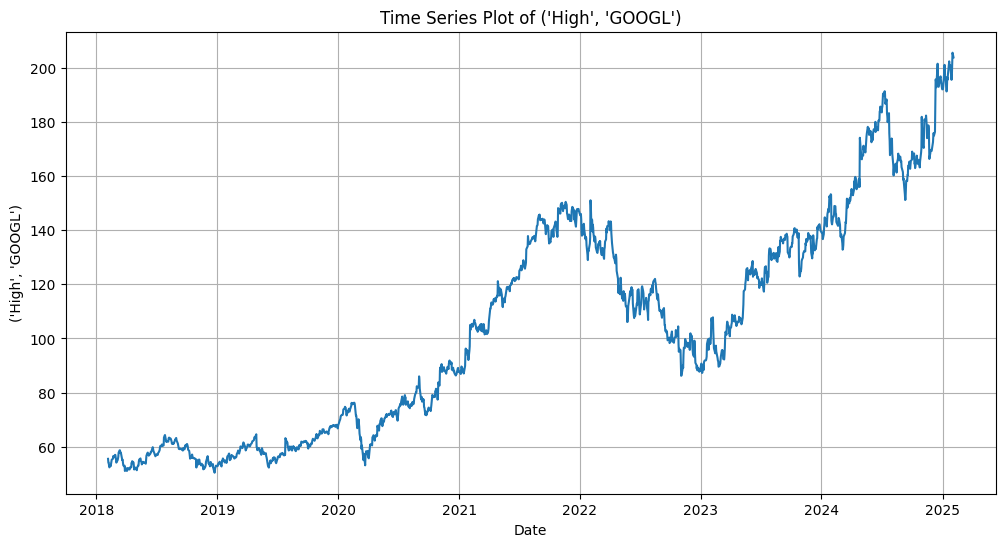

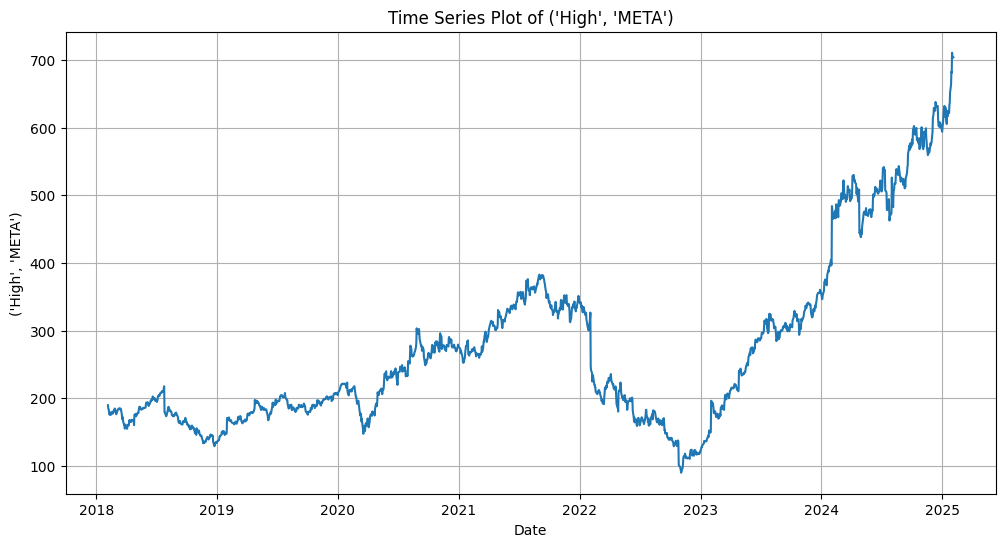

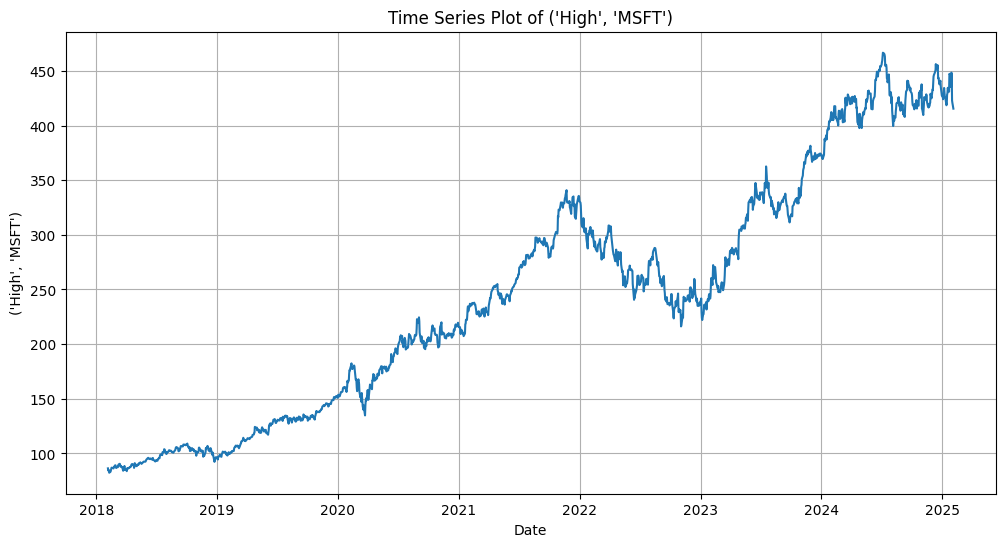

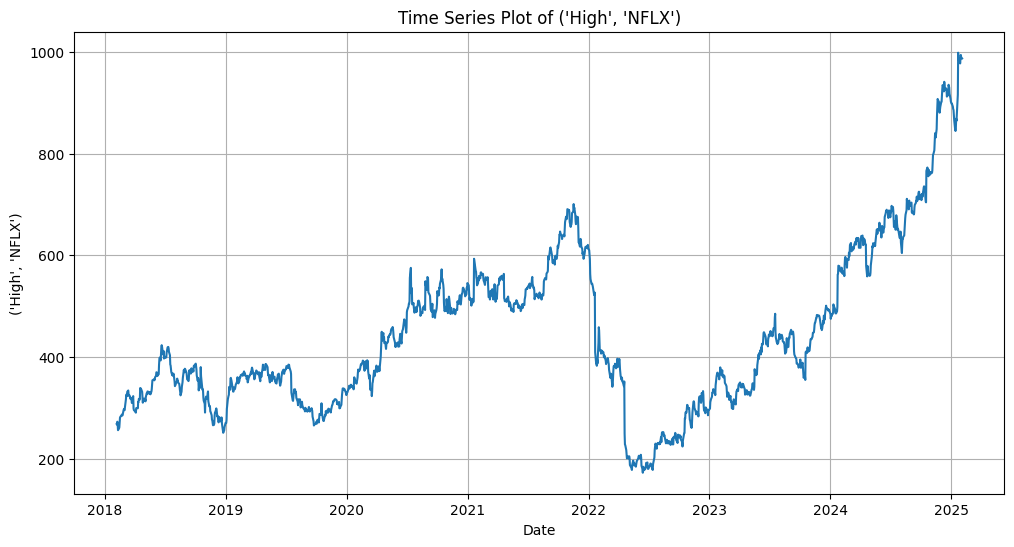

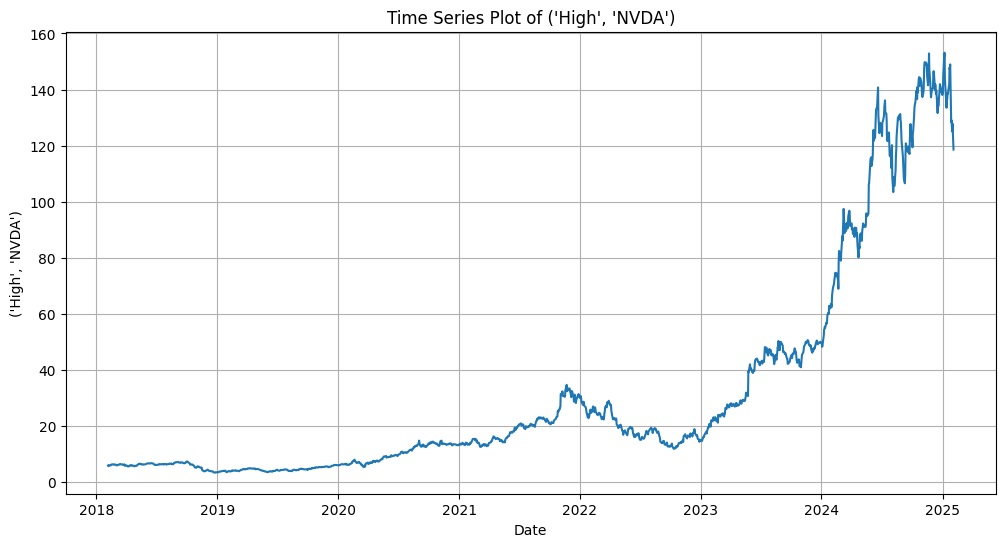

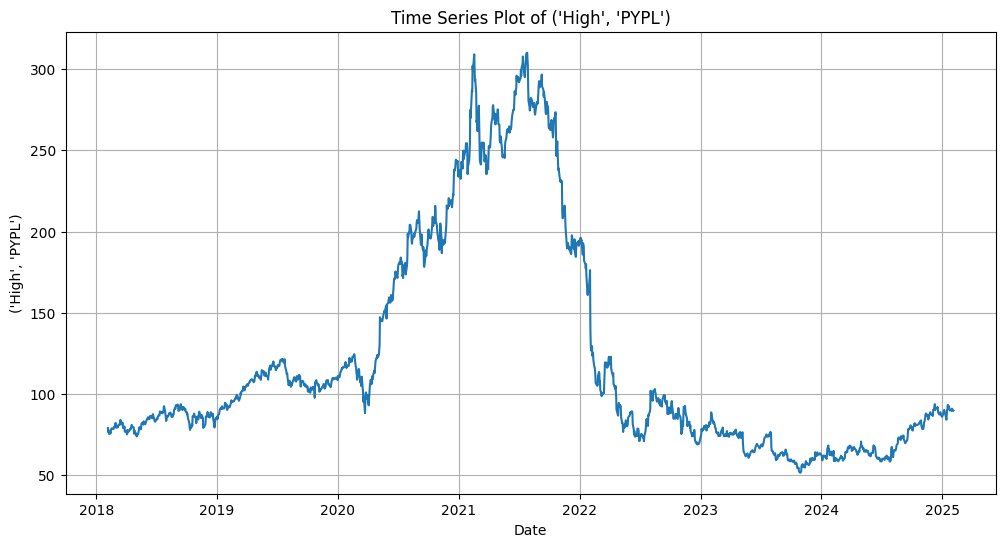

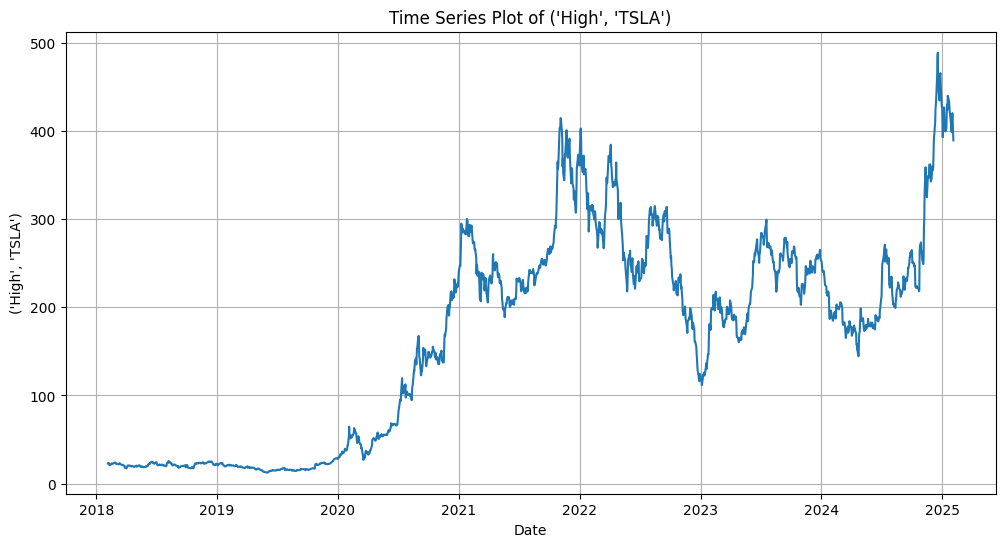

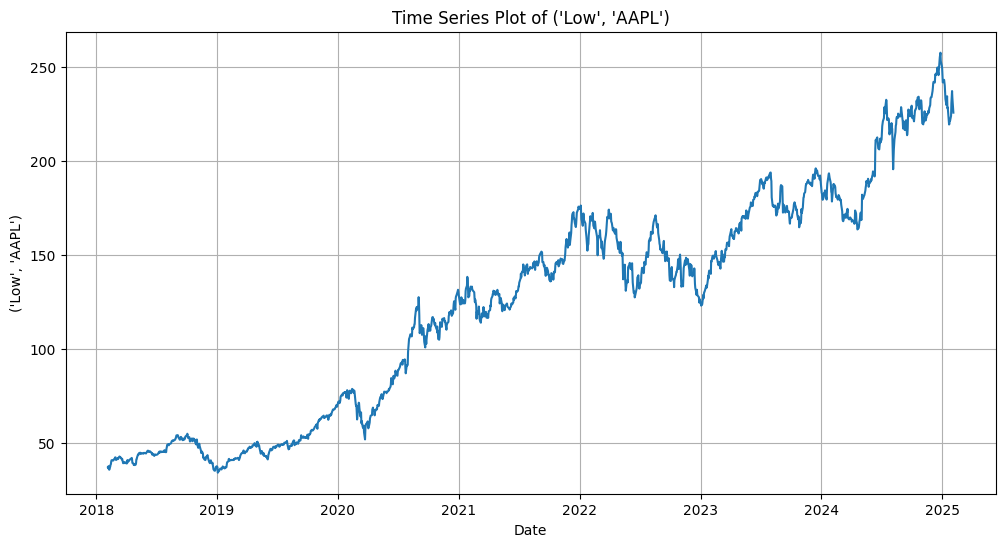

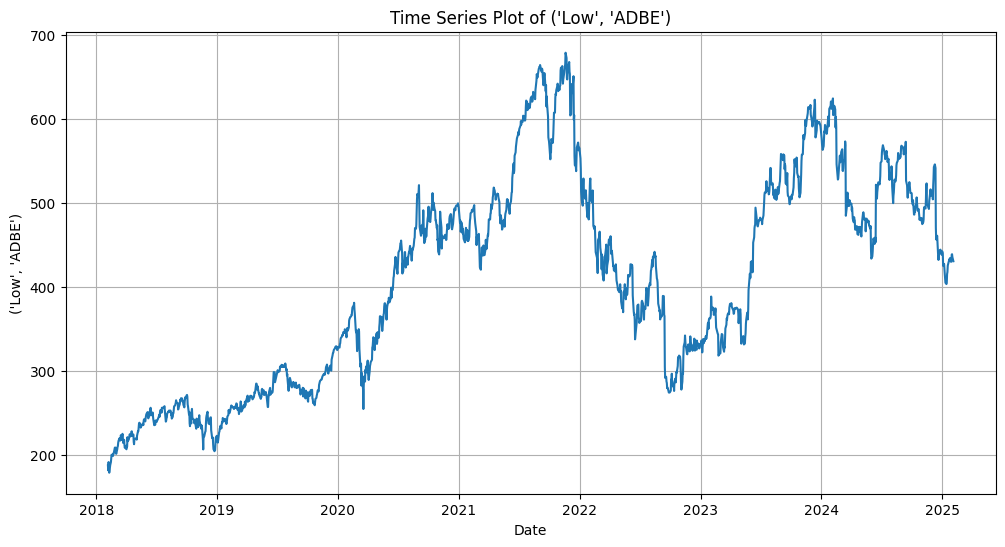

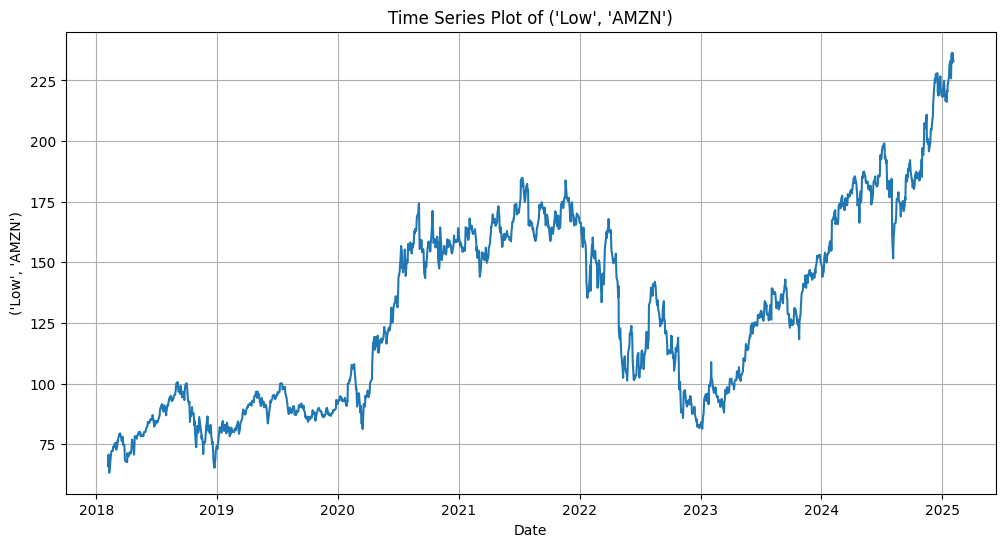

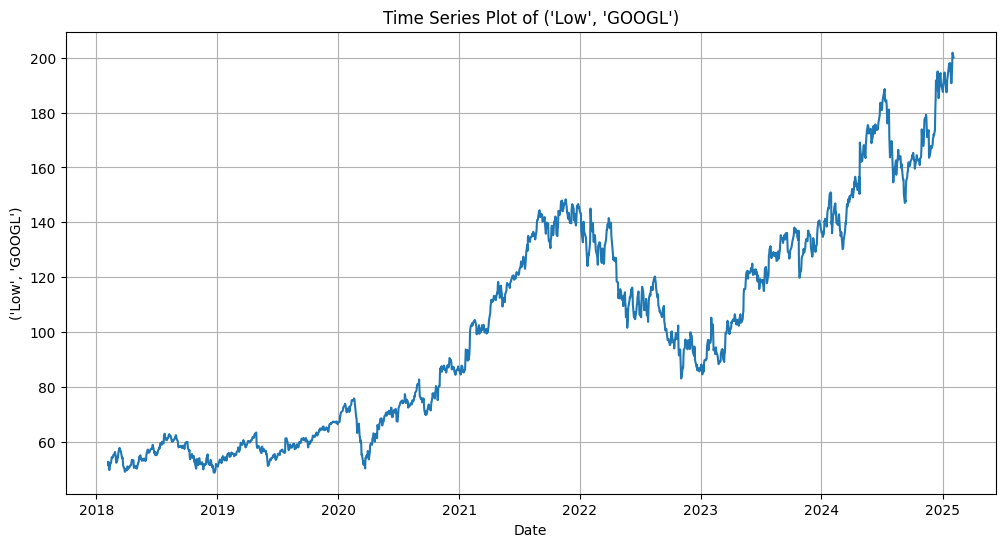

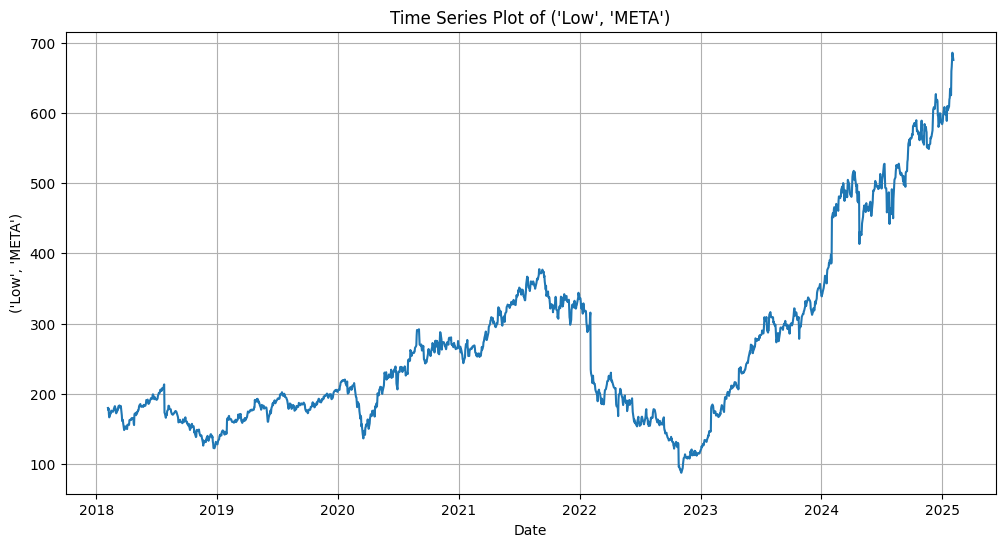

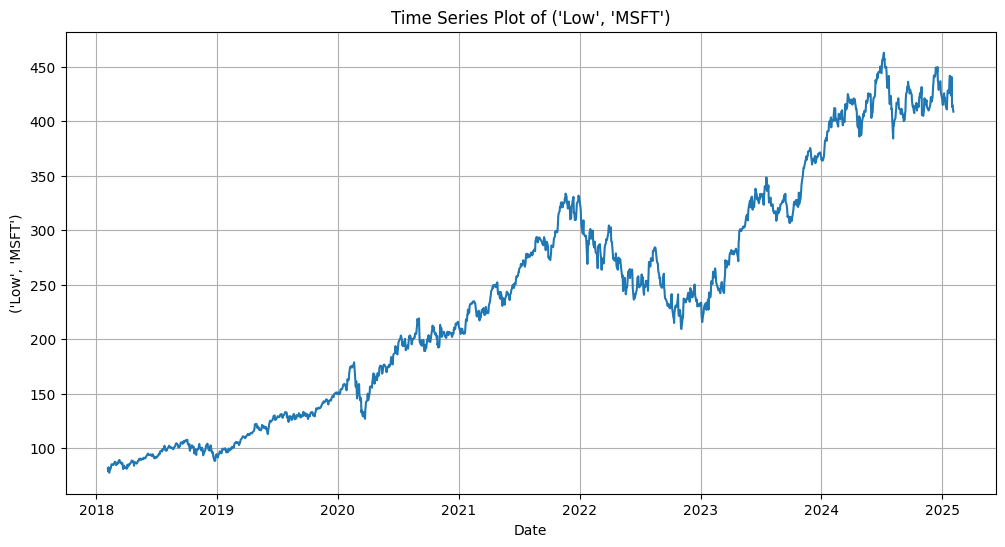

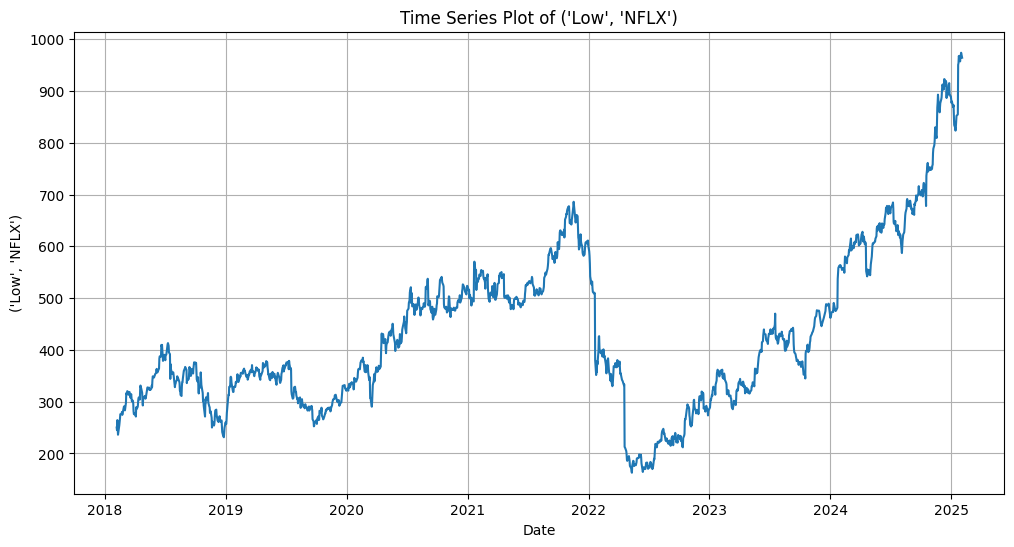

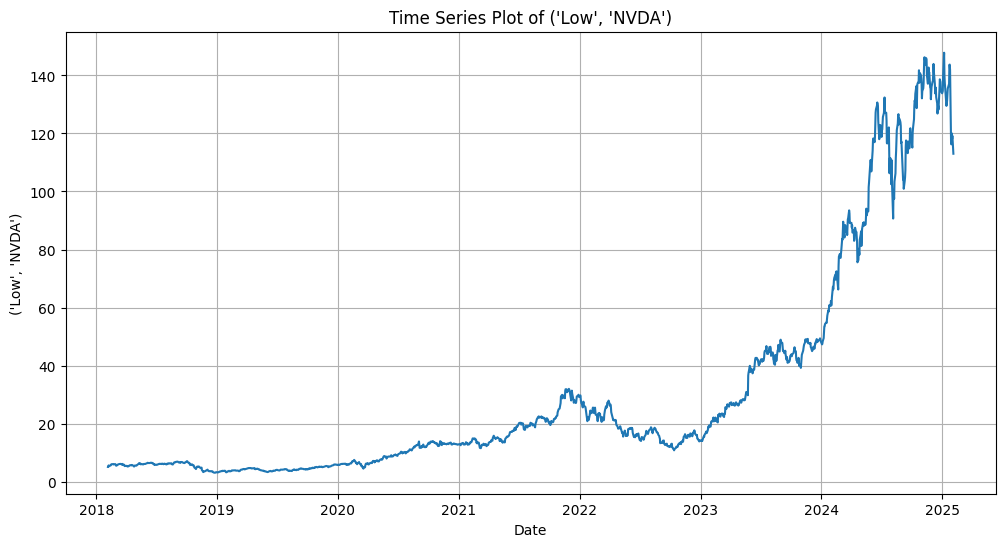

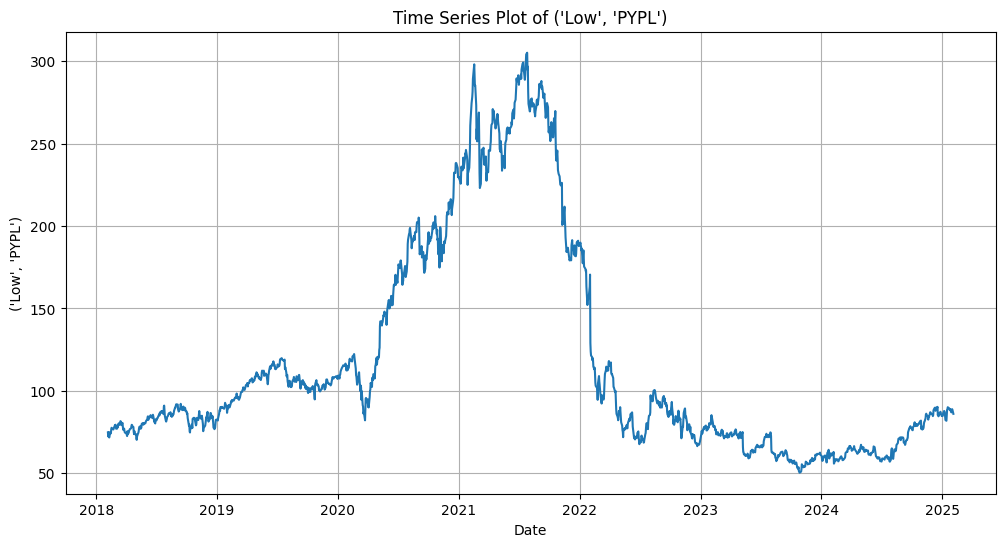

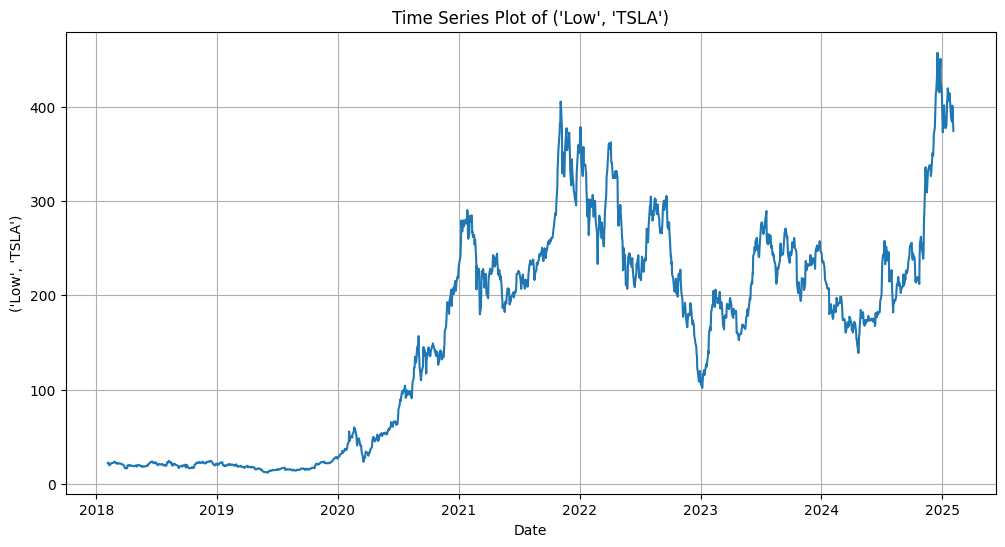

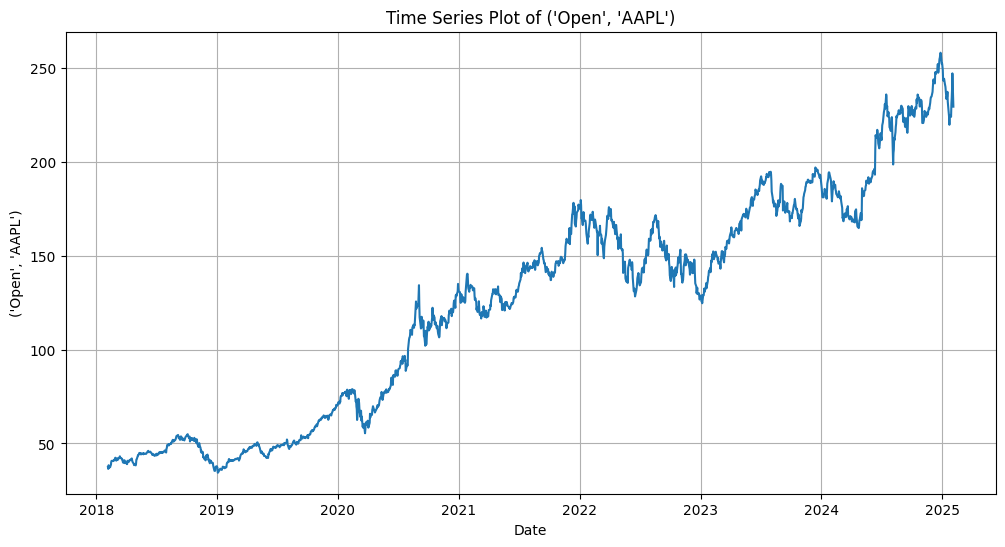

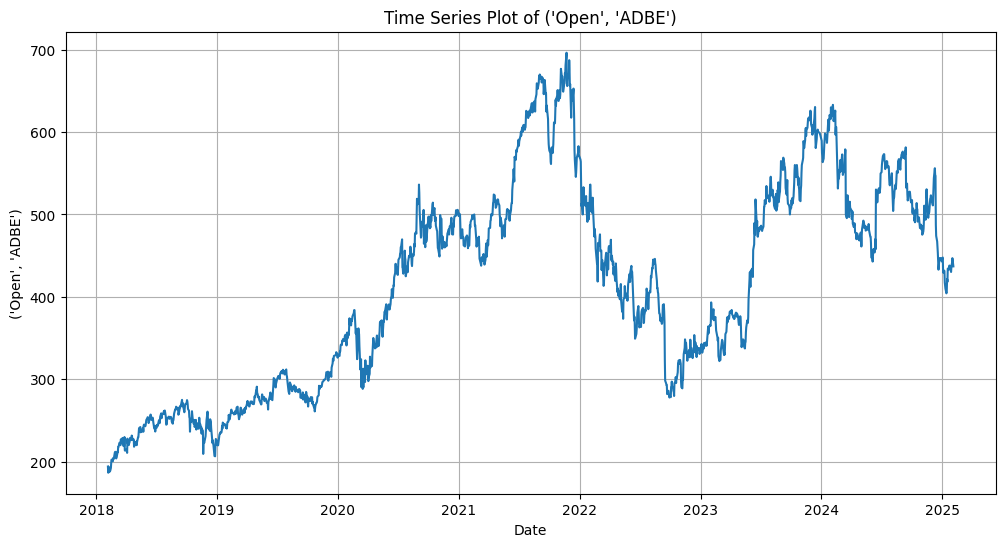

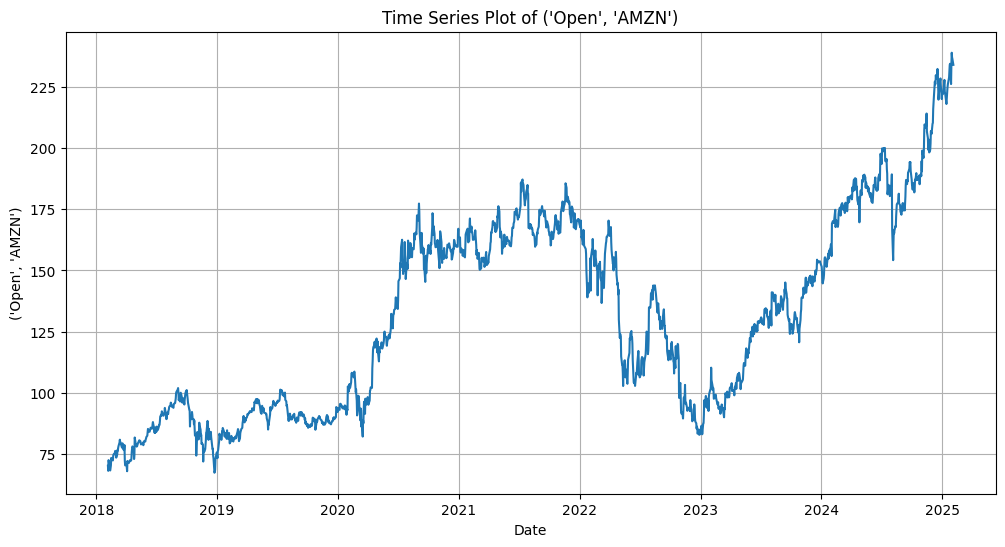

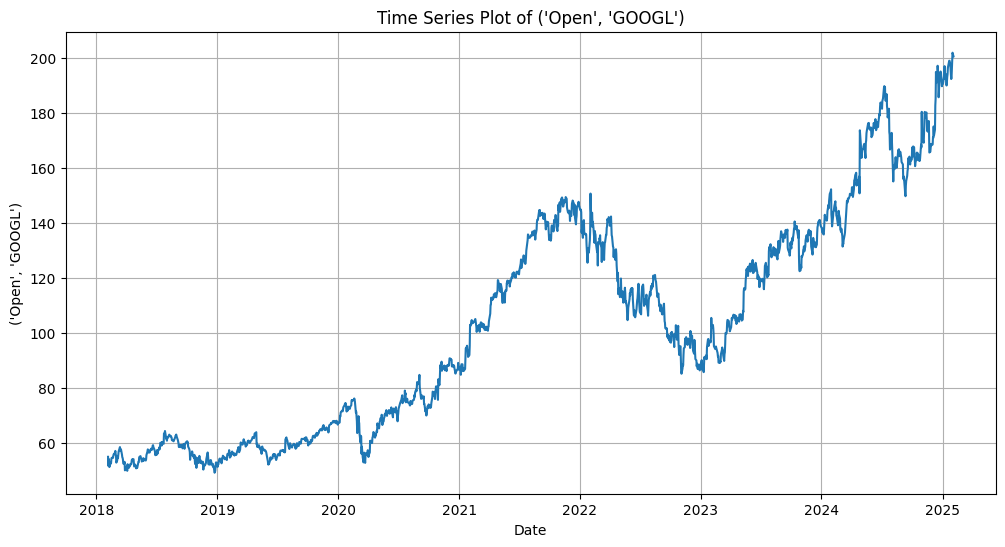

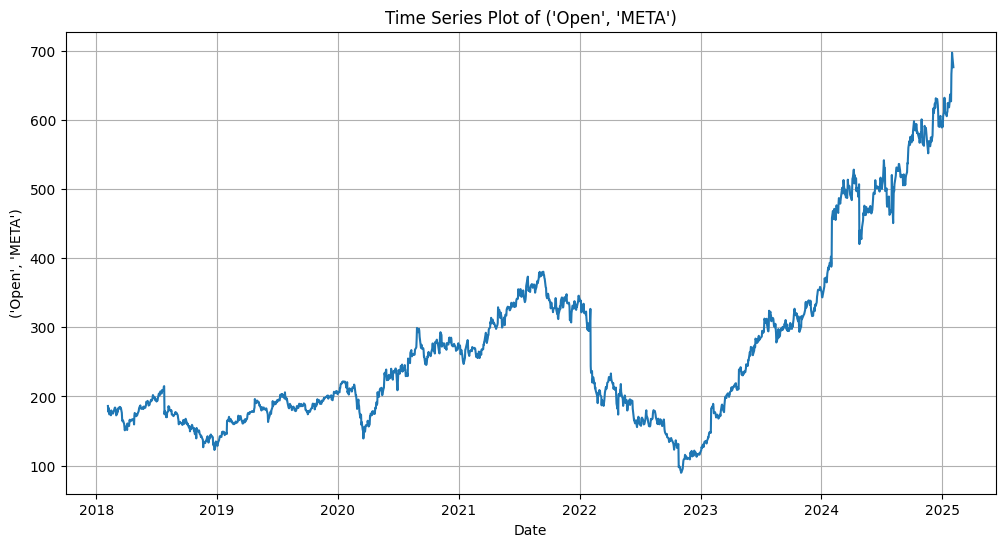

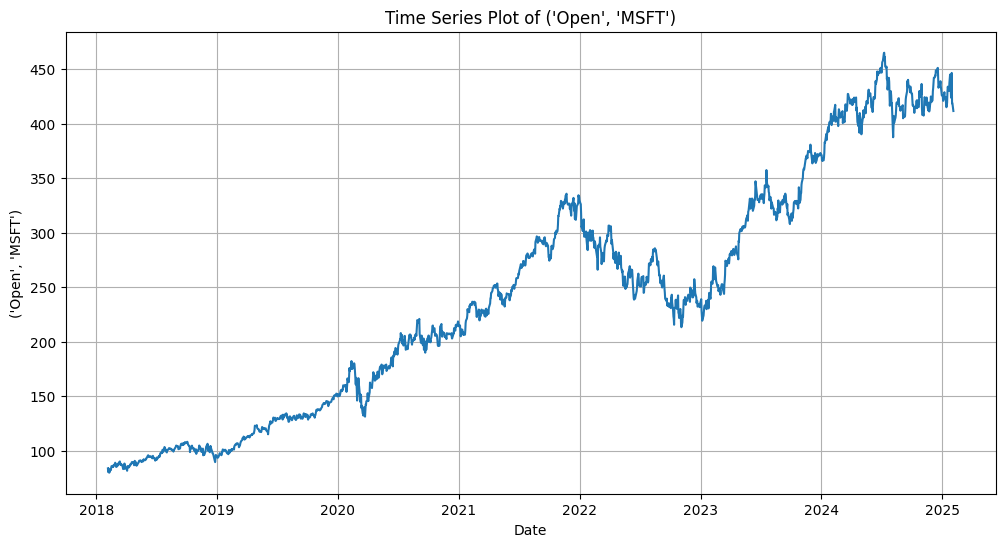

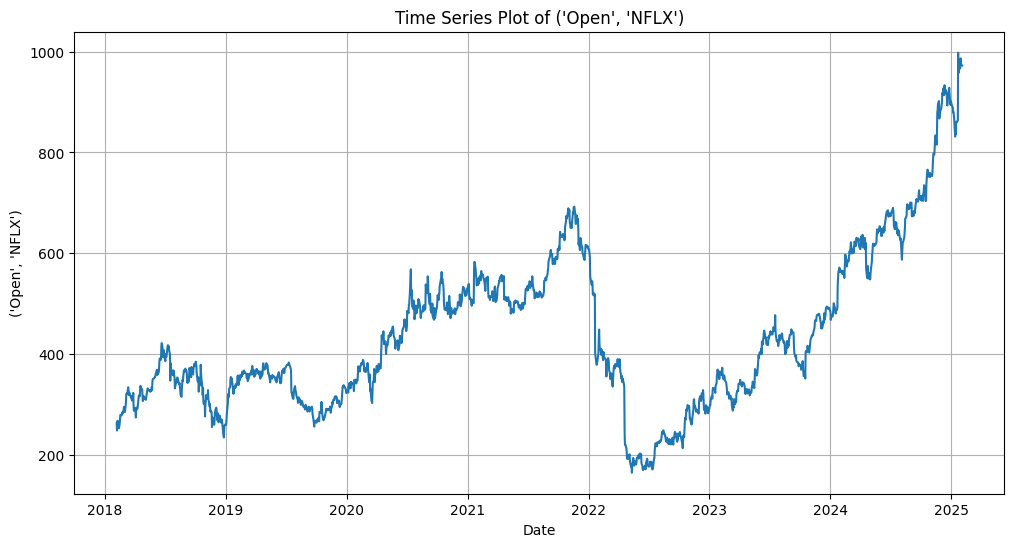

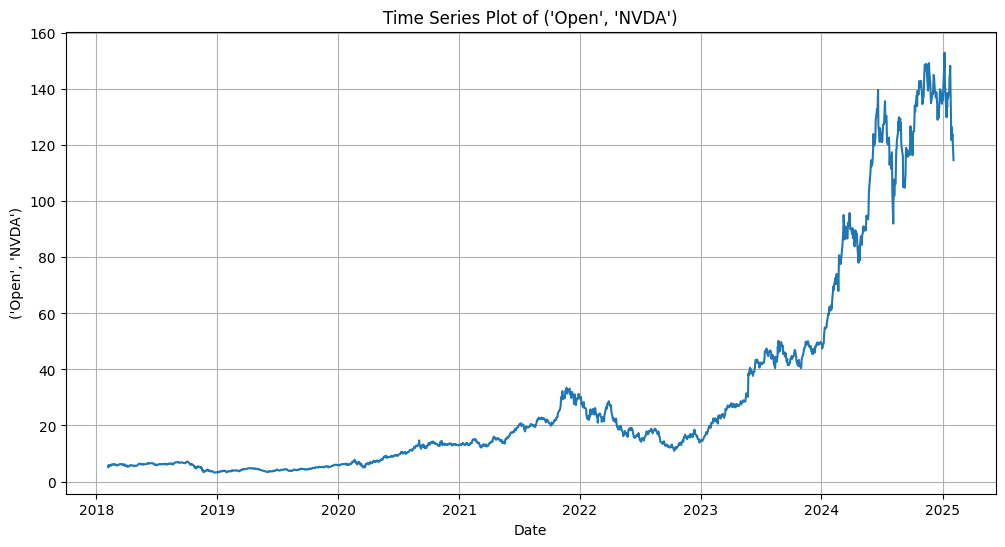

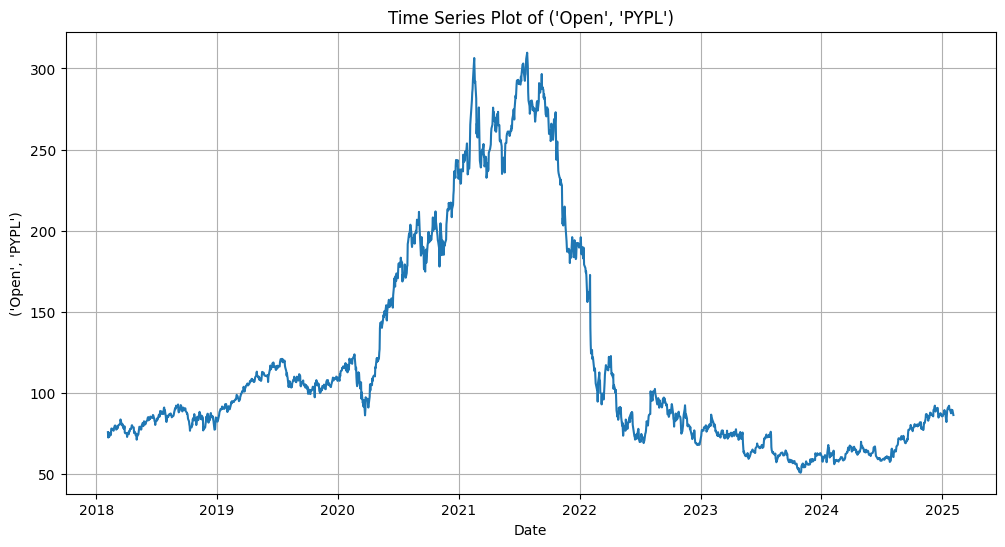

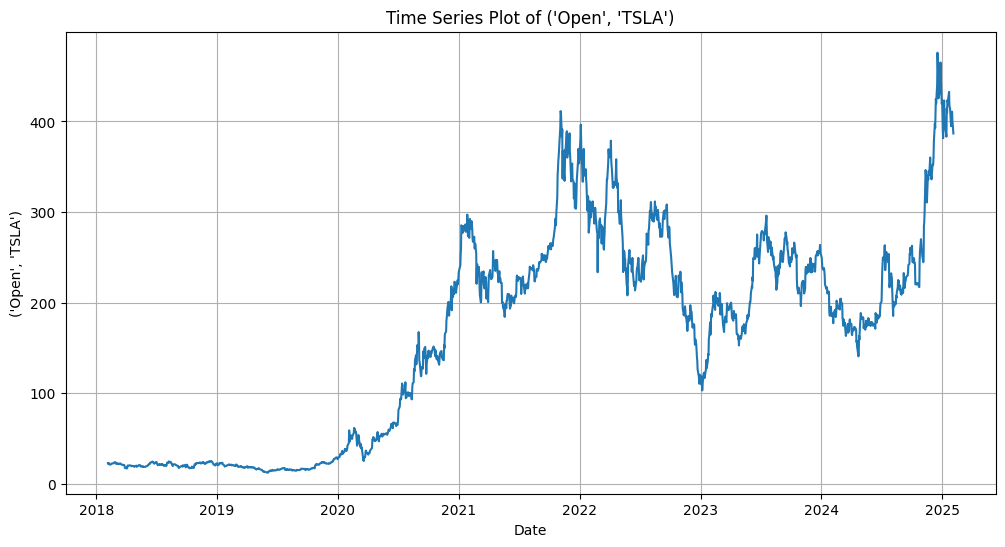

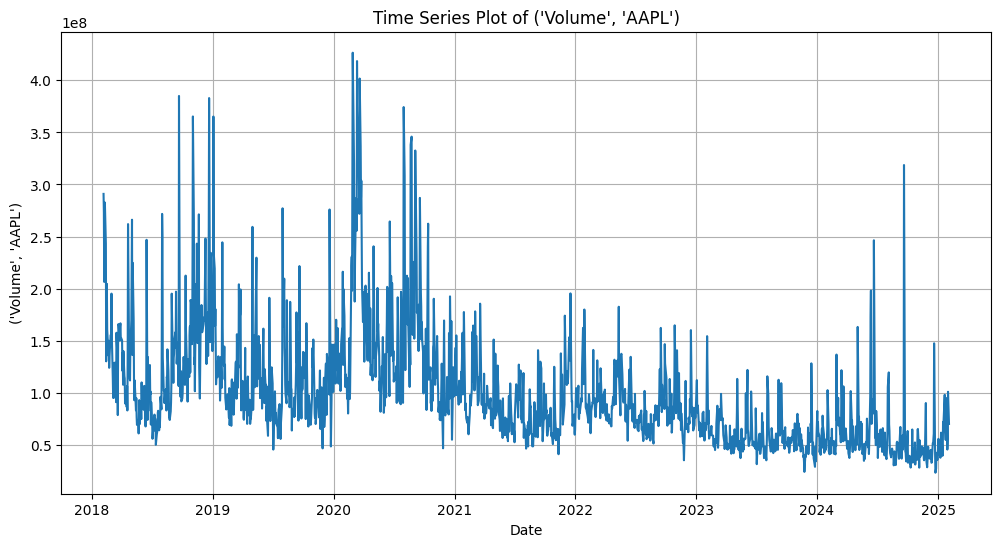

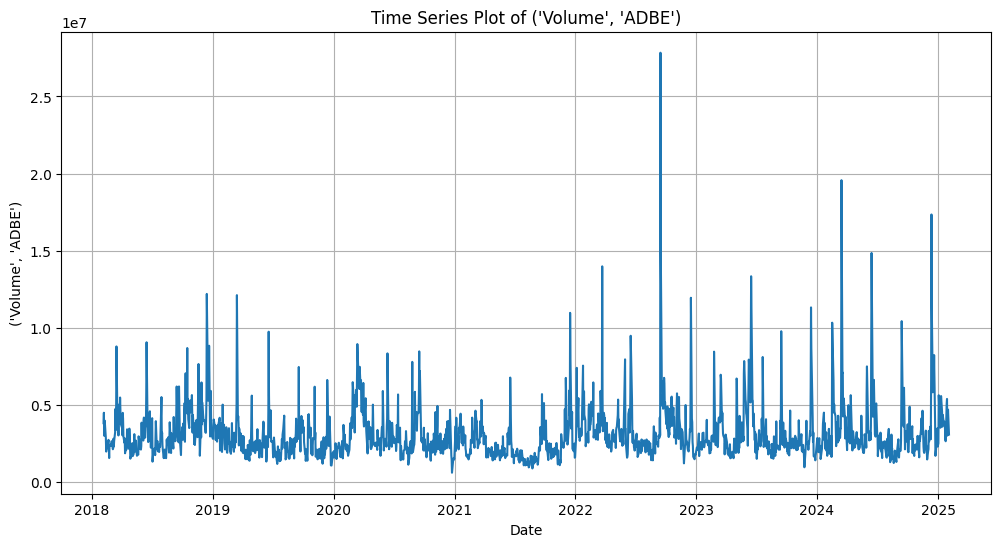

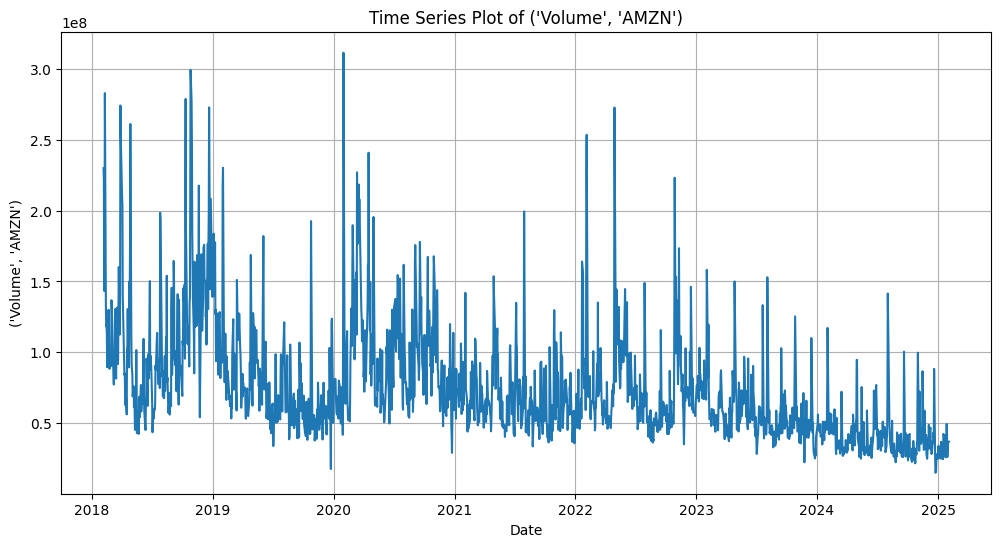

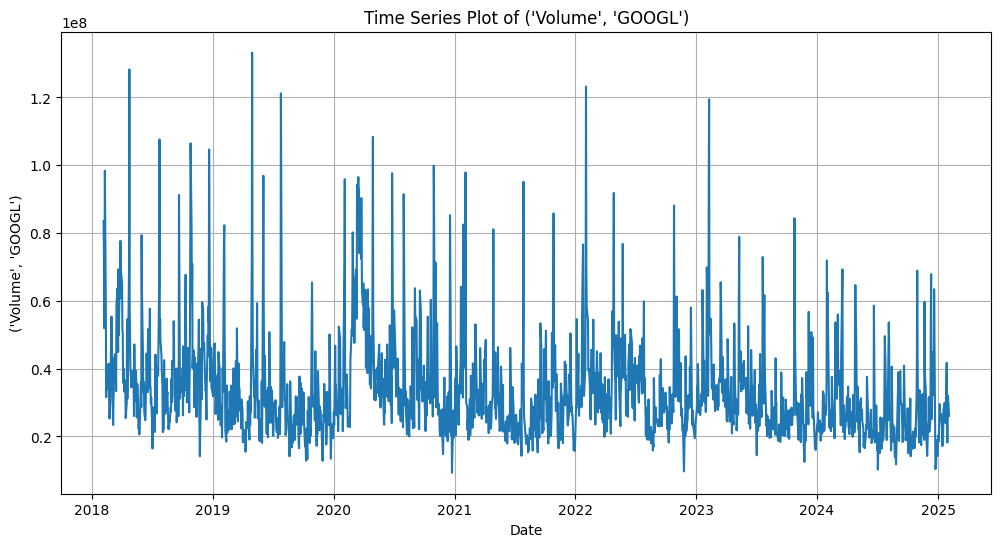

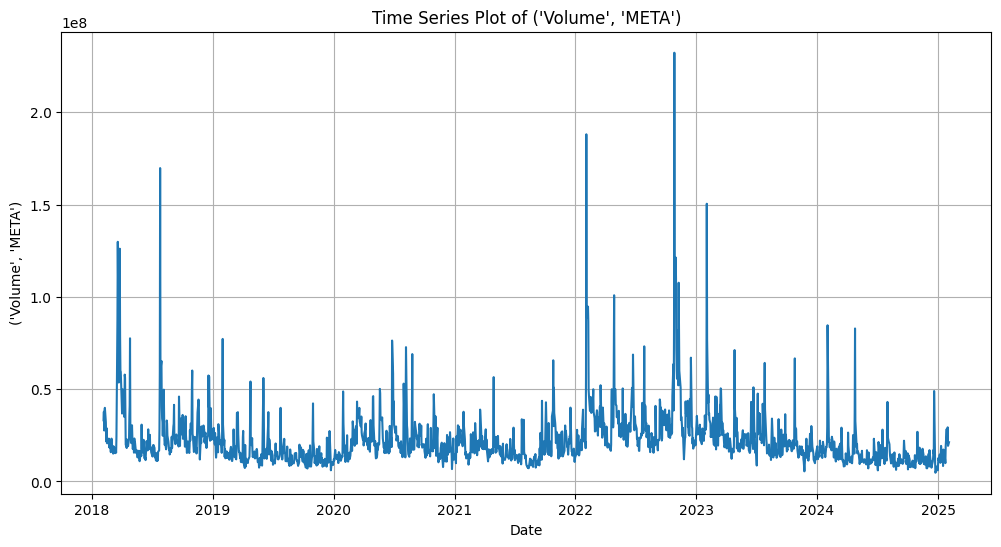

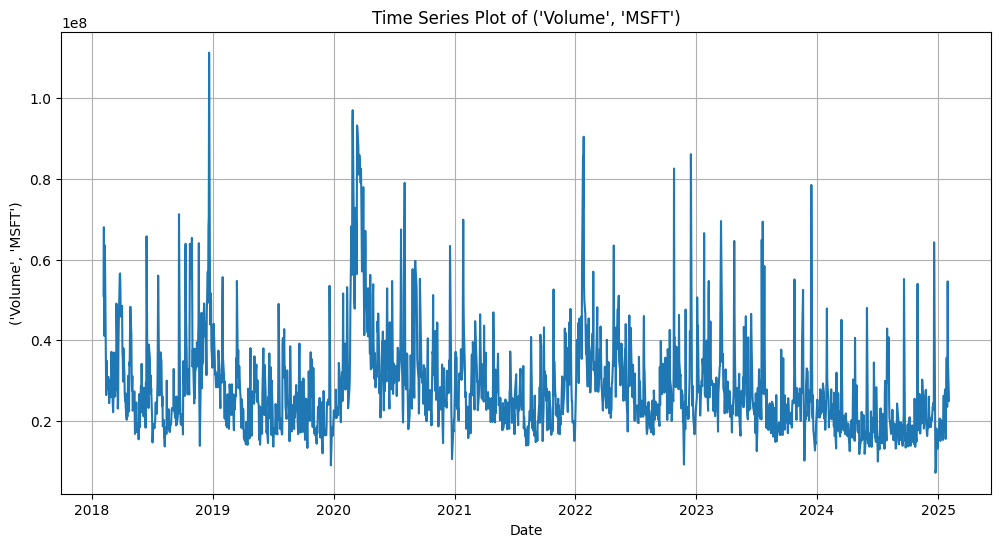

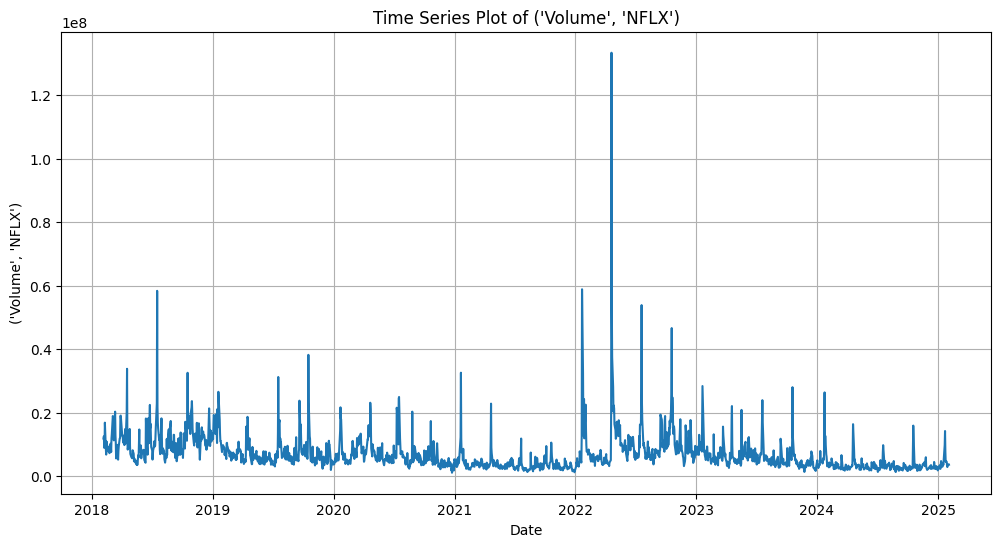

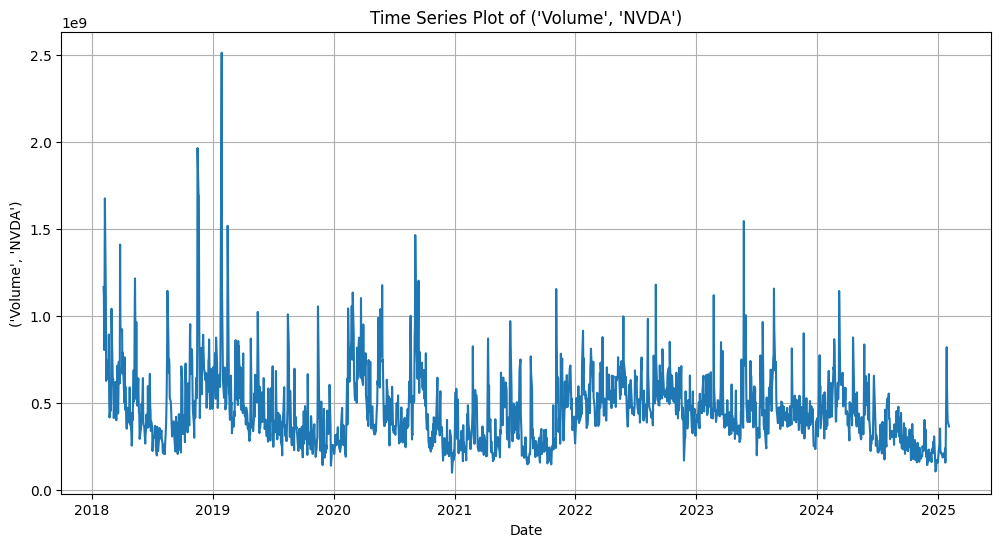

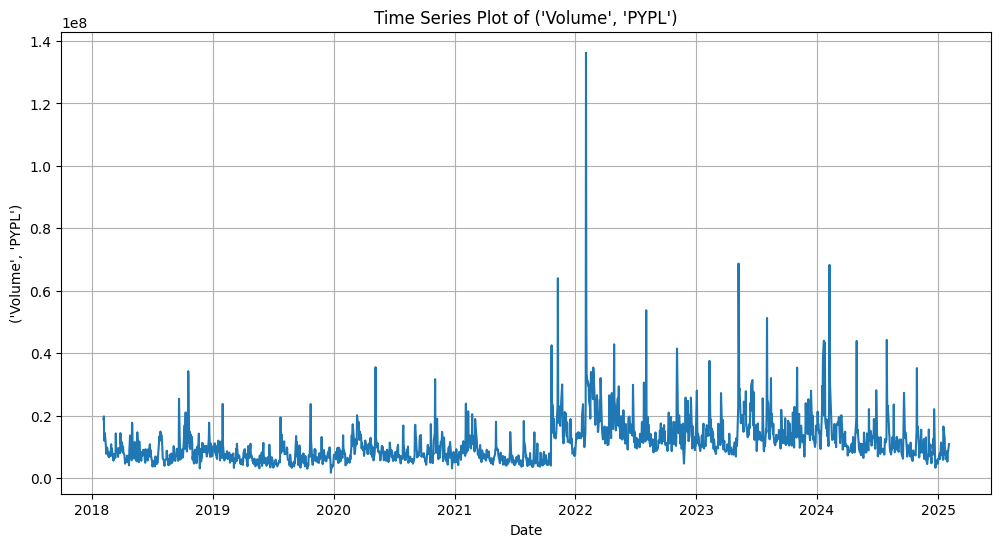

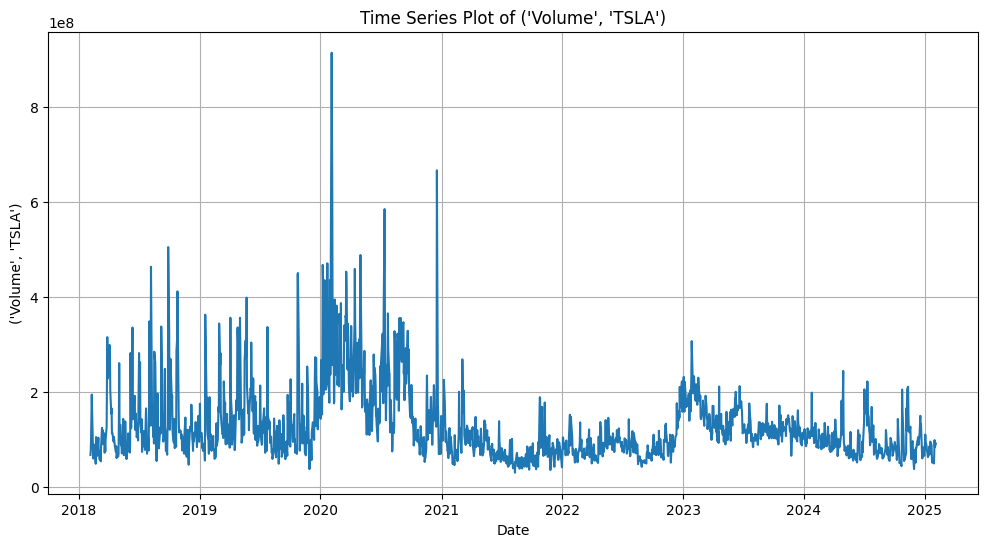

In [ ]:
# prompt: time series data for columns

# Time series analysis for each column
def time_series_analysis(df):
    for col in df.columns:
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df[col])
        plt.title(f"Time Series Plot of {col}")
        plt.xlabel("Date")
        plt.ylabel(col)
        plt.grid(True)
        plt.show()

time_series_analysis(df)

### Multivariate


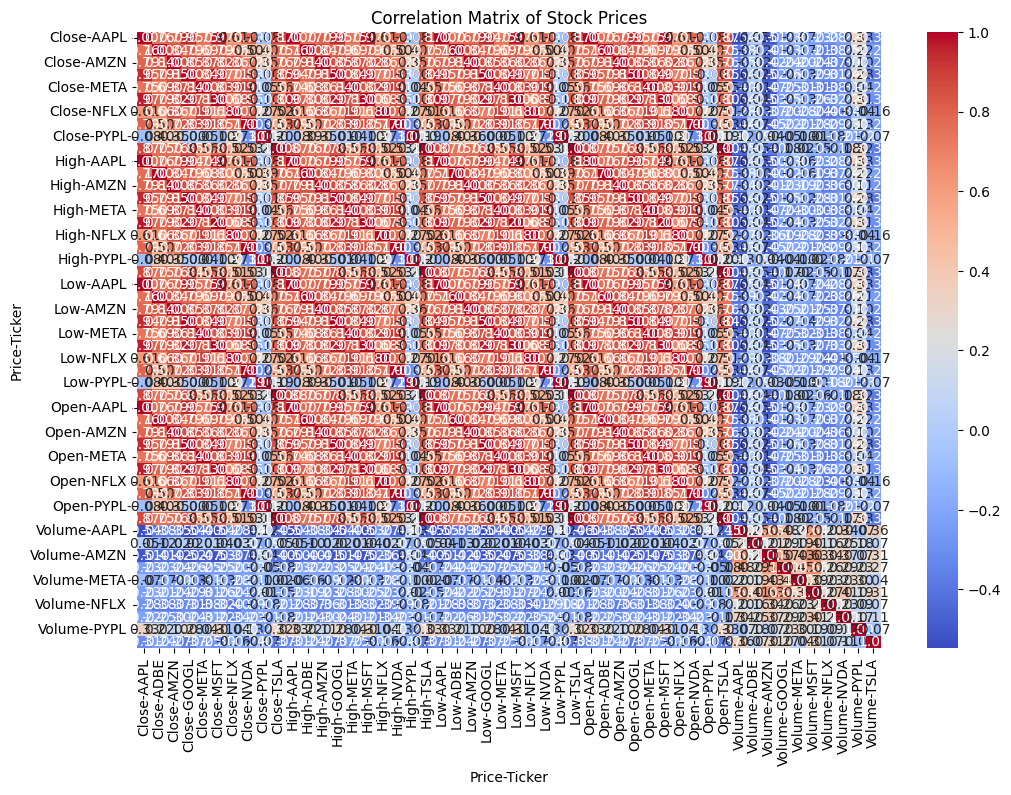

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7cddd064c540> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7cddd05cc9a0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# prompt: generate multivariate plots

import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stock Prices')
plt.show()


# Pair plot
sns.pairplot(df)
plt.suptitle('Pairwise Relationships of Stock Prices', y=1.02)
plt.show()

# Scatter plot matrix (alternative to pairplot)
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

## Data Pre-processing

### Outlier detection

In [ ]:
# Code to be used checking for outliers.
Q1 = df.quantile(0.25)  # The 25th percentile.
Q3 = df.quantile(0.75)  # The 75th percentile.

IQR = Q3 - Q1           # Inter Quantile Range (75th perentile - 25th percentile)

lower = Q1 - 1.5 * IQR  # Finding the lower bounds for all values. All values outside these bounds are outliers.
upper = Q3 + 1.5 * IQR  # Finding the upper bounds for all values. All values outside these bounds are outliers.

In [ ]:
# Checking the percentages of outliers, as defined by the previous cell.
((df.select_dtypes(include=["float64", "int64"]) < lower)
    |(df.select_dtypes(include=["float64", "int64"]) > upper)
).sum() / len(data) * 100

Price
Close    0.000
High     0.000
Low      0.000
Open     0.000
Volume   4.486
dtype: float64

* It was determined not to remove outliers since it is such a small subset of the data

### Add target_close column


In [ ]:
df.head(5)

Price       Close   High    Low   Open     Volume
Date                                             
2018-02-05 36.814 38.553 36.699 37.428  290954000
2018-02-06 38.353 38.515 36.229 36.424  272975200
2018-02-07 37.532 38.440 37.421 38.367  206434400
2018-02-08 36.499 37.875 36.471 37.708  217562000
2018-02-09 36.946 37.295 35.488 37.102  282690400

In [ ]:
# Create a shifted 'Close' column for the target variable
df['Target_Close'] = df['Close'].shift(-1)

In [ ]:
# Drop the last row (which will have NaN in 'Target_Close')
df = df[:-1]

In [ ]:
df.head()

Price       Close   High    Low   Open     Volume  Target_Close
Date                                                           
2018-02-05 36.814 38.553 36.699 37.428  290954000        38.353
2018-02-06 38.353 38.515 36.229 36.424  272975200        37.532
2018-02-07 37.532 38.440 37.421 38.367  206434400        36.499
2018-02-08 36.499 37.875 36.471 37.708  217562000        36.946
2018-02-09 36.946 37.295 35.488 37.102  282690400        38.434

In [ ]:
# Checking the data frame for null values.
if df.isnull().values.any():
  print("There are null values.")
else:
  print("There are no null values.")

There are null values.


### Test-train split

In [ ]:
X = df.drop(columns=['Close'])
y = df['Target_Close']

In [ ]:
# Splitting data into training and temp data frames.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=1)

In [ ]:
# Splitting temp data frame into validation and test data frames.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=1)

In [ ]:
# Printing the size of the Training, Validation, and Test data frames.
print("*"*40)
print("Shape of Training Set : ", X_train.shape)
print("Shape of Validation Set", X_val.shape)
print("Shape of Test Set : ", X_test.shape)
print("*"*40)

****************************************
Shape of Training Set :  (880, 5)
Shape of Validation Set (528, 5)
Shape of Test Set :  (352, 5)
****************************************


## Model Building

In [ ]:
# Train the Model (Random Forest Example)
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

Mean Squared Error: 0.2682146249060257
R-squared: 0.9999233582563579
Comparison of predicted vs actual values:
            Actual  Predicted
Date                         
2019-09-12  52.860     52.919
2023-11-07 181.759    181.648
2024-06-21 207.671    212.227
2022-03-04 156.932    157.155
2020-03-05  70.219     70.479
2019-08-19  50.832     50.847
2023-11-14 187.093    186.753
2022-04-11 165.168    165.196
2024-06-14 216.182    215.438
2025-01-17 222.640    222.655
2018-11-07  49.784     49.765
2018-08-23  51.436     51.471
2023-12-28 191.591    191.638
2022-12-28 128.261    128.095
2024-04-03 168.211    168.213
2023-01-12 133.358    133.472
2020-01-24  74.880     75.072
2021-05-27 122.240    122.242
2022-10-12 141.268    141.178
2019-08-27  49.665     49.694


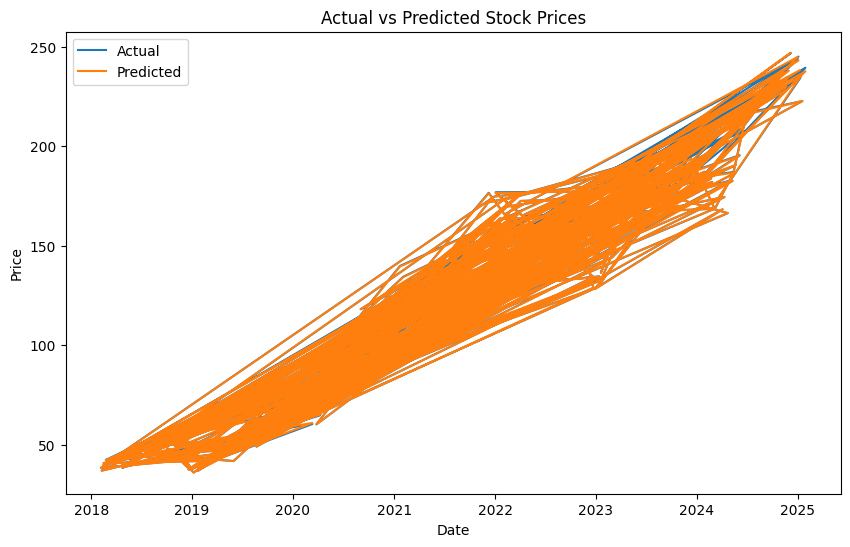

In [ ]:
# prompt: compare y_pred with actual y values

from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

#Further analysis and comparison
print("Comparison of predicted vs actual values:")
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison_df.head(20)) #Print the first 20 for example

#Visualization (optional but recommended)
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
y_pred.shape

(352,)

In [ ]:
df.shape

(1760, 6)

## Computing Financial Indicators

### Moving Averages (SMA)

In [ ]:
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

In [ ]:
df['Close']

Date
2018-02-05    36.814
2018-02-06    38.353
2018-02-07    37.532
2018-02-08    36.499
2018-02-09    36.946
               ...  
2025-01-29   239.360
2025-01-30   237.590
2025-01-31   236.000
2025-02-03   228.010
2025-02-04   232.800
Name: Close, Length: 1760, dtype: float64

In [ ]:
# # For all tickers
# for ticker in tickers: #Assuming your tickers list is defined
#     df[('SMA_50', ticker)] = df[('Close', ticker)].rolling(window=50).mean()
#     df[('SMA_200', ticker)] = df[('Close', ticker)].rolling(window=200).mean()

In [ ]:
df.head()

Price       Close   High    Low   Open     Volume  Target_Close  SMA_50  \
Date                                                                      
2018-02-05 36.814 38.553 36.699 37.428  290954000        38.353     NaN   
2018-02-06 38.353 38.515 36.229 36.424  272975200        37.532     NaN   
2018-02-07 37.532 38.440 37.421 38.367  206434400        36.499     NaN   
2018-02-08 36.499 37.875 36.471 37.708  217562000        36.946     NaN   
2018-02-09 36.946 37.295 35.488 37.102  282690400        38.434     NaN   

Price       SMA_200  
Date                 
2018-02-05      NaN  
2018-02-06      NaN  
2018-02-07      NaN  
2018-02-08      NaN  
2018-02-09      NaN

In [ ]:
df.tail()

Price        Close    High     Low    Open     Volume  Target_Close  SMA_50  \
Date                                                                          
2025-01-29 239.360 239.860 234.010 234.120   45486100       237.590 239.821   
2025-01-30 237.590 240.790 237.210 238.670   55658300       236.000 240.008   
2025-01-31 236.000 247.190 233.440 247.190  101075100       228.010 240.228   
2025-02-03 228.010 231.830 225.700 229.990   73063300       232.800 240.228   
2025-02-04 232.800 233.130 226.650 227.250   44983200       231.250 240.318   

Price       SMA_200  
Date                 
2025-01-29  218.783  
2025-01-30  219.092  
2025-01-31  219.411  
2025-02-03  219.707  
2025-02-04  220.034

### Relative Strength Index (RSI)

In [ ]:
def compute_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI_14'] = 100 - (100 / (1 + rs))
    return df

df = compute_rsi(df)

In [ ]:
df.head()

Price       Close   High    Low   Open     Volume  Target_Close  SMA_50  \
Date                                                                      
2018-02-05 36.814 38.553 36.699 37.428  290954000        38.353     NaN   
2018-02-06 38.353 38.515 36.229 36.424  272975200        37.532     NaN   
2018-02-07 37.532 38.440 37.421 38.367  206434400        36.499     NaN   
2018-02-08 36.499 37.875 36.471 37.708  217562000        36.946     NaN   
2018-02-09 36.946 37.295 35.488 37.102  282690400        38.434     NaN   

Price       SMA_200  RSI_14  
Date                         
2018-02-05      NaN     NaN  
2018-02-06      NaN     NaN  
2018-02-07      NaN     NaN  
2018-02-08      NaN     NaN  
2018-02-09      NaN     NaN

In [ ]:
df.tail()

Price        Close    High     Low    Open     Volume  Target_Close  SMA_50  \
Date                                                                          
2025-01-29 239.360 239.860 234.010 234.120   45486100       237.590 239.821   
2025-01-30 237.590 240.790 237.210 238.670   55658300       236.000 240.008   
2025-01-31 236.000 247.190 233.440 247.190  101075100       228.010 240.228   
2025-02-03 228.010 231.830 225.700 229.990   73063300       232.800 240.228   
2025-02-04 232.800 233.130 226.650 227.250   44983200       231.250 240.318   

Price       SMA_200  RSI_14  
Date                         
2025-01-29  218.783  47.259  
2025-01-30  219.092  45.204  
2025-01-31  219.411  49.133  
2025-02-03  219.707  44.143  
2025-02-04  220.034  49.588

### Bollinger Bands

In [ ]:
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['Bollinger_Upper'] = df['SMA_20'] + (df['Close'].rolling(20).std() * 2)
df['Bollinger_Lower'] = df['SMA_20'] - (df['Close'].rolling(20).std() * 2)
df = df.drop('SMA_20', axis=1)

In [ ]:
df.head()

Price       Close   High    Low   Open     Volume  Target_Close  SMA_50  \
Date                                                                      
2018-02-05 36.814 38.553 36.699 37.428  290954000        38.353     NaN   
2018-02-06 38.353 38.515 36.229 36.424  272975200        37.532     NaN   
2018-02-07 37.532 38.440 37.421 38.367  206434400        36.499     NaN   
2018-02-08 36.499 37.875 36.471 37.708  217562000        36.946     NaN   
2018-02-09 36.946 37.295 35.488 37.102  282690400        38.434     NaN   

Price       SMA_200  RSI_14  Bollinger_Upper  Bollinger_Lower  
Date                                                           
2018-02-05      NaN     NaN              NaN              NaN  
2018-02-06      NaN     NaN              NaN              NaN  
2018-02-07      NaN     NaN              NaN              NaN  
2018-02-08      NaN     NaN              NaN              NaN  
2018-02-09      NaN     NaN              NaN              NaN

In [ ]:
df.tail()

Price        Close    High     Low    Open     Volume  Target_Close  SMA_50  \
Date                                                                          
2025-01-29 239.360 239.860 234.010 234.120   45486100       237.590 239.821   
2025-01-30 237.590 240.790 237.210 238.670   55658300       236.000 240.008   
2025-01-31 236.000 247.190 233.440 247.190  101075100       228.010 240.228   
2025-02-03 228.010 231.830 225.700 229.990   73063300       232.800 240.228   
2025-02-04 232.800 233.130 226.650 227.250   44983200       231.250 240.318   

Price       SMA_200  RSI_14  Bollinger_Upper  Bollinger_Lower  
Date                                                           
2025-01-29  218.783  47.259          254.211          217.866  
2025-01-30  219.092  45.204          251.846          218.770  
2025-01-31  219.411  49.133          249.532          219.642  
2025-02-03  219.707  44.143          248.347          219.243  
2025-02-04  220.034  49.588          247.106          219.428

### Moving average convergence/divergence (MACD)

In [ ]:
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [ ]:
df.head()

Price       Close   High    Low   Open     Volume  Target_Close  SMA_50  \
Date                                                                      
2018-02-05 36.814 38.553 36.699 37.428  290954000        38.353     NaN   
2018-02-06 38.353 38.515 36.229 36.424  272975200        37.532     NaN   
2018-02-07 37.532 38.440 37.421 38.367  206434400        36.499     NaN   
2018-02-08 36.499 37.875 36.471 37.708  217562000        36.946     NaN   
2018-02-09 36.946 37.295 35.488 37.102  282690400        38.434     NaN   

Price       SMA_200  RSI_14  Bollinger_Upper  Bollinger_Lower  EMA_12  EMA_26  \
Date                                                                            
2018-02-05      NaN     NaN              NaN              NaN  36.814  36.814   
2018-02-06      NaN     NaN              NaN              NaN  37.051  36.928   
2018-02-07      NaN     NaN              NaN              NaN  37.125  36.973   
2018-02-08      NaN     NaN              NaN              NaN  37.029  36.938   
2018-02-09      NaN     NaN              NaN              NaN  37.016  36.939   

Price       MACD  MACD_Signal  
Date                           
2018-02-05 0.000        0.000  
2018-02-06 0.123        0.025  
2018-02-07 0.152        0.050  
2018-02-08 0.091        0.058  
2018-02-09 0.077        0.062

In [ ]:
df.tail()

Price        Close    High     Low    Open     Volume  Target_Close  SMA_50  \
Date                                                                          
2025-01-29 239.360 239.860 234.010 234.120   45486100       237.590 239.821   
2025-01-30 237.590 240.790 237.210 238.670   55658300       236.000 240.008   
2025-01-31 236.000 247.190 233.440 247.190  101075100       228.010 240.228   
2025-02-03 228.010 231.830 225.700 229.990   73063300       232.800 240.228   
2025-02-04 232.800 233.130 226.650 227.250   44983200       231.250 240.318   

Price       SMA_200  RSI_14  Bollinger_Upper  Bollinger_Lower  EMA_12  EMA_26  \
Date                                                                            
2025-01-29  218.783  47.259          254.211          217.866 232.991 236.311   
2025-01-30  219.092  45.204          251.846          218.770 233.698 236.406   
2025-01-31  219.411  49.133          249.532          219.642 234.052 236.376   
2025-02-03  219.707  44.143          248.347          219.243 233.123 235.756   
2025-02-04  220.034  49.588          247.106          219.428 233.073 235.537   

Price        MACD  MACD_Signal  
Date                            
2025-01-29 -3.321       -3.635  
2025-01-30 -2.708       -3.449  
2025-01-31 -2.324       -3.224  
2025-02-03 -2.633       -3.106  
2025-02-04 -2.464       -2.978

## Saving file to CSV for Tableau

In [ ]:
df_drop_na = df.dropna()

In [ ]:
df_drop_na.isna().sum()

Price
Close              0
High               0
Low                0
Open               0
Volume             0
Target_Close       0
SMA_50             0
SMA_200            0
RSI_14             0
Bollinger_Upper    0
Bollinger_Lower    0
EMA_12             0
EMA_26             0
MACD               0
MACD_Signal        0
dtype: int64

In [ ]:
df_drop_na.to_csv("stock_data_tableau.csv", index=True)